FD-Deeploc 代码结构分析
1. 数据模拟：生成训练和测试用的模拟SMLM数据
2. 神经网络模型：包含Unet架构的深度学习模型
3. 训练与损失函数：训练流程和损失计算
4. 推理与后处理：推理模型和非极大值抑制等后处理
5. 评估工具：性能评估指标计算

# 核心模块详解
## 数据模拟器
主要功能：
- 基于物理模型模拟SMLM图像
- 考虑PSF、像差、噪声等真实因素
- 生成带有ground truth的训练数据

工程细节：
- 使用PSF_VECTOR_GPU类计算矢量PSF模型
- 支持EMCCD和CMOS两种相机噪声模型
- 实现了Perlin噪声模拟背景不均匀性
- 分子位置采样考虑光物理特性（闪烁）
- 支持分块处理大视场图像

psf_params = {  
    'NA': 1.4,                  # 数值孔径    
    'refmed': 1.33,             # 介质折射率  
    'refcov': 1.5,              # 盖玻片折射率  
    'refimm': 1.52,             # 浸没油折射率  
    'lambda': 680,              # 波长(nm)  
    'pixel_size_xy': [100,100], # 像素尺寸(nm)  
    'aber_map': aber_map,       # 像差图  
    'psf_size': 64              # PSF计算尺寸  
}  

simulation_params = {  
    'backg': 100,               # 背景值(ADU)  
    'em_gain': 300,             # EMCCD增益  
    'qe': 0.9,                  # 量子效率  
    'spurious_c': 0.01,         # 虚假电荷  
    'sig_read': 30,             # 读出噪声  
    'e_per_adu': 2.3,           # 每ADU电子数  
    'baseline': 100,            # 基线值  
    'perlin_noise': True,       # 是否使用Perlin噪声  
    'pn_res': 32,               # Perlin噪声分辨率  
    'pn_factor': 0.2            # Perlin噪声强度  
}  

## 深度学习模型
### 网络架构
1. Frame Module:处理单个/多个输入帧Unet
2. Context Module: 融合时空上下文信息
3. Output Module:输出定位结果 概率、位置、不确定性

工程细节：
- 使用CoordConv坐标卷积整合位置信息
- 多尺度Unet结构处理不同尺寸特征
- 输出包含：
    - 分子存在概率 P
    - 亚像素位置(x,y,z)
    - 光子数 Intensity
    - 定位不确定性 x, y, z, I sigma

## 训练流程
### 训练特点：
- 多任务联合训练
    1. 分子存在概率
    2. 精确定位
    3. 不确定性估计

- 训练技巧
    1. 梯度裁剪
    2. 学习率衰减
    3. 分块训练大视场图像
    4. 动态调整样本权重

## 推理与后处理
### 主要流程
1. 模型推理
2. 非极大值抑制
3. 偏移重缩放
4. 结果格式化

### 工程优化：
- 分块处理大图像
- GPU加速计算
- 批处理优化

## 评估指标
### 评估指标：
1. Recall / Precision:召回率、精确度
2. Jaccard Index：交并比
3. RMSE： 定位误差
4. JOR：Jaccard/RMSE综合指标
5. Efficiency：综合效率指标

# 关键工程实现
1. 大视场处理策略
2. 坐标感知卷积 CoordConv 
3. 物理模型约束的训练数据
4. 多任务输出处理

# 像差映射的本质
像差映射是一个3D张量height, width, n_coeffs
数据生成时根据分子位置查询局部像差
计算带有像差的PSF
psf = self._vector_psf(zernike_coeffs, z, otf_scales)
在__vector__psf函数中
1.构建光瞳函数
2.矢量衍射计算
3.考虑OTF缩放  OTF缩放反映不同空间位置的点扩散函数的展宽或收缩成都

OTF缩放用来描述光学系统在不同方向上传递高频信息的能力变化
工程上像差映射中的最后两个参数控制着PSF的各向异性变形
通过控制OTF缩放参数，可以更真实的模拟大视场显微镜中边缘区域的成像质量下降情况

# 多色成像的核心需求
1. 多波长PSF建模
    - 在PSF_VECTOR_GPU类引入波长参数，生成不同通道的PSF
    - 色差矫正，我还不是很理解这个参数的意义
2. 多通道数据生成
    - 在数据模拟函数中模拟多通道图像，每个通道独立生成PSF后叠加
    - 通道配准误差建模，在模拟数据时引入随即平移、旋转、模拟实际光学系统的通道偏移
3. 网络架构升级
    1. 多通道输入支持
        - 修改网络输入层接受多通道图像
        - 通道特征解耦， 添加通道注意力模块或分支网络，增强网络区分不同通道特征的能力。
4. 损失函数优化
    1.通道特异性损失
5. 通道特异性评估指标
    - 扩展评估函数，分别计算各通道的定位精度
    - 交叉通道干扰分析
        量化通道见信号串扰对定位精度的影响

多色成像的核心需求：
1. 物理本质：
    - 不同波长激发不同荧光标记物 - 独立的目标空间分布
    - 各通道可能有不同的PSF形状
    - 通道间存在配准误差
2. 计算目标
    - 保持各通道定位精度独立优化
    - 仅需在最终可视化时统一坐标系

# 工程细节
1. 数据模拟器升级

class MultiColorSimulator:
    def __init__(self, channels):
        self.psf_models = {
            'red':  PSF_VECTOR_GPU(λ=650nm, aberrations=...)
            'green': PSF_VECTOR_GPU(λ=520nm, aberrations=...)
        }
    
    def simulate(self):
        # 各通道独立生成目标分子位置
        red_pos = generate_random_positions()
        green_pos = generate_random_positions()

        # 分别渲染PSF
        red_img = render_psf(red_pos, self.psf_models['red'])
        green_img = render_psf(green_pos, self.psf_models['green'])

        return { 'red':red_img, 'green':green_img},{'red':red_pos, 'green':green_pos}

2. 网络架构改进
class MultiColorNet(nn.Module):
    def __init__(self)：
        self.red_branch = SingleChannelSubnet()
        self.green_brach = SingleChannelSubnet()
    
    def forward(self, x):
        red_out = self.red_branch(x['red'])
        green_out = self.green_branch(x['green'])
        return {'red': red_out, 'green': green_out}

# 多色成像的核心问题，串扰！
通过机器学习模拟光谱串扰噪声需要两类核心数据：串扰系数矩阵，单通道纯净信号图像
1. 串扰系数矩阵
数据内容：
crosstalk_matrix = [
    [1.0,  0.05],  # 绿色通道：1 00%自身信号 + 5%红色信号泄漏
    [0.03, 1.0 ]   # 红色通道：100%自身信号 + 3%绿色信号泄漏
]

alpha = (红色通道检测到的绿色染料信号均值) / (绿色通道检测到的绿色染料信号均值)
**可以通过测量或者文献查找的方式确定**

2. 单通道纯净信号图像
数据内容：
每个通道在无串扰的情况下的理想图像，用于混合生成含串扰的模拟数据

def apply_crosstalk(clean_images, crosstalk_matrix):
    channels = list(clean_images.keys())
    clean_stack = np.stack([clean_images[ch] for ch in channels])
    noisy_stack = np.einsum('ij, jhw->ihw', crosstalk_matrix, clean_stack)

    return {ch: noisy_stack[i] for i, ch in enumerate(channels)}

# 光谱解混 Spectral Unmixing

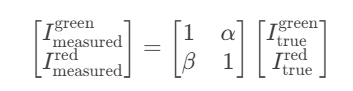

def unmix_images(noisy_images, crosstalk_matrix):
    inv_matrix = np.linalg.inv(crosstalk_matrix)
    noisy_stack = np.stakc([noisy_images[ch] for ch in noisy_images.keys()])
    clean_stack = np.einsum('ij, jhw->ihw', inv_matrix, noisy_stack)



# 多通道配准系统 Multi-Channel Registration System
解决多色超分辨显微成像通道空间错位问题

## 多色超分辨物理局限
不同波长光线通过透镜折射率不同导致焦点偏移（50-300nm），机械漂移（10-100nm/min）、相机安装误差（多相机系统间角度偏差）

1. 跨通道分子关联
未配准时，不同通道检测的同一分子坐标存在差异
配准后可以对其

2. 定量分析矫正
未配准时，Pearson相关系数可能被低估30-50%的水平

## 实现方案
使用多色荧光珠作为基准标记，进行系统校准

动态预测配准方案：
输入多通道图像  
单通道独立定位  
提取高置信度分子坐标  
RNSAC仿射估计  
如果成功应用变换矩阵  
如果失败启用默认参数  
配准后融合分析

## 仿射变换矩阵：
| x' |   | a11 a12 tx |   | x |  
| y' | = | a21 a22 ty | * | y |  
| 1  |   | 0   0   1  |   | 1 |  

a11,a22：缩放因子（典型值0.98-1.02）

a12,a21：剪切分量（通常<0.05）

tx,ty：平移量（50-300nm）

argmin_θ Σ||Tθ(x_i) - y_i||² + λ||θ - θ_default||²

**多通道配准系统**建立跨通道的统一空间坐标系
在物理层面补偿光学系统固有缺陷、最好可以使用金标样本验证。

# 空间串扰变化！
如果传荣是空间变化的，直接使用全局标量系数会导致校正错误，基于空间变化的串扰模型是更合理的解决方案

**受限于光学像差或滤光片的不均匀性，通道A的信号在图像边缘对通道的B的串扰可能比中心更强，另外多光谱成像中，不同波长的散射效应可能导致串扰随空间位置变化**

数学上：串扰并非常数矩阵，而是空间相关的矩阵函数C_ij(x,y)

！需要解决问题
1. 如何测量或建模空间变化的串扰（获取C_ij(x,y)）
2. 高效3地实现空间变化的校正（思考计算复杂度问题）

## 实验校准，测量空间串扰
**实验设计**
- 单染料样本法
 准备仅含单一荧光染料的样本，拍摄其在所有通道的图像
 对于该主染料，主染料色是理想信号
 其他通道检测到的为串扰信号

- 计算串扰核
逐像素串扰系数：
每个位置，串扰系数可以通过实验数据进行估计
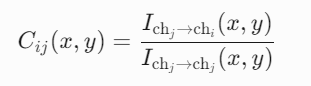

！平滑处理，如果数据噪音较大，可以进行高斯滤波chuli

- 生成空间串扰模型
存储形式：
    将C_ij保存为与图像尺寸相同的二维数组（H x W 的Numpy数组）

- 矫正方法实现


## Raw Input (CH1+CH2)
|- CH1 Branch -> 光子数估计 -> 特征提取  
|- CH2 Branch -> 光子数估计 -> 特征提取  
|- 比例计算 (CH1/Total, CH2/Total, CH1/CH2)  
|- 多级特征融合  
|- 输出头[坐标、强度、颜色概率、不确定性]  


In [ ]:
"""
ratimetric_analysis_system.py

包含完整的数据生成、模型训练和评估流程
包含以下模块：
1. 数据生成模块 (RatiometricDataGenerator)
2. 神经网络模块 (RatioAwareUNet)
3. 数据加载模块 (RatiometricDataset)
4. 训练模块 (Trainer)
5. 评估模块 (ResultAnalyzer)
"""

# -------------------- 模块1: 数据生成 --------------------
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from perlin_noise import PerlinNoise
from typing import Dict, Tuple

class RatiometricDataGenerator:
    def __init__(self, config: Dict):
        self.config = config
        self.image_size = config['image_size']
        self.pixel_size = config['pixel_size']  # nm/pixel
        self.psf_sigma = config['psf_sigma']  # PSF的sigma值（像素单位）
        
        # 通道参数
        self.channels = ['ch1', 'ch2']
        self.cross_ratios = {
            'ch1_to_ch2': config['cross_ratios']['ch1_to_ch2'],
            'ch2_to_ch1': config['cross_ratios']['ch2_to_ch1']
        }
        
        # 背景参数
        self.background_levels = {
            'ch1': config['background']['ch1'],
            'ch2': config['background']['ch2']
        }
        
        # 初始化Perlin噪声生成器
        self.noise_generator = PerlinNoise(octaves=4, seed=config['seed'])

    def generate_molecules(self, num_molecules: int) -> Dict:
        """生成分子属性"""
        # 随机位置 (x, y, z)
        positions = np.random.rand(num_molecules, 3) * self.image_size
        positions[:, 2] = (positions[:, 2] * 2 - 1) * self.config['z_range']  # z坐标(-z_range到z_range)
        
        # 随机分配颜色标签
        colors = np.random.choice(['ch1', 'ch2'], num_molecules, 
                                p=[self.config['color_prob']['ch1'], 
                                   self.config['color_prob']['ch2']])
        
        # 生成主通道强度
        intensities = {}
        for ch in self.channels:
            mask = (colors == ch)
            mean = self.config['intensity'][ch]['mean']
            std = self.config['intensity'][ch]['std']
            intensities[ch] = np.abs(np.random.normal(mean, std, num_molecules))
            intensities[ch][~mask] *= self.cross_ratios[f"{ch}_to_{'ch2' if ch == 'ch1' else 'ch1'}"]
        
        return {
            'positions': positions,
            'intensities': intensities,
            'colors': colors
        }
    
    def _gaussian_psf(self, x, y, z, intensity):
        """生成高斯点扩散函数"""
        sigma = self.psf_sigma * (1 + 0.3 * np.abs(z))  # z-dependent PSF宽度
        size = int(7 * sigma)
        half_size = size // 2
        
        # 计算有效区域边界
        x_min = max(0, int(x) - half_size)
        x_max = min(self.image_size, int(x) + half_size + 1)
        y_min = max(0, int(y) - half_size)
        y_max = min(self.image_size, int(y) + half_size + 1)
        
        if x_min >= x_max or y_min >= y_max:
            return np.zeros((self.image_size, self.image_size))
        
        # 创建局部高斯分布
        xx, yy = np.meshgrid(np.arange(x_min, x_max), np.arange(y_min, y_max))
        psf = intensity * np.exp(-((xx - x)**2 + (yy - y)**2) / (2 * sigma**2))
        
        # 填充到全图
        full_psf = np.zeros((self.image_size, self.image_size))
        full_psf[y_min:y_max, x_min:x_max] = psf
        return full_psf
    
    def _generate_background(self, channel: str) -> np.ndarray:
        """生成背景噪声"""
        background = np.zeros((self.image_size, self.image_size))
        for i in range(self.image_size):
            for j in range(self.image_size):
                background[i,j] = self.noise_generator([i/self.image_size, j/self.image_size])
        
        # 缩放噪声强度
        bg_level = self.background_levels[channel]
        background = (background - background.min()) / (background.max() - background.min())
        return background * bg_level
    
    def render_image(self, molecules: Dict) -> Tuple[np.ndarray, np.ndarray]:
        """渲染双通道图像"""
        ch1_image = np.zeros((self.image_size, self.image_size))
        ch2_image = np.zeros((self.image_size, self.image_size))
        
        # 渲染每个分子
        for i in range(len(molecules['positions'])):
            x, y, z = molecules['positions'][i]
            if molecules['colors'][i] == 'ch1':
                ch1_image += self._gaussian_psf(x, y, z, molecules['intensities']['ch1'][i])
                ch2_image += self._gaussian_psf(x, y, z, molecules['intensities']['ch2'][i])
            else:
                ch1_image += self._gaussian_psf(x, y, z, molecules['intensities']['ch1'][i])
                ch2_image += self._gaussian_psf(x, y, z, molecules['intensities']['ch2'][i])
        
        # 添加背景噪声
        ch1_image += self._generate_background('ch1')
        ch2_image += self._generate_background('ch2')
        
        # 合并为多通道图像
        combined_image = np.stack([ch1_image, ch2_image], axis=0)
        
        # 创建ground truth
        gt = {
            'positions': molecules['positions'],
            'intensities': np.stack([molecules['intensities']['ch1'], 
                                    molecules['intensities']['ch2']], axis=1),
            'colors': (molecules['colors'] == 'ch1').astype(int)  # 1 for ch1, 0 for ch2
        }
        
        return combined_image, gt
    
    def visualize_sample(self, image: np.ndarray, gt: Dict):
        """可视化样本"""
        plt.figure(figsize=(15, 5))
        
        # 显示通道1
        plt.subplot(1, 3, 1)
        plt.imshow(image[0], cmap='hot')
        plt.title('Channel 1')
        plt.colorbar()
        
        # 显示通道2
        plt.subplot(1, 3, 2)
        plt.imshow(image[1], cmap='hot')
        plt.title('Channel 2')
        plt.colorbar()
        
        # 显示分子位置
        plt.subplot(1, 3, 3)
        plt.scatter(gt['positions'][:, 0], gt['positions'][:, 1], 
                   c=gt['colors'], cmap='coolwarm', s=5)
        plt.title('Molecule Positions\n(Red: ch1, Blue: ch2)')
        plt.gca().invert_yaxis()
        plt.xlim(0, self.image_size)
        plt.ylim(0, self.image_size)
        
        plt.tight_layout()
        plt.show()
    
    def generate_dataset(self, num_samples: int, save_dir: str):
        """生成完整数据集"""
        os.makedirs(save_dir, exist_ok=True)
        
        all_images = []
        all_positions = []
        all_intensities = []
        all_colors = []
        
        for i in tqdm(range(num_samples), desc="Generating dataset"):
            # 随机生成分子数量
            num_molecules = np.random.randint(
                self.config['num_molecules_range'][0],
                self.config['num_molecules_range'][1]
            )
            
            # 生成分子和图像
            molecules = self.generate_molecules(num_molecules)
            image, gt = self.render_image(molecules)
            
            # 可视化第一个样本
            if i == 0:
                self.visualize_sample(image, gt)
            
            all_images.append(image)
            all_positions.append(gt['positions'])
            all_intensities.append(gt['intensities'])
            all_colors.append(gt['colors'])
        
        # 保存为numpy格式 - 修改后的保存方式
        np.savez_compressed(
            os.path.join(save_dir, 'dataset.npz'),
            images=np.array(all_images, dtype=np.float32),
            positions=np.array(all_positions, dtype=object),  # 使用object类型存储不规则数组
            intensities=np.array(all_intensities, dtype=object),
            colors=np.array(all_colors, dtype=object)
        )
        print(f"Dataset saved to {save_dir} with {num_samples} samples")

# -------------------- 模块2: 神经网络 --------------------
import torch
import torch.nn as nn
import torch.nn.functional as F

class EncoderBlock(nn.Module):
    def __init__(self, in_ch, base_ch):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_ch, base_ch, 3, padding=1),
            nn.BatchNorm2d(base_ch),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(base_ch, base_ch*2, 3, padding=1),
            nn.BatchNorm2d(base_ch*2),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.MaxPool2d(2)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        return x

class RatioFeatures(nn.Module):
    def __init__(self, base_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(2, base_ch//2, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(base_ch//2, base_ch//2, 3, padding=1),
            nn.ReLU()
        )
    
    def forward(self, ch1, ch2):
        with torch.no_grad():
            total = ch1 + ch2 + 1e-6
            ratios = torch.cat([ch1/total, ch2/total], dim=1)
        return self.conv(ratios)

class DecoderBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
        self.conv = nn.Sequential(
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x = self.up(x)
        x = self.up(x)  # 两次上采样回到原尺寸
        return self.conv(x)

class OutputHead(nn.Module):
    def __init__(self, in_ch, color_pred=True, sig_pred=True):
        super().__init__()
        # 基础输出
        self.xyzi_conv = nn.Conv2d(in_ch, 4, 3, padding=1)
        self.p_conv = nn.Conv2d(in_ch, 1, 3, padding=1)
        
        # 颜色预测
        self.color_pred = color_pred
        if color_pred:
            self.color_conv = nn.Sequential(
                nn.Conv2d(in_ch, in_ch//2, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(in_ch//2, 1, 1),
                nn.Sigmoid()
            )
        
        # 不确定性预测
        self.sig_pred = sig_pred
        if sig_pred:
            self.sig_conv = nn.Conv2d(in_ch, 4, 3, padding=1)
    
    def forward(self, x):
        outputs = {
            'xyzi': torch.sigmoid(self.xyzi_conv(x)),
            'p': torch.sigmoid(self.p_conv(x))
        }
        
        if self.color_pred:
            outputs['color_prob'] = self.color_conv(x)
            
        if self.sig_pred:
            outputs['xyzi_sig'] = F.softplus(self.sig_conv(x))
            
        return outputs

class RatioAwareUNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # 通道特征提取
        self.encoder_ch1 = EncoderBlock(in_ch=1, base_ch=config['base_ch'])
        self.encoder_ch2 = EncoderBlock(in_ch=1, base_ch=config['base_ch'])
        
        # 比例特征
        self.ratio_features = RatioFeatures(base_ch=config['base_ch'])
        
        # 解码器
        self.decoder = DecoderBlock(
            in_ch=config['base_ch']*4 + config['base_ch']//2,  # ch1和ch2各base_ch*2
            out_ch=config['base_ch']
        )
        
        # 输出头
        self.output_head = OutputHead(
            in_ch=config['base_ch'],
            color_pred=True,
            sig_pred=config['sig_pred']
        )
    
    def forward(self, x):
        # 输入x: [B,2,H,W]
        ch1, ch2 = x[:, 0:1], x[:, 1:2]
        
        # 特征提取
        feats_ch1 = self.encoder_ch1(ch1)  # [B, base_ch*2, H/4, W/4]
        feats_ch2 = self.encoder_ch2(ch2)
        
        # 比例特征
        ratio_feats = self.ratio_features(ch1, ch2)  # [B, base_ch//2, H, W]
        ratio_feats = F.avg_pool2d(ratio_feats, 4)  # 下采样匹配特征图尺寸
        
        # 特征融合
        combined = torch.cat([feats_ch1, feats_ch2, ratio_feats], dim=1)
        
        # 解码
        decoded = self.decoder(combined)
        
        # 输出
        outputs = self.output_head(decoded)
        
        # 添加比例信息
        with torch.no_grad():
            total = ch1 + ch2 + 1e-6
            outputs.update({
                'input_ratio_ch1': ch1 / total,
                'input_ratio_ch2': ch2 / total
            })
        
        return outputs

# -------------------- 模块3: 数据加载 --------------------
from torch.utils.data import Dataset, DataLoader

class RatiometricDataset(Dataset):
    def __init__(self, npz_path, transform=None):
        """
        优化后的数据加载类，兼容生成的npz格式
        数据结构:
        - images: [N,2,H,W]
        - positions: list of [M,3] arrays
        - intensities: list of [M,2] arrays  
        - colors: list of [M] arrays
        """
        data = np.load(npz_path, allow_pickle=True)
        self.images = data['images']
        self.positions = data['positions']
        self.intensities = data['intensities']
        self.colors = data['colors']
        
        self.transform = transform
        self.image_size = self.images.shape[-1]
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # 获取原始数据
        image = self.images[idx]
        positions = self.positions[idx]
        colors = self.colors[idx]
        intensities = self.intensities[idx]
        
        # 初始化输出
        p_map = np.zeros((1, self.image_size, self.image_size), dtype=np.float32)
        color_map = np.zeros_like(p_map)
        xyzi_map = np.zeros((4, self.image_size, self.image_size), dtype=np.float32)
        
        # 向量化坐标处理
        x = positions[:, 0].clip(0, self.image_size-1)
        y = positions[:, 1].clip(0, self.image_size-1)
        z = positions[:, 2]
        
        # 生成高斯核模板
        radius = 2
        xx, yy = np.meshgrid(np.arange(-radius, radius+1), 
                            np.arange(-radius, radius+1))
        gaussian_kernel = np.exp(-(xx**2 + yy**2)/(2*(radius/2)**2))
        
        # 批量处理所有分子
        for i in range(len(positions)):
            xi, yi = int(x[i]), int(y[i])
            x_min = max(0, xi - radius)
            x_max = min(self.image_size, xi + radius + 1)
            y_min = max(0, yi - radius)
            y_max = min(self.image_size, yi + radius + 1)
            
            # 热图
            kernel = gaussian_kernel[
                radius-(xi-x_min):radius+(x_max-xi), 
                radius-(yi-y_min):radius+(y_max-yi)]
            p_map[0, y_min:y_max, x_min:x_max] = np.maximum(
                p_map[0, y_min:y_max, x_min:x_max], kernel)
            
            # 颜色标记 (兼容str/int/float)
            color_val = 1.0 if (str(colors[i]).lower() == 'ch1') else 0.0
            color_map[0, yi, xi] = color_val
            
            # 坐标和强度
            xyzi_map[0, yi, xi] = x[i] - xi  # x偏移
            xyzi_map[1, yi, xi] = y[i] - yi  # y偏移
            xyzi_map[2, yi, xi] = z[i]       # z位置
            xyzi_map[3, yi, xi] = intensities[i].sum()  # 总强度
        
        return {
            'image': torch.from_numpy(image.copy()),
            'p_map': torch.from_numpy(p_map),
            'color_map': torch.from_numpy(color_map),
            'xyzi': torch.from_numpy(xyzi_map),
            'positions': positions
        }

# -------------------- 模块4: 训练框架 --------------------
import torch.optim as optim
from sklearn.model_selection import train_test_split

class Trainer:
    def __init__(self, config):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # 初始化模型
        self.model = RatioAwareUNet(config).to(self.device)
        
        # 优化器
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=config['lr'],
            weight_decay=config['weight_decay']
        )
        
        # 学习率调度
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.5,
            patience=5,
            verbose=True
        )
        
        # 损失函数
        self.loss_fn = self._get_loss_fn()
        
        # 记录器
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'precision': [],
            'recall': []
        }
    
    def _get_loss_fn(self):
        def loss_func(pred, target):
            # 存在概率损失
            p_loss = F.binary_cross_entropy(pred['p'], target['p_map'])
            
            # 坐标损失 (只在分子位置计算)
            mask = target['p_map'] > 0.5
            if mask.sum() > 0:
                xyzi_loss = F.mse_loss(pred['xyzi'][mask], target['xyzi'][mask])
            else:
                xyzi_loss = torch.tensor(0.0).to(self.device)
            
            # 颜色分类损失
            color_loss = F.binary_cross_entropy(
                pred['color_prob'][mask],
                target['color_map'][mask]
            ) if mask.sum() > 0 else torch.tensor(0.0).to(self.device)
            
            # 总损失
            total_loss = (
                self.config['loss_weights']['p'] * p_loss +
                self.config['loss_weights']['xyzi'] * xyzi_loss +
                self.config['loss_weights']['color'] * color_loss
            )
            
            # 如果预测不确定性
            if 'xyzi_sig' in pred and mask.sum() > 0:
                sig_loss = F.mse_loss(pred['xyzi_sig'][mask], torch.zeros_like(pred['xyzi_sig'][mask]))
                total_loss += self.config['loss_weights']['sig'] * sig_loss
            
            return total_loss, {
                'p_loss': p_loss.item(),
                'xyzi_loss': xyzi_loss.item() if mask.sum() > 0 else 0.0,
                'color_loss': color_loss.item() if mask.sum() > 0 else 0.0
            }
        
        return loss_func

    def prepare_dataloaders(self, npz_path, batch_size=4, test_size=0.2):
        """创建数据加载器"""
        full_dataset = RatiometricDataset(npz_path)
        
        # 划分数据集
        train_size = int((1 - test_size) * len(full_dataset))
        val_size = len(full_dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(
            full_dataset, [train_size, val_size]
        )
        
        self.train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
        )
        self.val_loader = DataLoader(
            val_dataset, batch_size=batch_size, shuffle=False, num_workers=4
        )
    
    def train(self, epochs):
        """完整的训练流程，包含以下功能：
        1. 训练和验证循环
        2. 学习率调度
        3. 模型保存
        4. 实时指标显示
        5. 进度条可视化
        """
        # 添加调试信息
        print(f"Train loader length: {len(self.train_loader)}")
        print(f"First batch test...")
        try:
            test_batch = next(iter(self.train_loader))
            print("Batch test successful!")
        except Exception as e:
            print(f"Batch loading failed: {str(e)}")
            raise
        
        # 训练循环
        for epoch in range(epochs):
            # -------------------- 训练阶段 --------------------
            self.model.train()
            epoch_loss = 0
            progress_bar = tqdm(self.train_loader, 
                            desc=f'Epoch {epoch+1}/{epochs} [Train]',
                            bar_format='{l_bar}{bar:20}{r_bar}')
            
            for batch in progress_bar:
                # 数据转移到设备
                images = batch['image'].to(self.device)
                targets = {
                    'p_map': batch['p_map'].to(self.device),
                    'color_map': batch['color_map'].to(self.device),
                    'xyzi': batch['xyzi'].to(self.device)
                }
                
                # 前向传播
                self.optimizer.zero_grad()
                outputs = self.model(images)
                
                # 计算损失
                loss, loss_dict = self.loss_fn(outputs, targets)
                
                # 反向传播
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optimizer.step()
                
                # 记录和显示
                epoch_loss += loss.item()
                progress_bar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'p_loss': f"{loss_dict['p_loss']:.4f}",
                    'xyzi_loss': f"{loss_dict['xyzi_loss']:.4f}",
                    'lr': f"{self.optimizer.param_groups[0]['lr']:.2e}"
                })
            
            # 计算平均训练损失
            avg_train_loss = epoch_loss / len(self.train_loader)
            train_history['loss'].append(avg_train_loss)
            
            # -------------------- 验证阶段 --------------------
            self.model.eval()
            val_loss = 0
            val_samples = 0
            val_progress = tqdm(self.val_loader, 
                            desc=f'Epoch {epoch+1}/{epochs} [Val]',
                            bar_format='{l_bar}{bar:20}{r_bar}')
            
            with torch.no_grad():
                for batch in val_progress:
                    images = batch['image'].to(self.device)
                    targets = {
                        'p_map': batch['p_map'].to(self.device),
                        'color_map': batch['color_map'].to(self.device),
                        'xyzi': batch['xyzi'].to(self.device)
                    }
                    
                    outputs = self.model(images)
                    loss, _ = self.loss_fn(outputs, targets)
                    
                    val_loss += loss.item() * images.size(0)
                    val_samples += images.size(0)
                    
                    val_progress.set_postfix({
                        'val_loss': f"{loss.item():.4f}"
                    })
            
            # 计算平均验证损失
            avg_val_loss = val_loss / val_samples
            train_history['val_loss'].append(avg_val_loss)
            
            # -------------------- 学习率调度 --------------------
            self.scheduler.step(avg_val_loss)
            
            # -------------------- 模型保存 --------------------
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'loss': best_val_loss,
                }, 'best_model.pth')
                print(f"\nSaved best model with val_loss: {best_val_loss:.4f}")
            
            # -------------------- 打印epoch总结 --------------------
            print(f"\nEpoch {epoch+1} Summary:")
            print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
            print(f"Learning Rate: {self.optimizer.param_groups[0]['lr']:.2e}")
            
            # 每5个epoch可视化一次样本结果
            if (epoch + 1) % 5 == 0:
                self._visualize_sample_results()
        
        # 训练结束保存最终模型
        torch.save({
            'epoch': epochs,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss': avg_val_loss,
        }, 'final_model.pth')
        
        # 绘制训练曲线
        self._plot_training_curve(train_history)
        return train_history

    def _visualize_sample_results(self):
        """可视化验证集样本结果"""
        self.model.eval()
        sample = next(iter(self.val_loader))
        
        with torch.no_grad():
            images = sample['image'].to(self.device)
            outputs = self.model(images)
            
            # 处理第一个样本
            pred_df = ResultAnalyzer.postprocess(
                {k: v[0].unsqueeze(0) for k, v in outputs.items()},
                sample['positions'][0]
            )
            
            # 可视化
            plt.figure(figsize=(15,5))
            plt.subplot(1,3,1)
            plt.imshow(sample['image'][0].mean(0).numpy(), cmap='gray')
            plt.title('Input Image')
            
            plt.subplot(1,3,2)
            plt.imshow(outputs['p'][0].squeeze().cpu().numpy(), cmap='hot')
            plt.title('Predicted Probability')
            
            plt.subplot(1,3,3)
            plt.scatter(sample['positions'][0][:,0], sample['positions'][0][:,1], 
                    c='green', s=10, marker='x', label='Ground Truth')
            plt.scatter(pred_df['x'], pred_df['y'], 
                    c=pred_df['color'], s=20, alpha=0.6, label='Predictions')
            plt.legend()
            plt.title('Detection Results')
            
            plt.tight_layout()
            plt.show()

    def _plot_training_curve(self, history):
        """绘制训练和验证损失曲线"""
        plt.figure(figsize=(10,5))
        plt.plot(history['loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True)
        plt.savefig('training_curve.png')
        plt.close()

# -------------------- 模块5: 评估与可视化 --------------------
from skimage.feature import peak_local_max

class ResultAnalyzer:
    @staticmethod
    def visualize_sample(image, pred_df, gt_positions):
        """可视化结果对比"""
        plt.figure(figsize=(15,5))
        
        # 显示输入图像
        plt.subplot(1,3,1)
        plt.imshow(image.mean(0), cmap='gray')
        plt.title('Input Image')
        
        # 显示预测结果
        plt.subplot(1,3,2)
        plt.scatter(pred_df['x'], pred_df['y'], c=pred_df['color'], cmap='coolwarm', s=20)
        plt.title('Predictions')
        
        # 显示真实位置
        plt.subplot(1,3,3)
        plt.scatter(gt_positions[:,0], gt_positions[:,1], c='green', s=10, marker='x')
        plt.title('Ground Truth')
        
        plt.tight_layout()
        plt.show()


Generating dataset:   0%|          | 0/5 [00:00<?, ?it/s]

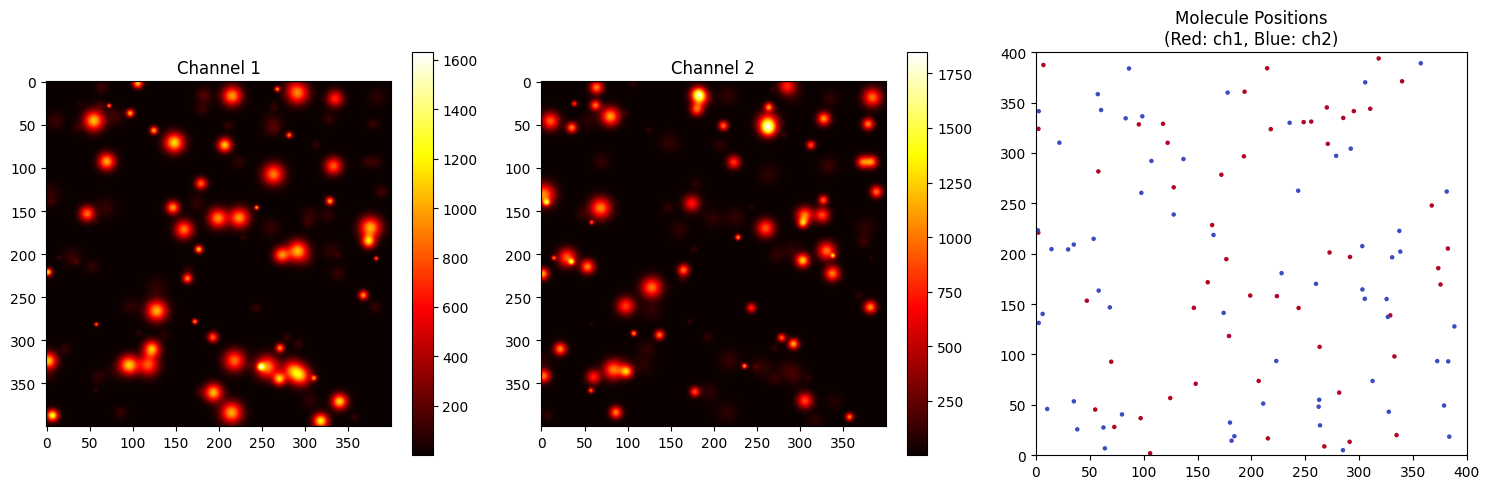

Generating dataset: 100%|██████████| 5/5 [00:26<00:00,  5.22s/it]


Dataset saved to ./dataset with 5 samples
数据集生成完成，保存在 ./dataset/dataset.npz


In [3]:
"""
generate_data.py - 只负责生成和保存数据集
"""

if __name__ == '__main__':
    # 配置参数
    DATA_CONFIG = {
        'image_size': 400,
        'pixel_size': 100,
        'psf_sigma': 1.5,
        'z_range': 0.02,
        'seed': 42,
        'cross_ratios': {'ch1_to_ch2':0.1, 'ch2_to_ch1':0.1},
        'color_prob': {'ch1':0.5, 'ch2':0.5},
        'intensity': {'ch1':{'mean':1000,'std':100}, 'ch2':{'mean':1000,'std':100}},
        'background': {'ch1':1, 'ch2':1},
        'num_molecules_range': [80,120]
    }

    # 确保dataset目录存在
    os.makedirs('./dataset', exist_ok=True)
    
    # 生成数据
    generator = RatiometricDataGenerator(DATA_CONFIG)
    generator.generate_dataset(num_samples=5, save_dir='./dataset')
    
    print("数据集生成完成，保存在 ./dataset/dataset.npz")

In [ ]:
"""
train.py - 只负责加载已有数据集并进行训练和评估
"""

if __name__ == '__main__':
    MODEL_CONFIG = {
        'base_ch': 32,
        'sig_pred': True,
        'lr': 1e-4,
        'weight_decay': 1e-5,
        'loss_weights': {'p':1.0, 'xyzi':2.0, 'color':1.5, 'sig':0.1}
    }

    # 初始化模型和训练器
    model = RatioAwareUNet(MODEL_CONFIG)
    trainer = Trainer(MODEL_CONFIG)  # 修改为直接传入配置
    
    # 加载已有数据集
    trainer.prepare_dataloaders('./dataset/dataset.npz')
    
    # 训练模型
    trainer.train(epochs=50)
    
    # 评估与可视化
    analyzer = ResultAnalyzer()
    sample = trainer.val_loader.dataset[0]
    with torch.no_grad():
        pred = model(sample['image'].unsqueeze(0).to(trainer.device))
        pred_df = ResultAnalyzer.postprocess(pred, sample['positions'])
        analyzer.visualize_sample(
            sample['image'].numpy(),
            pred_df,
            sample['positions']
        )

c:\Users\Alter\Desktop\Always Blue\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/50 [Train]:   0%|                    | 0/1 [00:00<?, ?it/s]

In [1]:
import torch
print("GPU可用:", torch.cuda.is_available())
print("当前显存占用:", torch.cuda.memory_allocated() / 1024**2, "MB")

GPU可用: False
当前显存占用: 0.0 MB


In [16]:
"""
ratimetric_analysis_system.py

改进后的完整系统，包含：
1. 数据生成时预计算所有Ground Truth映射
2. 修正的交叉比例计算逻辑
3. 优化的数据加载流程
"""

# -------------------- 模块1: 数据生成 --------------------
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from perlin_noise import PerlinNoise
from typing import Dict, Tuple

class RatiometricDataGenerator:
    def __init__(self, config: Dict):
        self.config = config
        self.image_size = config['image_size']
        self.pixel_size = config['pixel_size']  # nm/pixel
        self.psf_sigma = config['psf_sigma']  # PSF的sigma值（像素单位）
        
        # 通道参数
        self.channels = ['ch1', 'ch2']
        self.cross_ratios = {
            'ch1_to_ch2': config['cross_ratios']['ch1_to_ch2'],
            'ch2_to_ch1': config['cross_ratios']['ch2_to_ch1']
        }
        
        # 背景参数
        self.background_levels = {
            'ch1': config['background']['ch1'],
            'ch2': config['background']['ch2']
        }
        
        # 初始化Perlin噪声生成器
        self.noise_generator = PerlinNoise(octaves=4, seed=config['seed'])

    def generate_molecules(self, num_molecules: int) -> Dict:
        """生成分子属性（修正交叉比例计算）"""
        # 随机位置 (x, y, z)
        positions = np.random.rand(num_molecules, 3) * self.image_size
        positions[:, 2] = (positions[:, 2] * 2 - 1) * self.config['z_range']
        
        # 随机分配颜色标签
        colors = np.random.choice(['ch1', 'ch2'], num_molecules, 
                                p=[self.config['color_prob']['ch1'], 
                                   self.config['color_prob']['ch2']])
        
        # 初始化强度字典
        intensities = {'ch1': np.zeros(num_molecules), 'ch2': np.zeros(num_molecules)}
        
        # 逐个分子生成强度
        for i in range(num_molecules):
            color = colors[i]
            if color == 'ch1':
                mean = self.config['intensity']['ch1']['mean']
                std = self.config['intensity']['ch1']['std']
                main_intensity = np.abs(np.random.normal(mean, std))
                intensities['ch1'][i] = main_intensity
                intensities['ch2'][i] = main_intensity * self.cross_ratios['ch1_to_ch2']
            else:
                mean = self.config['intensity']['ch2']['mean']
                std = self.config['intensity']['ch2']['std']
                main_intensity = np.abs(np.random.normal(mean, std))
                intensities['ch2'][i] = main_intensity
                intensities['ch1'][i] = main_intensity * self.cross_ratios['ch2_to_ch1']
        
        return {
            'positions': positions,
            'intensities': intensities,
            'colors': colors
        }

    def _gaussian_psf(self, x, y, z, intensity):
        """生成高斯点扩散函数"""
        sigma = self.psf_sigma * (1 + 0.3 * np.abs(z))  # z-dependent PSF宽度
        size = int(7 * sigma)
        half_size = size // 2
        
        # 计算有效区域边界
        x_min = max(0, int(x) - half_size)
        x_max = min(self.image_size, int(x) + half_size + 1)
        y_min = max(0, int(y) - half_size)
        y_max = min(self.image_size, int(y) + half_size + 1)
        
        if x_min >= x_max or y_min >= y_max:
            return np.zeros((self.image_size, self.image_size))
        
        # 创建局部高斯分布
        xx, yy = np.meshgrid(np.arange(x_min, x_max), np.arange(y_min, y_max))
        psf = intensity * np.exp(-((xx - x)**2 + (yy - y)**2) / (2 * sigma**2))
        
        # 填充到全图
        full_psf = np.zeros((self.image_size, self.image_size))
        full_psf[y_min:y_max, x_min:x_max] = psf
        return full_psf
    
    def _generate_background(self, channel: str) -> np.ndarray:
        """生成背景噪声"""
        background = np.zeros((self.image_size, self.image_size))
        for i in range(self.image_size):
            for j in range(self.image_size):
                background[i,j] = self.noise_generator([i/self.image_size, j/self.image_size])
        
        # 缩放噪声强度
        bg_level = self.background_levels[channel]
        background = (background - background.min()) / (background.max() - background.min())
        return background * bg_level
    
    def _generate_ground_truth_maps(self, positions, colors, intensities, image_size):
        """生成Ground Truth映射"""
        p_map = np.zeros((1, image_size, image_size), dtype=np.float32)
        color_map = np.zeros_like(p_map)
        xyzi_map = np.zeros((4, image_size, image_size), dtype=np.float32)
        radius = 2
        
        # 生成高斯核模板
        xx, yy = np.meshgrid(np.arange(-radius, radius+1), 
                            np.arange(-radius, radius+1))
        gaussian_kernel = np.exp(-(xx**2 + yy**2)/(2*(radius/2)**2))
        
        for i in range(len(positions)):
            x, y, z = positions[i]
            xi = int(x.clip(0, image_size-1))
            yi = int(y.clip(0, image_size-1))
            
            # 生成概率热图
            x_min = max(0, xi - radius)
            x_max = min(image_size, xi + radius + 1)
            y_min = max(0, yi - radius)
            y_max = min(image_size, yi + radius + 1)
            
            if x_min < x_max and y_min < y_max:
                # 修正核裁剪方式
                kernel_x_start = radius - (xi - x_min)
                kernel_x_end = radius + (x_max - xi)
                kernel_y_start = radius - (yi - y_min)
                kernel_y_end = radius + (y_max - yi)
                
                kernel = gaussian_kernel[
                    kernel_y_start:kernel_y_end, 
                    kernel_x_start:kernel_x_end
                ]
                p_map[0, y_min:y_max, x_min:x_max] = np.maximum(
                    p_map[0, y_min:y_max, x_min:x_max], kernel)
            
            # 颜色标记
            color_map[0, yi, xi] = 1.0 if colors[i] == 'ch1' else 0.0
            
            # 坐标和强度
            xyzi_map[0, yi, xi] = x - xi  # x偏移
            xyzi_map[1, yi, xi] = y - yi  # y偏移
            xyzi_map[2, yi, xi] = z       # z位置
            xyzi_map[3, yi, xi] = intensities[i].sum()  # 总强度
        
        return p_map, color_map, xyzi_map
    
    def render_image(self, molecules: Dict) -> Tuple[np.ndarray, Dict]:
        """渲染双通道图像并生成所有映射"""
        ch1_image = np.zeros((self.image_size, self.image_size))
        ch2_image = np.zeros((self.image_size, self.image_size))
        
        # 渲染每个分子
        for i in range(len(molecules['positions'])):
            x, y, z = molecules['positions'][i]
            ch1_image += self._gaussian_psf(x, y, z, molecules['intensities']['ch1'][i])
            ch2_image += self._gaussian_psf(x, y, z, molecules['intensities']['ch2'][i])
        
        # 添加背景噪声
        ch1_image += self._generate_background('ch1')
        ch2_image += self._generate_background('ch2')
        
        # 合并为多通道图像
        combined_image = np.stack([ch1_image, ch2_image], axis=0)
        
        # 生成Ground Truth映射
        p_map, color_map, xyzi_map = self._generate_ground_truth_maps(
            molecules['positions'],
            molecules['colors'],
            np.stack([molecules['intensities']['ch1'], molecules['intensities']['ch2']], axis=1),
            self.image_size
        )
        
        return combined_image, {
            'positions': molecules['positions'],
            'intensities': np.stack([molecules['intensities']['ch1'], 
                                    molecules['intensities']['ch2']], axis=1),
            'colors': (molecules['colors'] == 'ch1').astype(int),
            'p_map': p_map,
            'color_map': color_map,
            'xyzi_map': xyzi_map
        }
    
    def generate_dataset(self, num_samples: int, save_dir: str):
        """生成完整数据集"""
        os.makedirs(save_dir, exist_ok=True)
        
        all_images = []
        all_gt = []
        
        for i in tqdm(range(num_samples), desc="Generating dataset"):
            num_molecules = np.random.randint(
                self.config['num_molecules_range'][0],
                self.config['num_molecules_range'][1]
            )
            
            molecules = self.generate_molecules(num_molecules)
            image, gt = self.render_image(molecules)
            
            if i == 0:
                self.visualize_sample(image, gt)
            
            all_images.append(image)
            all_gt.append(gt)
        
        # 转换为numpy数组
        np.savez_compressed(
            os.path.join(save_dir, 'dataset.npz'),
            images=np.array(all_images, dtype=np.float32),
            positions=np.array([gt['positions'] for gt in all_gt], dtype=object),
            intensities=np.array([gt['intensities'] for gt in all_gt], dtype=object),
            colors=np.array([gt['colors'] for gt in all_gt], dtype=object),
            p_maps=np.array([gt['p_map'] for gt in all_gt], dtype=np.float32),
            color_maps=np.array([gt['color_map'] for gt in all_gt], dtype=np.float32),
            xyzi_maps=np.array([gt['xyzi_map'] for gt in all_gt], dtype=np.float32)
        )
        print(f"Dataset saved to {save_dir}")

    def visualize_sample(self, image: np.ndarray, gt: Dict):
        """可视化样本"""
        plt.figure(figsize=(18, 6))
        
        # 显示输入图像
        plt.subplot(2, 2, 1)
        plt.imshow(image[0], cmap='hot')
        plt.title('Channel 1')
        plt.colorbar()
        
        plt.subplot(2, 2, 2)
        plt.imshow(image[1], cmap='hot')
        plt.title('Channel 2')
        plt.colorbar()
        
        # 显示Ground Truth映射
        plt.subplot(2, 2, 3)
        plt.imshow(gt['p_map'][0], cmap='hot')
        plt.title('Probability Map')
        
        plt.subplot(2, 2, 4, aspect='equal')
        plt.scatter(gt['positions'][:,0], gt['positions'][:,1], 
                   c=gt['colors'], cmap='coolwarm', s=5)
        plt.title('Molecule Positions')
        plt.gca().invert_yaxis()
        
        plt.tight_layout()
        plt.show()

# -------------------- 模块2: 神经网络 --------------------
import torch
import torch.nn as nn
import torch.nn.functional as F

class EncoderBlock(nn.Module):
    def __init__(self, in_ch, base_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, base_ch, 3, padding=1),
            nn.BatchNorm2d(base_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_ch, base_ch*2, 3, padding=1),
            nn.BatchNorm2d(base_ch*2),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.MaxPool2d(2)
    
    def forward(self, x):
        x = self.pool(x)
        return self.conv(x)

class RatioAwareUNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # 修改编码器输出通道数
        self.encoder_ch1 = nn.Sequential(
            EncoderBlock(1, config['base_ch']),  # 输出通道: base_ch*2
            EncoderBlock(config['base_ch']*2, config['base_ch'])  # 输出通道: base_ch*2
        )
        self.encoder_ch2 = nn.Sequential(
            EncoderBlock(1, config['base_ch']),
            EncoderBlock(config['base_ch']*2, config['base_ch'])
        )
        
        # 修改比例特征提取层
        self.ratio_conv = nn.Sequential(
            nn.Conv2d(2, config['base_ch'], 3, padding=1),  # 增大输出通道
            nn.ReLU(),
            nn.Conv2d(config['base_ch'], config['base_ch'], 3, padding=1),
            nn.ReLU()
        )
        
        # 修改解码器输入通道数
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True),
            # 注意这里的输入通道数计算：
            # encoder_ch1输出: base_ch*2
            # encoder_ch2输出: base_ch*2 
            # ratio_conv输出: base_ch
            # 总和: base_ch*5
            nn.Conv2d(config['base_ch']*5, config['base_ch'], 3, padding=1),
            nn.BatchNorm2d(config['base_ch']),
            nn.ReLU(inplace=True),
            nn.Conv2d(config['base_ch'], config['base_ch'], 3, padding=1),
            nn.BatchNorm2d(config['base_ch']),
            nn.ReLU(inplace=True)
        )
        
        # 输出头
        self.output_head = nn.ModuleDict({
            'xyzi': nn.Conv2d(config['base_ch'], 4, 3, padding=1),
            'p': nn.Conv2d(config['base_ch'], 1, 3, padding=1),
            'color': nn.Sequential(
                nn.Conv2d(config['base_ch'], config['base_ch']//2, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(config['base_ch']//2, 1, 1),
                nn.Sigmoid()
            )
        })
        
        if config['sig_pred']:
            self.output_head['sig'] = nn.Conv2d(config['base_ch'], 4, 3, padding=1)

    def forward(self, x):
        ch1, ch2 = x[:, 0:1], x[:, 1:2]
        
        # 编码特征
        feats_ch1 = self.encoder_ch1(ch1)
        feats_ch2 = self.encoder_ch2(ch2)
        
        # 比例特征
        with torch.no_grad():
            total = ch1 + ch2 + 1e-6
            ratios = torch.cat([ch1/total, ch2/total], dim=1)
        ratio_feats = self.ratio_conv(ratios)
        ratio_feats = F.avg_pool2d(ratio_feats, 4)
        
        # 特征融合
        combined = torch.cat([feats_ch1, feats_ch2, ratio_feats], dim=1)
        
        # 解码
        decoded = self.decoder(combined)
        
        # 输出
        outputs = {
            'xyzi': torch.sigmoid(self.output_head['xyzi'](decoded)),
            'p': torch.sigmoid(self.output_head['p'](decoded)),
            'color_prob': self.output_head['color'](decoded)
        }
        
        if 'sig' in self.output_head:
            outputs['xyzi_sig'] = F.softplus(self.output_head['sig'](decoded))
        
        return outputs

# -------------------- 模块3: 数据加载 --------------------
from torch.utils.data import Dataset, DataLoader

class RatiometricDataset(Dataset):
    def __init__(self, npz_path):
        data = np.load(npz_path, allow_pickle=True)
        self.images = data['images']
        self.p_maps = data['p_maps']
        self.color_maps = data['color_maps']
        self.xyzi_maps = data['xyzi_maps']
        self.positions = data['positions']
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return {
            'image': torch.from_numpy(self.images[idx].copy()),
            'p_map': torch.from_numpy(self.p_maps[idx].copy()),
            'color_map': torch.from_numpy(self.color_maps[idx].copy()),
            'xyzi': torch.from_numpy(self.xyzi_maps[idx].copy()),
            'positions': self.positions[idx]
        }

def collate_fn(batch):
    """处理变长位置数据的collate函数"""
    return {
        'image': torch.stack([item['image'] for item in batch]),
        'p_map': torch.stack([item['p_map'] for item in batch]),
        'color_map': torch.stack([item['color_map'] for item in batch]),
        'xyzi': torch.stack([item['xyzi'] for item in batch]),
        'positions': [item['positions'] for item in batch]  # 如果后续需要用到positions
    }

# -------------------- 模块4: 训练框架 --------------------
class Trainer:
    def __init__(self, config):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # 初始化模型
        self.model = RatioAwareUNet(config).to(self.device)
        
        # 优化器
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=config['lr'],
            weight_decay=config['weight_decay']
        )
        
        # 学习率调度
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.5,
            patience=5,
            verbose=True
        )
        
        # 损失函数
        self.loss_fn = self._get_loss_fn()
        
        # 记录器
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'precision': [],
            'recall': []
        }
    
    def _get_loss_fn(self):
        def loss_func(pred, target):
            # 存在概率损失
            p_loss = F.binary_cross_entropy(pred['p'], target['p_map'])
            
            # 坐标损失 (只在分子位置计算)
            mask = (target['p_map'] > 0.5).float()  # [B,1,H,W]
            
            # 扩展mask以匹配xyzi的通道数 [B,1,H,W] -> [B,4,H,W]
            expanded_mask = mask.repeat(1, 4, 1, 1)
            
            if mask.sum() > 0:
                # 使用扩展后的mask计算损失
                xyzi_loss = F.mse_loss(
                    pred['xyzi'] * expanded_mask, 
                    target['xyzi'] * expanded_mask
                ) / (expanded_mask.sum() + 1e-6)  # 归一化
            else:
                xyzi_loss = torch.tensor(0.0).to(self.device)
            
            # 颜色分类损失 (使用原始单通道mask)
            if mask.sum() > 0:
                color_loss = F.binary_cross_entropy(
                    pred['color_prob'] * mask,
                    target['color_map'] * mask
                ) / (mask.sum() + 1e-6)  # 归一化
            else:
                color_loss = torch.tensor(0.0).to(self.device)
            
            # 总损失
            total_loss = (
                self.config['loss_weights']['p'] * p_loss +
                self.config['loss_weights']['xyzi'] * xyzi_loss +
                self.config['loss_weights']['color'] * color_loss
            )
            
            # 如果预测不确定性
            if 'xyzi_sig' in pred and mask.sum() > 0:
                sig_loss = F.mse_loss(
                    pred['xyzi_sig'] * expanded_mask, 
                    torch.zeros_like(pred['xyzi_sig']) * expanded_mask
                ) / (expanded_mask.sum() + 1e-6)
                total_loss += self.config['loss_weights']['sig'] * sig_loss
            
            return total_loss, {
                'p_loss': p_loss.item(),
                'xyzi_loss': xyzi_loss.item() if mask.sum() > 0 else 0.0,
                'color_loss': color_loss.item() if mask.sum() > 0 else 0.0
            }
        
        return loss_func

    def prepare_dataloaders(self, npz_path, batch_size=4, test_size=0.2, num_workers=0):
        """修正后的数据加载方法，增加num_workers参数"""
        print("\n=== 准备数据加载器 ===")
        
        full_dataset = RatiometricDataset(npz_path)
        print(f"数据集加载完成，总样本数: {len(full_dataset)}")
        
        train_size = int((1 - test_size) * len(full_dataset))
        self.train_loader = DataLoader(
            torch.utils.data.Subset(full_dataset, range(train_size)),
            batch_size=batch_size,
            shuffle=True,
            collate_fn=collate_fn,
            num_workers=num_workers  # 使用传入的参数
        )
        self.val_loader = DataLoader(
            torch.utils.data.Subset(full_dataset, range(train_size, len(full_dataset))),
            batch_size=batch_size,
            shuffle=False,
            collate_fn=collate_fn,
            num_workers=num_workers  # 使用传入的参数
        )
        
        print(f"训练集batch数: {len(self.train_loader)} | 验证集batch数: {len(self.val_loader)}")
        print("=== 数据加载完成 ===")
        return self
    
    def train(self, epochs):
        """完整的训练流程，包含以下功能：
        1. 训练和验证循环
        2. 学习率调度
        3. 模型保存
        4. 实时指标显示
        5. 进度条可视化
        """
        best_val_loss = float('inf')
        train_history = {'loss': [], 'val_loss': []}
        
        # 训练循环
        for epoch in range(epochs):
            # -------------------- 训练阶段 --------------------
            self.model.train()
            epoch_loss = 0
            progress_bar = tqdm(self.train_loader, 
                            desc=f'Epoch {epoch+1}/{epochs} [Train]',
                            bar_format='{l_bar}{bar:20}{r_bar}')
            
            for batch in progress_bar:
                # 数据转移到设备
                images = batch['image'].to(self.device)
                targets = {
                    'p_map': batch['p_map'].to(self.device),
                    'color_map': batch['color_map'].to(self.device),
                    'xyzi': batch['xyzi'].to(self.device)
                }
                
                # 前向传播
                self.optimizer.zero_grad()
                outputs = self.model(images)
                
                # 计算损失
                loss, loss_dict = self.loss_fn(outputs, targets)
                
                # 反向传播
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optimizer.step()
                
                # 记录和显示
                epoch_loss += loss.item()
                progress_bar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'p_loss': f"{loss_dict['p_loss']:.4f}",
                    'xyzi_loss': f"{loss_dict['xyzi_loss']:.4f}",
                    'lr': f"{self.optimizer.param_groups[0]['lr']:.2e}"
                })
            
            # 计算平均训练损失
            avg_train_loss = epoch_loss / len(self.train_loader)
            train_history['loss'].append(avg_train_loss)
            
            # -------------------- 验证阶段 --------------------
            self.model.eval()
            val_loss = 0
            val_samples = 0
            val_progress = tqdm(self.val_loader, 
                            desc=f'Epoch {epoch+1}/{epochs} [Val]',
                            bar_format='{l_bar}{bar:20}{r_bar}')
            
            with torch.no_grad():
                for batch in val_progress:
                    images = batch['image'].to(self.device)
                    targets = {
                        'p_map': batch['p_map'].to(self.device),
                        'color_map': batch['color_map'].to(self.device),
                        'xyzi': batch['xyzi'].to(self.device)
                    }
                    
                    outputs = self.model(images)
                    loss, _ = self.loss_fn(outputs, targets)
                    
                    val_loss += loss.item() * images.size(0)
                    val_samples += images.size(0)
                    
                    val_progress.set_postfix({
                        'val_loss': f"{loss.item():.4f}"
                    })
            
            # 计算平均验证损失
            avg_val_loss = val_loss / val_samples
            train_history['val_loss'].append(avg_val_loss)
            
            # -------------------- 学习率调度 --------------------
            self.scheduler.step(avg_val_loss)
            
            # -------------------- 模型保存 --------------------
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'loss': best_val_loss,
                }, 'best_model.pth')
                print(f"\nSaved best model with val_loss: {best_val_loss:.4f}")
            
            # -------------------- 打印epoch总结 --------------------
            print(f"\nEpoch {epoch+1} Summary:")
            print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
            print(f"Learning Rate: {self.optimizer.param_groups[0]['lr']:.2e}")
            
            # 每5个epoch可视化一次样本结果
            if (epoch + 1) % 5 == 0:
                self._visualize_sample_results()
        
        # 训练结束保存最终模型
        torch.save({
            'epoch': epochs,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss': avg_val_loss,
        }, 'final_model.pth')
        
        # 绘制训练曲线
        self._plot_training_curve(train_history)
        return train_history

    def _visualize_sample_results(self):
        """使用增强的可视化方法显示双通道结果"""
        self.model.eval()
        sample = next(iter(self.val_loader))
        
        with torch.no_grad():
            images = sample['image'].to(self.device)
            outputs = self.model(images)
            
            # 处理第一个样本
            pred_df = ResultAnalyzer.postprocess(
                {k: v[0].unsqueeze(0).cpu() for k, v in outputs.items()},
                sample['positions'][0].numpy() if hasattr(sample['positions'][0], 'numpy') else sample['positions'][0]
            )
            
            # 使用增强的可视化方法
            ResultAnalyzer.visualize_detection_results(
                sample['image'][0].numpy(),
                pred_df,
                sample['positions'][0].numpy() if hasattr(sample['positions'][0], 'numpy') else sample['positions'][0]
            )
            
            # 显示分类性能
            ResultAnalyzer.plot_color_classification_accuracy(
                pred_df,
                sample['positions'][0].numpy() if hasattr(sample['positions'][0], 'numpy') else sample['positions'][0]
            )

    def _plot_training_curve(self, history):
        """绘制训练和验证损失曲线"""
        plt.figure(figsize=(10,5))
        plt.plot(history['loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True)
        plt.savefig('training_curve.png')
        plt.close()

# -------------------- 模块5: 评估与可视化 --------------------
from skimage.feature import peak_local_max

class ResultAnalyzer:
    @staticmethod
    def postprocess(model_output, gt_positions=None, threshold=0.5):
        """
        处理模型输出，转换为DataFrame格式
        参数:
            model_output: 模型输出字典
            gt_positions: 真实位置 (可选)
            threshold: 概率阈值
        返回:
            pandas.DataFrame 包含检测结果
        """
        # 获取概率图并找到局部极大值点
        p_map = model_output['p'][0,0].cpu().numpy()
        coords = peak_local_max(p_map, min_distance=3, threshold_abs=threshold)
        
        # 提取预测信息
        results = []
        for y, x in coords:
            # 获取偏移量和z坐标
            dx = model_output['xyzi'][0,0,y,x].item()
            dy = model_output['xyzi'][0,1,y,x].item()
            z = model_output['xyzi'][0,2,y,x].item()
            
            # 计算绝对坐标
            abs_x = x + dx
            abs_y = y + dy
            
            # 获取颜色概率
            color_prob = model_output['color_prob'][0,0,y,x].item()
            color = 1 if color_prob > 0.5 else 0
            
            # 获取两个通道的预测强度
            ch1_intensity = model_output['xyzi'][0,3,y,x].item() * (1 - color_prob)
            ch2_intensity = model_output['xyzi'][0,3,y,x].item() * color_prob
            
            results.append({
                'x': abs_x,
                'y': abs_y,
                'z': z,
                'p': p_map[y,x],
                'color': color,
                'color_prob': color_prob,
                'ch1_intensity': ch1_intensity,
                'ch2_intensity': ch2_intensity
            })
        
        # 创建DataFrame
        import pandas as pd
        df = pd.DataFrame(results)
        
        return df

    @staticmethod
    def visualize_detection_results(image, pred_df, gt_positions=None):
        """增强的可视化函数，显示双通道信息和分类结果"""
        plt.figure(figsize=(20, 6))
        
        # 显示双通道输入图像
        plt.subplot(1, 4, 1)
        plt.imshow(image[0], cmap='cool', alpha=0.7)
        plt.imshow(image[1], cmap='Purples', alpha=0.7)
        plt.title('Dual Channel Input')
        
        # 显示预测结果（带颜色分类）
        plt.subplot(1, 4, 2)
        if not pred_df.empty:
            plt.scatter(pred_df['x'], pred_df['y'], 
                       c=pred_df['color_prob'], 
                       cmap='coolwarm', 
                       s=50, 
                       vmin=0, vmax=1,
                       alpha=0.7)
            plt.colorbar(label='Channel 2 Probability')
            plt.title('Predictions with Color Classification')
        
        # 显示通道强度分布
        plt.subplot(1, 4, 3)
        if not pred_df.empty:
            width = 0.4
            indices = np.arange(len(pred_df))
            plt.bar(indices - width/2, pred_df['ch1_intensity'], 
                    width, label='Channel 1', color='magenta', alpha=0.7)
            plt.bar(indices + width/2, pred_df['ch2_intensity'], 
                    width, label='Channel 2', color='green', alpha=0.7)
            plt.legend()
            plt.title('Channel Intensity Distribution')
            plt.xlabel('Bead Index')
            plt.ylabel('Intensity')
        
        # 显示真实位置与预测对比
        plt.subplot(1, 4, 4)
        if gt_positions is not None:
            # 假设gt_positions包含颜色信息 (0=ch1, 1=ch2)
            gt_colors = gt_positions[:,3] if gt_positions.shape[1] > 3 else np.zeros(len(gt_positions))
            plt.scatter(gt_positions[:,0], gt_positions[:,1], 
                       c=gt_colors, cmap='coolwarm', 
                       s=50, marker='s', label='Ground Truth',
                       alpha=0.7)
            
            if not pred_df.empty:
                plt.scatter(pred_df['x'], pred_df['y'], 
                           c=pred_df['color'], cmap='coolwarm',
                           s=20, marker='o', label='Predictions',
                           alpha=0.7)
            plt.legend()
            plt.title('Detection Comparison')
        
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_color_classification_accuracy(pred_df, gt_positions):
        """绘制颜色分类准确率"""
        if gt_positions is None or len(pred_df) == 0:
            return
            
        # 匹配预测和真实位置 (简单最近邻匹配)
        from scipy.spatial import distance_matrix
        gt_points = gt_positions[:,:2]
        pred_points = pred_df[['x','y']].values
        dists = distance_matrix(gt_points, pred_points)
        matches = np.argmin(dists, axis=1)
        
        # 收集匹配结果
        correct = 0
        total = 0
        conf_matrix = np.zeros((2,2))  # [true, pred]
        
        for i, match_idx in enumerate(matches):
            if dists[i, match_idx] < 3:  # 匹配阈值
                # 确保颜色值是整数
                true_color = int(gt_positions[i,3]) if gt_positions.shape[1] > 3 else 0
                pred_color = int(pred_df.iloc[match_idx]['color'])
                conf_matrix[int(true_color), int(pred_color)] += 1  # 显式转换为整数
                if true_color == pred_color:
                    correct += 1
                total += 1
        
        if total > 0:
            # 绘制混淆矩阵
            plt.figure(figsize=(12,5))
            plt.subplot(1,2,1)
            plt.imshow(conf_matrix, cmap='Blues')
            for i in range(2):
                for j in range(2):
                    plt.text(j, i, int(conf_matrix[i,j]), 
                            ha='center', va='center', color='red')
            plt.xticks([0,1], ['Pred Ch1', 'Pred Ch2'])
            plt.yticks([0,1], ['True Ch1', 'True Ch2'])
            plt.title(f'Confusion Matrix (Acc: {correct/total:.2f}')
            
            # 绘制分类概率分布
            plt.subplot(1,2,2)
            for color in [0,1]:
                subset = pred_df[pred_df['color'] == color]
                if len(subset) > 0:
                    plt.hist(subset['color_prob'], 
                            bins=20, 
                            alpha=0.7,
                            label=f'Classified as Ch{color+1}',
                            range=(0,1))
            plt.xlabel('Channel 2 Probability')
            plt.ylabel('Count')
            plt.legend()
            plt.title('Classification Probability Distribution')
            
            plt.tight_layout()
            plt.show()

=== 开始数据生成 ===
配置参数:
image_size: 256
pixel_size: 100
psf_sigma: 1.5
z_range: 0.025
seed: 42
cross_ratios: {'ch1_to_ch2': 0.3, 'ch2_to_ch1': 0.3}
color_prob: {'ch1': 0.5, 'ch2': 0.5}
intensity: {'ch1': {'mean': 800, 'std': 150}, 'ch2': {'mean': 1000, 'std': 200}}
background: {'ch1': 10, 'ch2': 5}
num_molecules_range: [20, 40]


Generating dataset:   0%|          | 0/100 [00:00<?, ?it/s]

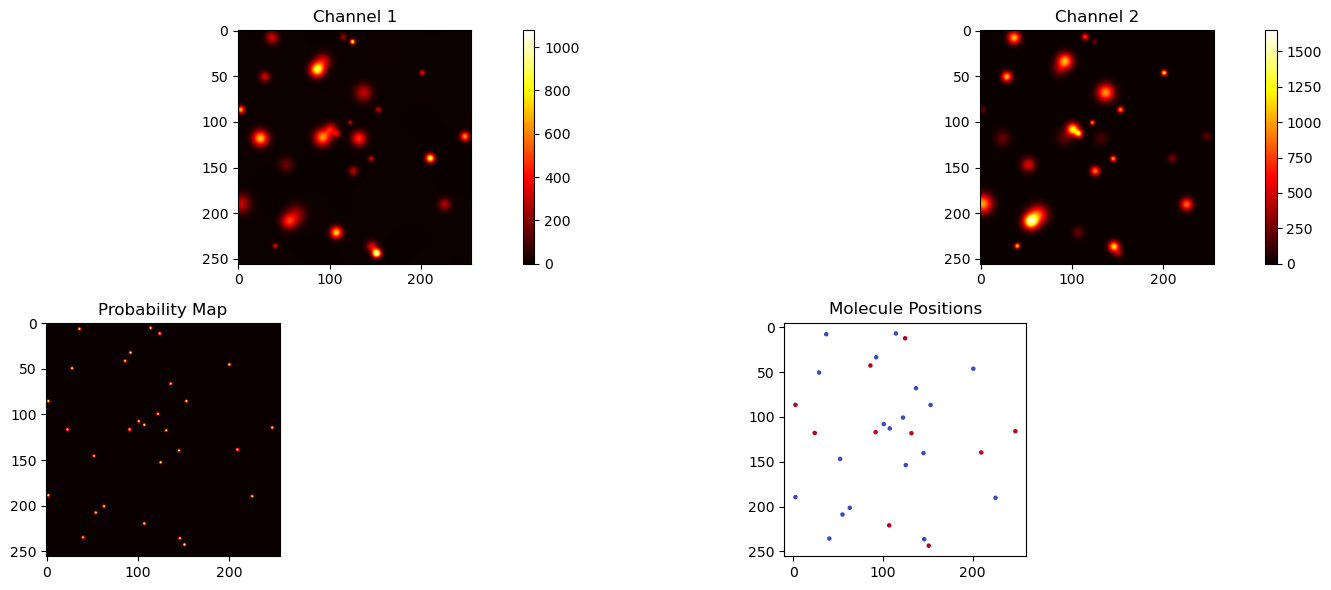

Generating dataset: 100%|██████████| 100/100 [03:21<00:00,  2.02s/it]


Dataset saved to ./dataset

数据集生成完成，保存在 ./dataset/dataset.npz
图像尺寸: 256x256
样本数量: 1000


In [17]:
"""
generate_data.py - 只负责生成和保存数据集
"""
import os

if __name__ == '__main__':
    # 配置参数 (优化后的参数)
    DATA_CONFIG = {
        'image_size': 256,          # 减小图像尺寸以加快生成速度
        'pixel_size': 100,          # nm/pixel
        'psf_sigma': 1.5,           # PSF sigma值
        'z_range': 0.025,             # z轴范围(微米)
        'seed': 42,                 # 随机种子
        
        # 分子参数
        'cross_ratios': {
            'ch1_to_ch2': 0.3,     # 通道1到通道2的交叉比例
            'ch2_to_ch1': 0.3       # 通道2到通道1的交叉比例
        },
        'color_prob': {
            'ch1': 0.5,             # 通道1分子概率
            'ch2': 0.5              # 通道2分子概率
        },
        'intensity': {
            'ch1': {'mean': 800, 'std': 150},  # 通道1强度分布
            'ch2': {'mean': 1000, 'std': 200}   # 通道2强度分布
        },
        
        # 背景参数
        'background': {
            'ch1': 10,              # 通道1背景水平
            'ch2': 5               # 通道2背景水平
        },
        
        # 分子数量范围
        'num_molecules_range': [20, 40]  # 每帧分子数量范围
    }

    # 确保dataset目录存在
    os.makedirs('./dataset', exist_ok=True)
    
    print("=== 开始数据生成 ===")
    print("配置参数:")
    for k, v in DATA_CONFIG.items():
        print(f"{k}: {v}")
    
    # 生成数据 (增加样本数量)
    generator = RatiometricDataGenerator(DATA_CONFIG)
    generator.generate_dataset(num_samples=100, save_dir='./dataset')
    
    print("\n数据集生成完成，保存在 ./dataset/dataset.npz")
    print(f"图像尺寸: {DATA_CONFIG['image_size']}x{DATA_CONFIG['image_size']}")
    print(f"样本数量: 1000")

In [ ]:
"""
train.py - 只负责加载已有数据集并进行训练和评估
"""
if __name__ == '__main__':
    # 模型配置 (优化后的参数)
    MODEL_CONFIG = {
        'base_ch': 32,              # 基础通道数
        'sig_pred': True,            # 启用不确定性预测
        'lr': 3e-4,                 # 学习率
        'weight_decay': 1e-5,        # 权重衰减
        'batch_size': 16,            # 批次大小
        'loss_weights': {
            'p': 1.0,               # 存在概率权重
            'xyzi': 5.0,            # 坐标和强度权重(提高)
            'color': 2.0,           # 颜色分类权重(提高)
            'sig': 0.2              # 不确定性权重
        }
    }

    print("=== 开始训练 ===")
    print("模型配置:")
    for k, v in MODEL_CONFIG.items():
        print(f"{k}: {v}")

    # 初始化训练器
    trainer = Trainer(MODEL_CONFIG)
    
    # 加载已有数据集 (增加数据加载进度显示)
    print("\n=== 加载数据集 ===")
    trainer.prepare_dataloaders(
        './dataset/dataset.npz',
        batch_size=MODEL_CONFIG['batch_size'],
        num_workers=4  # 使用多线程加载数据
    )
    
    # 训练模型 (增加epoch进度显示)
    print("\n=== 开始模型训练 ===")
    trainer.train(epochs=50)
    
    # 评估与可视化
    print("\n=== 评估模型 ===")
    analyzer = ResultAnalyzer()
    
    # 获取验证集样本
    val_loader = trainer.val_loader
    sample = val_loader.dataset[0]
    
    # 使用最佳模型进行预测
    with torch.no_grad():
        # 将样本数据转移到设备
        inputs = sample['image'].unsqueeze(0).to(trainer.device)
        
        # 进行预测
        pred = trainer.model(inputs)
        
        # 后处理结果
        pred_df = ResultAnalyzer.postprocess(
            pred,
            sample['positions']
        )
        
        # 可视化结果
        analyzer.visualize_detection_results(
            sample['image'].numpy(),
            pred_df,
            sample['positions']
        )
        
        # 显示分类性能
        analyzer.plot_color_classification_accuracy(
            pred_df,
            sample['positions']
        )
    
    print("\n=== 训练完成 ===")

=== 开始训练 ===
模型配置:
base_ch: 32
sig_pred: True
lr: 0.0003
weight_decay: 1e-05
batch_size: 16
loss_weights: {'p': 1.0, 'xyzi': 5.0, 'color': 2.0, 'sig': 0.2}


e:\Conda\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== 加载数据集 ===

=== 准备数据加载器 ===
数据集加载完成，总样本数: 100
训练集batch数: 5 | 验证集batch数: 2
=== 数据加载完成 ===

=== 开始模型训练 ===


Epoch 1/50 [Train]:   0%|                    | 0/5 [00:00<?, ?it/s]

Using device: cuda

=== 准备数据加载器 ===


e:\Conda\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


数据集加载完成，总样本数: 100
训练集batch数: 20 | 验证集batch数: 5
=== 数据加载完成 ===

Starting training...


Epoch 1/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 20.92it/s, val_loss=0.7227]



Saved best model with val_loss: 0.7199

Epoch 1 Summary:
Train Loss: 0.7308 | Val Loss: 0.7199
Learning Rate: 1.00e-04


Epoch 2/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 19.00it/s, val_loss=0.5802]



Saved best model with val_loss: 0.5793

Epoch 2 Summary:
Train Loss: 0.5906 | Val Loss: 0.5793
Learning Rate: 1.00e-04


Epoch 3/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 21.11it/s, val_loss=0.4766]



Saved best model with val_loss: 0.4755

Epoch 3 Summary:
Train Loss: 0.4987 | Val Loss: 0.4755
Learning Rate: 1.00e-04


Epoch 4/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 20.89it/s, val_loss=0.4146]



Saved best model with val_loss: 0.4127

Epoch 4 Summary:
Train Loss: 0.4294 | Val Loss: 0.4127
Learning Rate: 1.00e-04


Epoch 5/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 21.01it/s, val_loss=0.3625]



Saved best model with val_loss: 0.3603

Epoch 5 Summary:
Train Loss: 0.3731 | Val Loss: 0.3603
Learning Rate: 1.00e-04


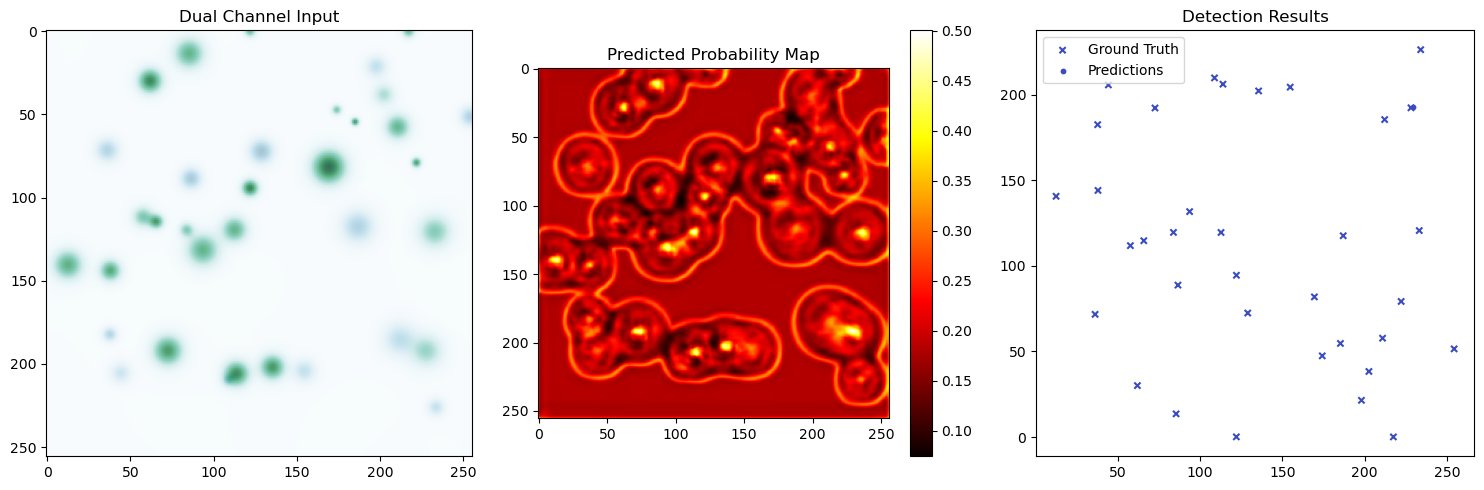

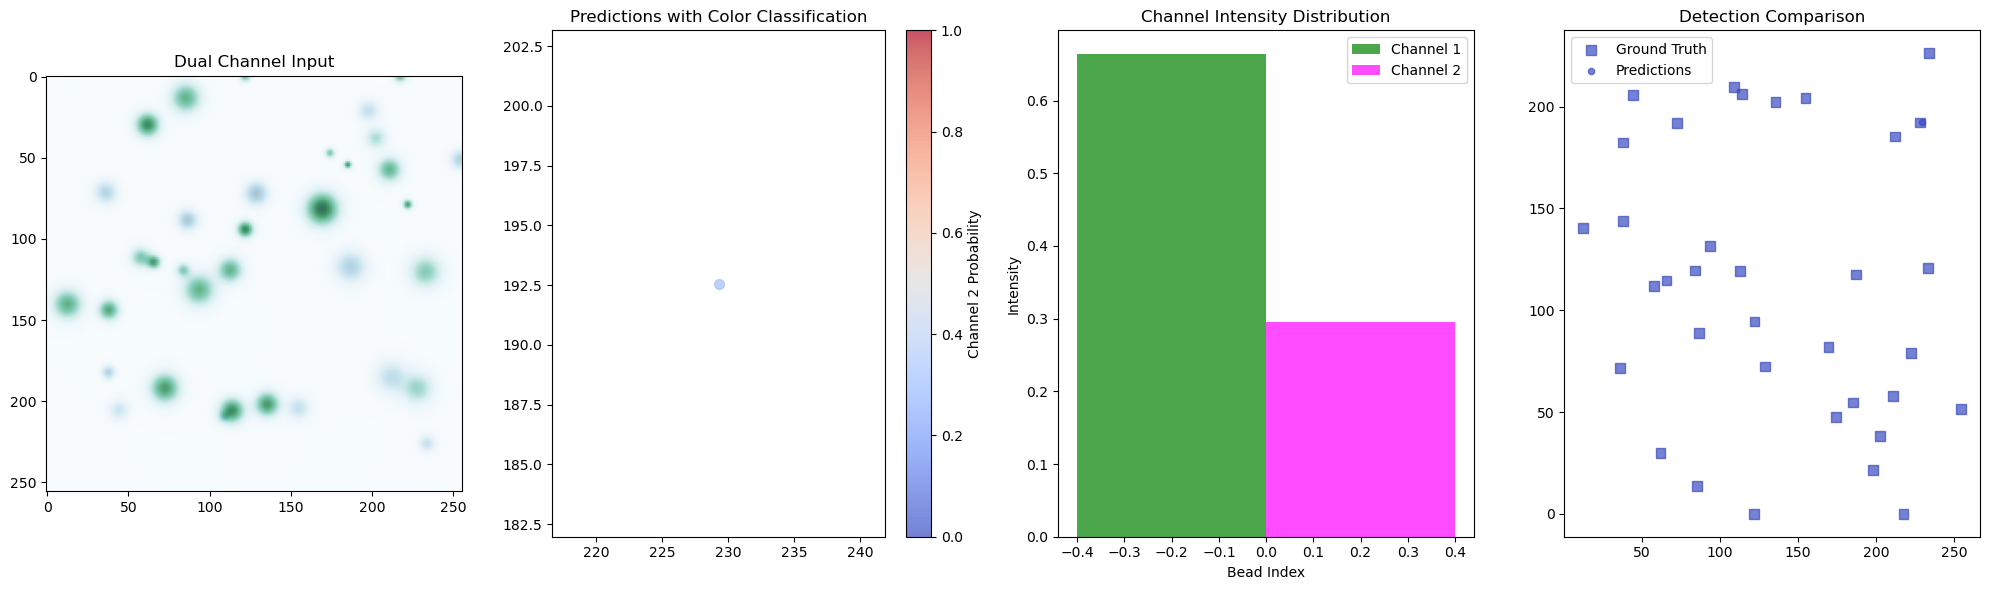

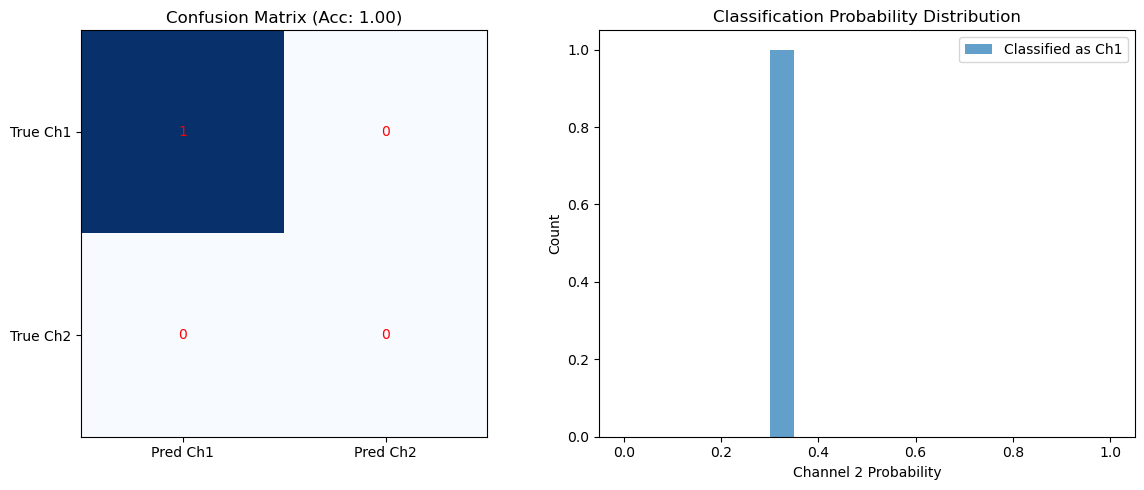

Epoch 6/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 21.15it/s, val_loss=0.3202]



Saved best model with val_loss: 0.3178

Epoch 6 Summary:
Train Loss: 0.3265 | Val Loss: 0.3178
Learning Rate: 1.00e-04


Epoch 7/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 21.03it/s, val_loss=0.2815]



Saved best model with val_loss: 0.2792

Epoch 7 Summary:
Train Loss: 0.2890 | Val Loss: 0.2792
Learning Rate: 1.00e-04


Epoch 8/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 21.21it/s, val_loss=0.2560]



Saved best model with val_loss: 0.2536

Epoch 8 Summary:
Train Loss: 0.2590 | Val Loss: 0.2536
Learning Rate: 1.00e-04


Epoch 9/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 21.54it/s, val_loss=0.2394]



Saved best model with val_loss: 0.2369

Epoch 9 Summary:
Train Loss: 0.2363 | Val Loss: 0.2369
Learning Rate: 1.00e-04


Epoch 10/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 20.94it/s, val_loss=0.2211]



Saved best model with val_loss: 0.2186

Epoch 10 Summary:
Train Loss: 0.2181 | Val Loss: 0.2186
Learning Rate: 1.00e-04


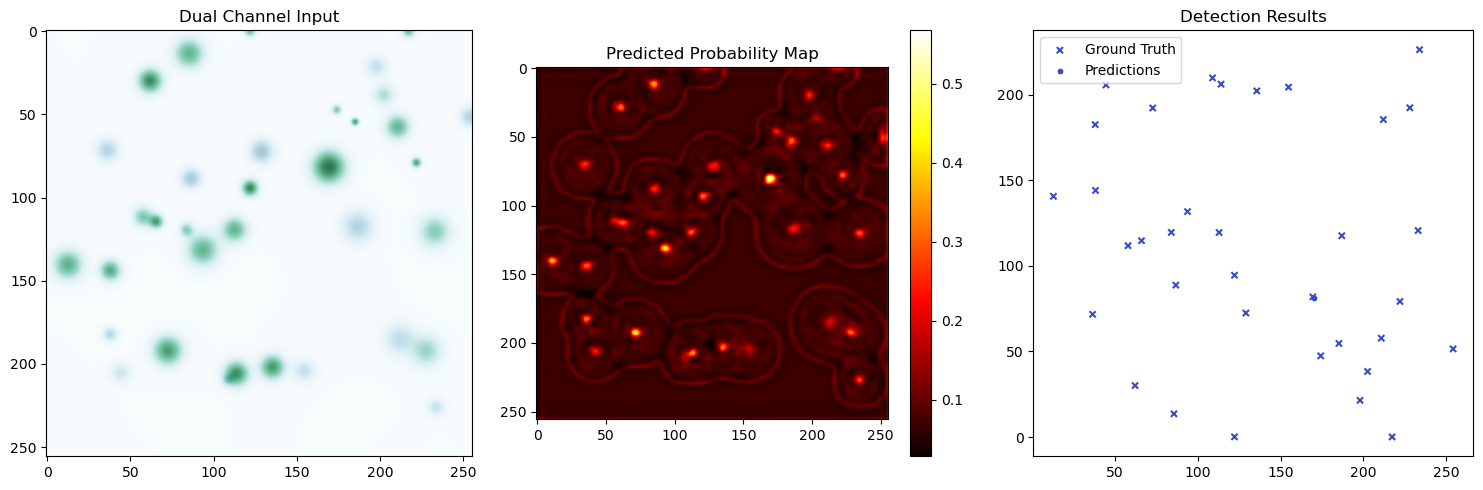

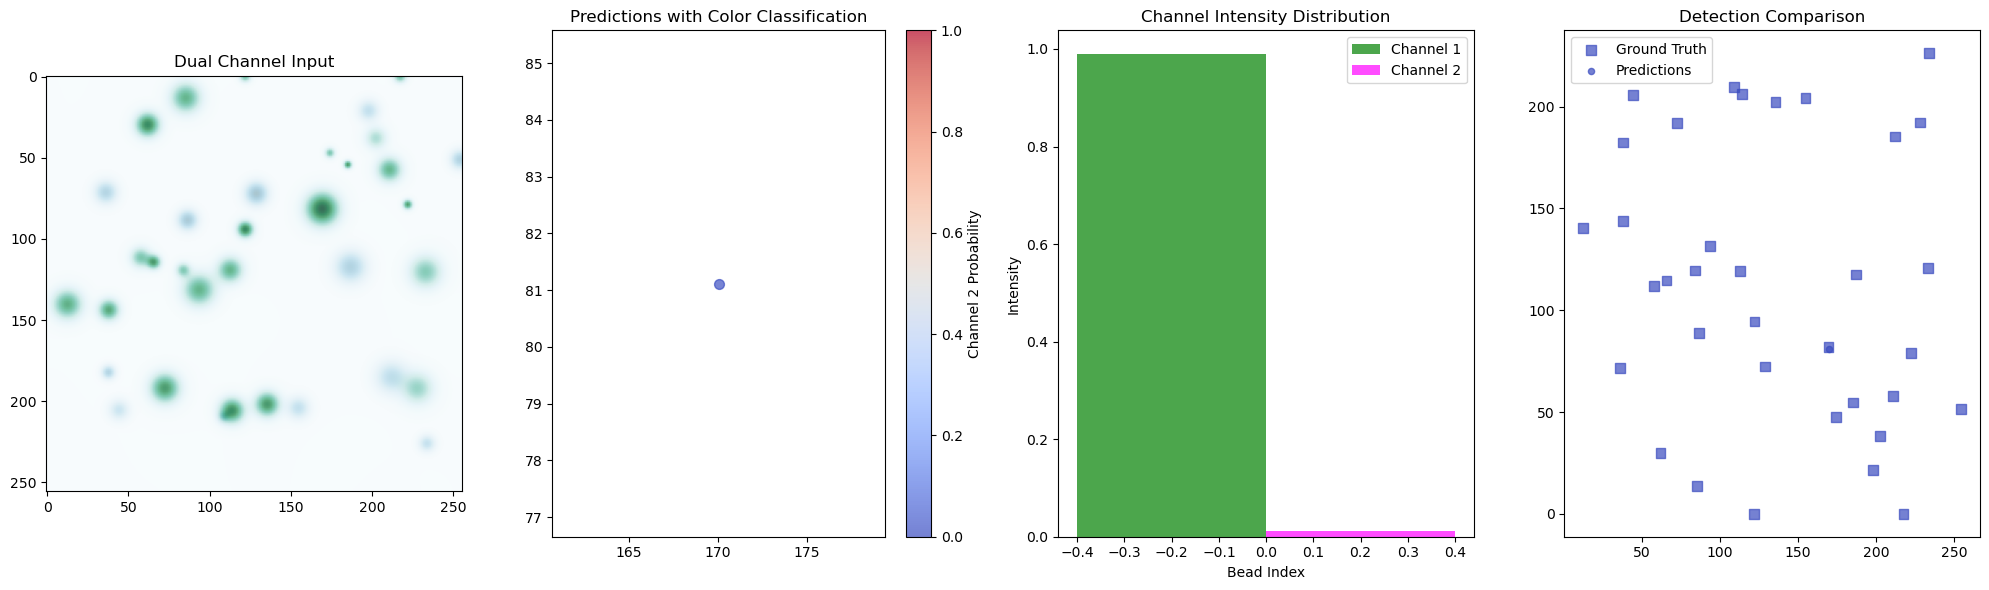

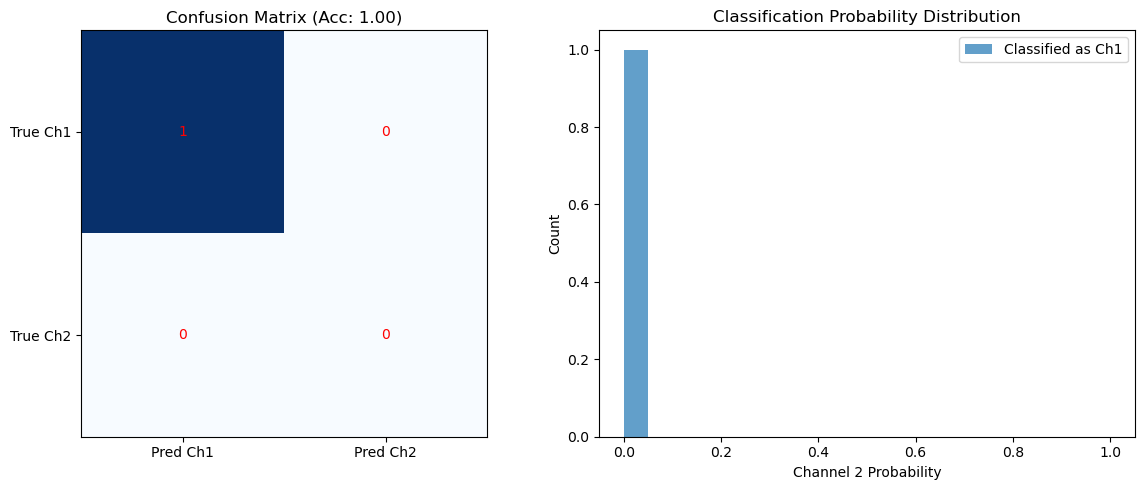

Epoch 11/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 20.99it/s, val_loss=0.2071]



Saved best model with val_loss: 0.2047

Epoch 11 Summary:
Train Loss: 0.2050 | Val Loss: 0.2047
Learning Rate: 1.00e-04


Epoch 12/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 21.09it/s, val_loss=0.1987]



Saved best model with val_loss: 0.1963

Epoch 12 Summary:
Train Loss: 0.1959 | Val Loss: 0.1963
Learning Rate: 1.00e-04


Epoch 13/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 20.67it/s, val_loss=0.1906]



Saved best model with val_loss: 0.1880

Epoch 13 Summary:
Train Loss: 0.1881 | Val Loss: 0.1880
Learning Rate: 1.00e-04


Epoch 14/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 20.95it/s, val_loss=0.1860]



Saved best model with val_loss: 0.1835

Epoch 14 Summary:
Train Loss: 0.1824 | Val Loss: 0.1835
Learning Rate: 1.00e-04


Epoch 15/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 18.60it/s, val_loss=0.1802]



Saved best model with val_loss: 0.1777

Epoch 15 Summary:
Train Loss: 0.1776 | Val Loss: 0.1777
Learning Rate: 1.00e-04


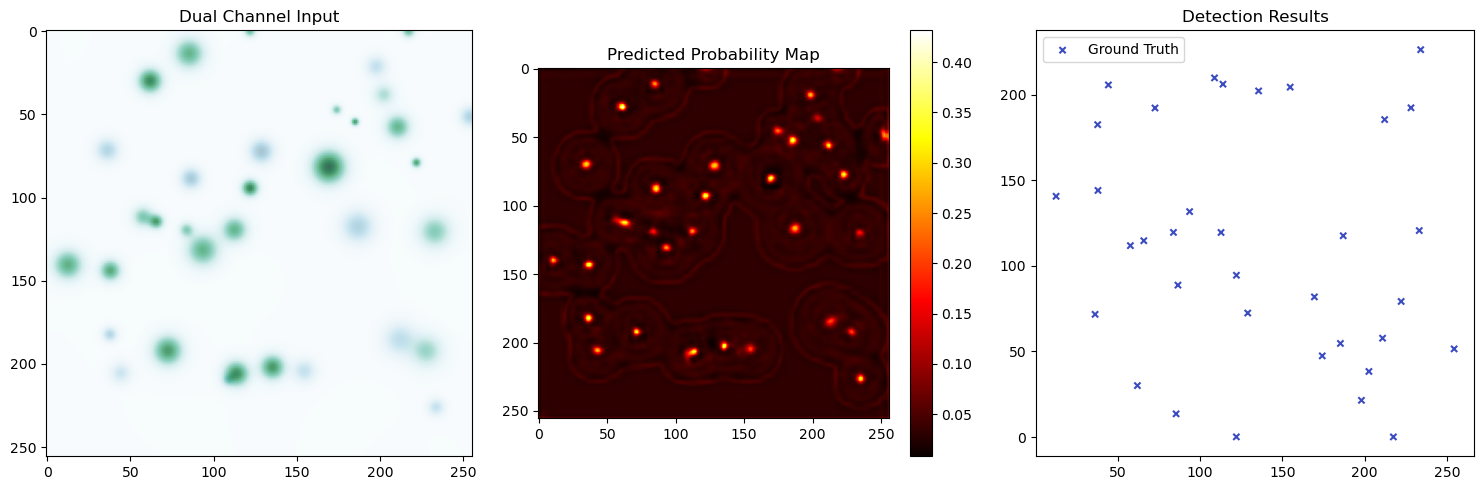

未检测到分子，仅显示基础可视化


Epoch 16/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 20.96it/s, val_loss=0.1770]



Saved best model with val_loss: 0.1745

Epoch 16 Summary:
Train Loss: 0.1742 | Val Loss: 0.1745
Learning Rate: 1.00e-04


Epoch 17/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 20.96it/s, val_loss=0.1744]



Saved best model with val_loss: 0.1719

Epoch 17 Summary:
Train Loss: 0.1709 | Val Loss: 0.1719
Learning Rate: 1.00e-04


Epoch 18/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 21.08it/s, val_loss=0.1717]



Saved best model with val_loss: 0.1692

Epoch 18 Summary:
Train Loss: 0.1683 | Val Loss: 0.1692
Learning Rate: 1.00e-04


Epoch 19/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 20.82it/s, val_loss=0.1693]



Saved best model with val_loss: 0.1667

Epoch 19 Summary:
Train Loss: 0.1658 | Val Loss: 0.1667
Learning Rate: 1.00e-04


Epoch 20/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 21.16it/s, val_loss=0.1667]



Saved best model with val_loss: 0.1642

Epoch 20 Summary:
Train Loss: 0.1638 | Val Loss: 0.1642
Learning Rate: 1.00e-04


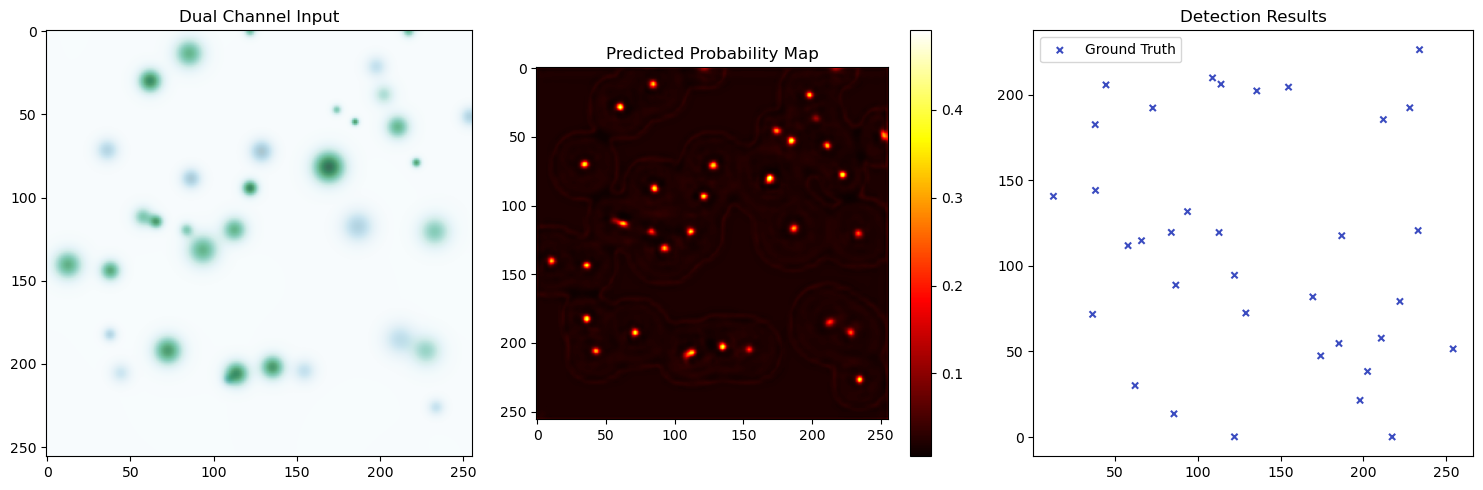

未检测到分子，仅显示基础可视化


Epoch 21/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 20.48it/s, val_loss=0.1656]



Saved best model with val_loss: 0.1631

Epoch 21 Summary:
Train Loss: 0.1620 | Val Loss: 0.1631
Learning Rate: 1.00e-04


Epoch 22/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 21.11it/s, val_loss=0.1635]



Saved best model with val_loss: 0.1610

Epoch 22 Summary:
Train Loss: 0.1606 | Val Loss: 0.1610
Learning Rate: 1.00e-04


Epoch 23/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 20.95it/s, val_loss=0.1633]



Saved best model with val_loss: 0.1608

Epoch 23 Summary:
Train Loss: 0.1590 | Val Loss: 0.1608
Learning Rate: 1.00e-04


Epoch 24/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 21.12it/s, val_loss=0.1609]



Saved best model with val_loss: 0.1584

Epoch 24 Summary:
Train Loss: 0.1579 | Val Loss: 0.1584
Learning Rate: 1.00e-04


Epoch 25/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 20.98it/s, val_loss=0.1601]



Saved best model with val_loss: 0.1576

Epoch 25 Summary:
Train Loss: 0.1569 | Val Loss: 0.1576
Learning Rate: 1.00e-04


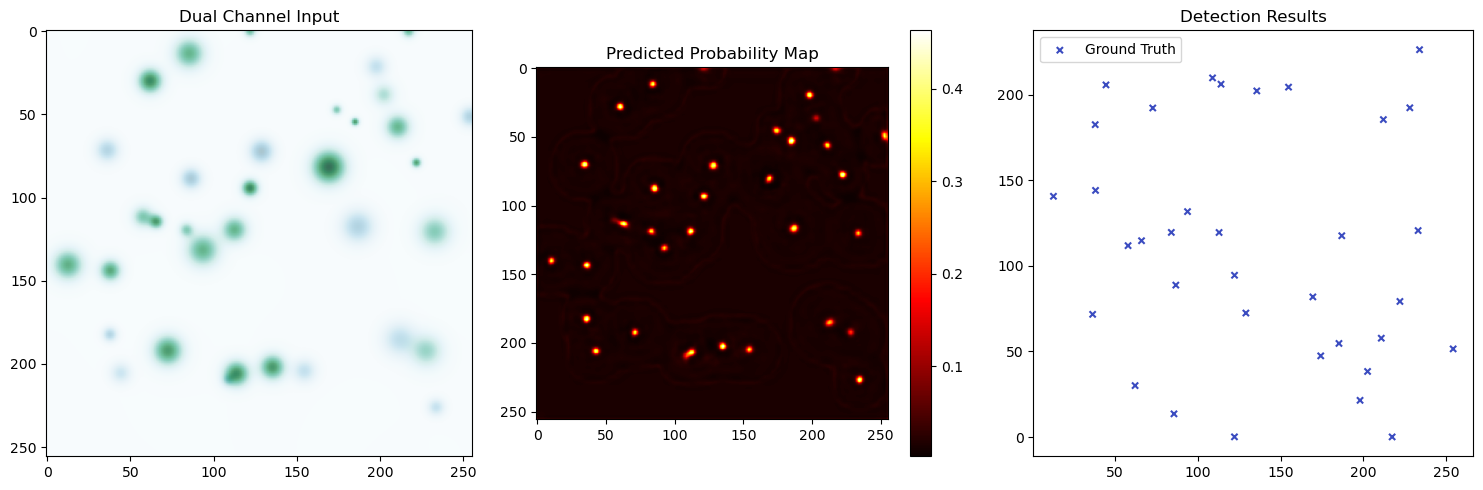

未检测到分子，仅显示基础可视化


Epoch 26/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 21.19it/s, val_loss=0.1589]



Saved best model with val_loss: 0.1564

Epoch 26 Summary:
Train Loss: 0.1556 | Val Loss: 0.1564
Learning Rate: 1.00e-04


Epoch 27/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 21.19it/s, val_loss=0.1583]



Saved best model with val_loss: 0.1559

Epoch 27 Summary:
Train Loss: 0.1547 | Val Loss: 0.1559
Learning Rate: 1.00e-04


Epoch 28/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 21.20it/s, val_loss=0.1576]



Saved best model with val_loss: 0.1551

Epoch 28 Summary:
Train Loss: 0.1540 | Val Loss: 0.1551
Learning Rate: 1.00e-04


Epoch 29/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 21.27it/s, val_loss=0.1564]



Saved best model with val_loss: 0.1539

Epoch 29 Summary:
Train Loss: 0.1534 | Val Loss: 0.1539
Learning Rate: 1.00e-04


Epoch 30/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 21.16it/s, val_loss=0.1561]



Saved best model with val_loss: 0.1536

Epoch 30 Summary:
Train Loss: 0.1526 | Val Loss: 0.1536
Learning Rate: 1.00e-04


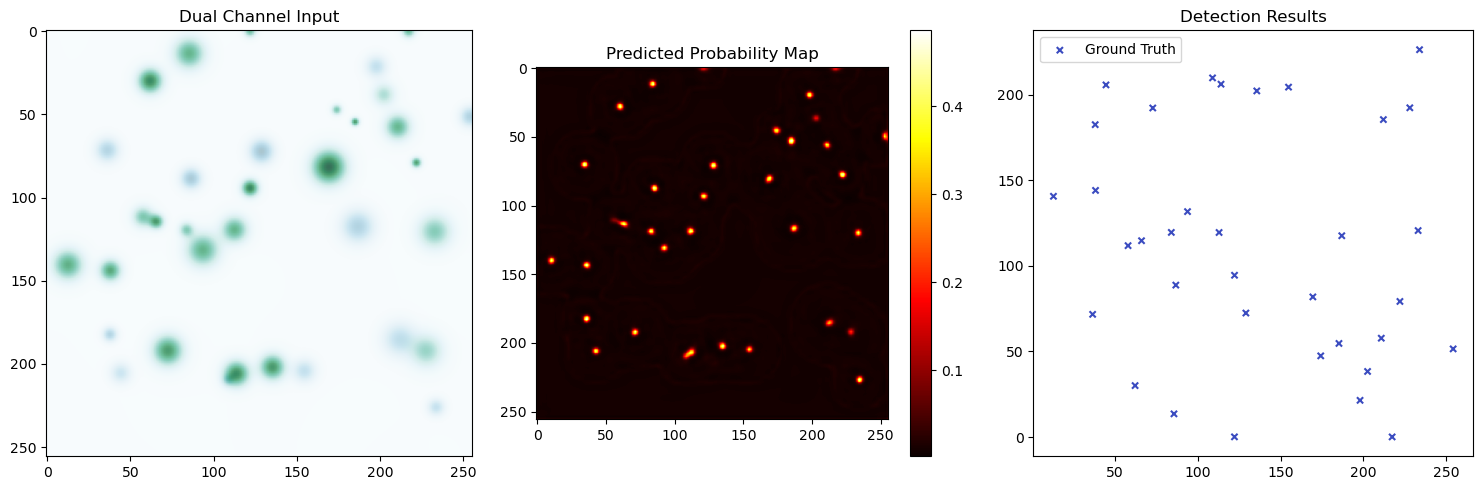

未检测到分子，仅显示基础可视化


Epoch 31/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 20.70it/s, val_loss=0.1551]



Saved best model with val_loss: 0.1526

Epoch 31 Summary:
Train Loss: 0.1521 | Val Loss: 0.1526
Learning Rate: 1.00e-04


Epoch 32/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 20.82it/s, val_loss=0.1549]



Saved best model with val_loss: 0.1524

Epoch 32 Summary:
Train Loss: 0.1514 | Val Loss: 0.1524
Learning Rate: 1.00e-04


Epoch 33/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 20.89it/s, val_loss=0.1540]



Saved best model with val_loss: 0.1515

Epoch 33 Summary:
Train Loss: 0.1507 | Val Loss: 0.1515
Learning Rate: 1.00e-04


Epoch 34/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 20.20it/s, val_loss=0.1538]



Saved best model with val_loss: 0.1513

Epoch 34 Summary:
Train Loss: 0.1503 | Val Loss: 0.1513
Learning Rate: 1.00e-04


Epoch 35/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 20.64it/s, val_loss=0.1534]



Saved best model with val_loss: 0.1509

Epoch 35 Summary:
Train Loss: 0.1500 | Val Loss: 0.1509
Learning Rate: 1.00e-04


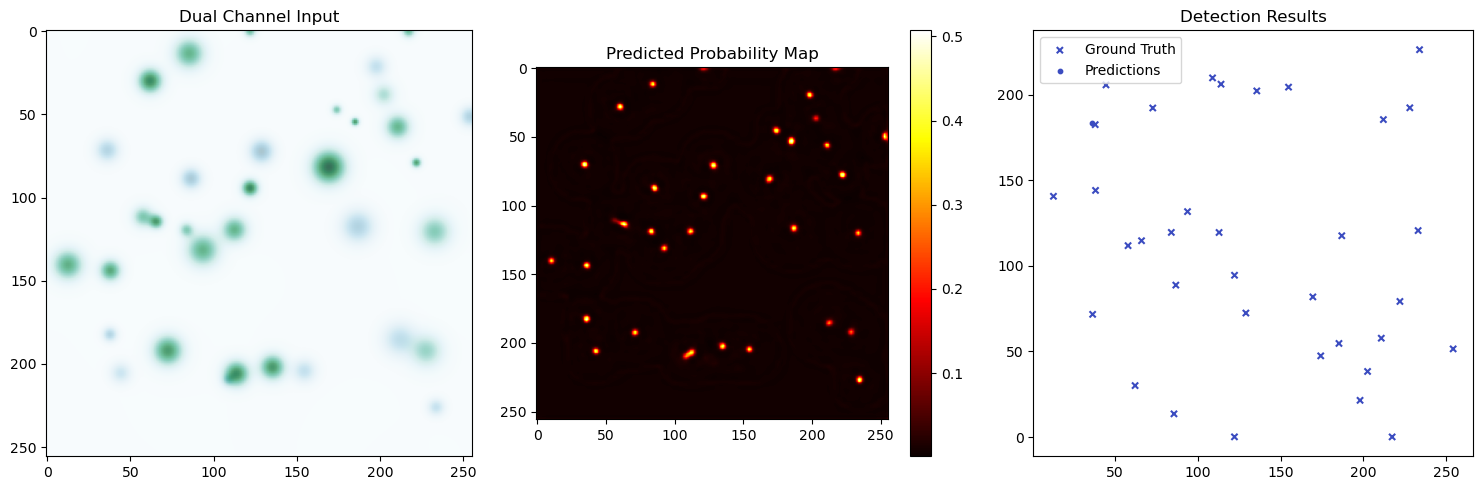

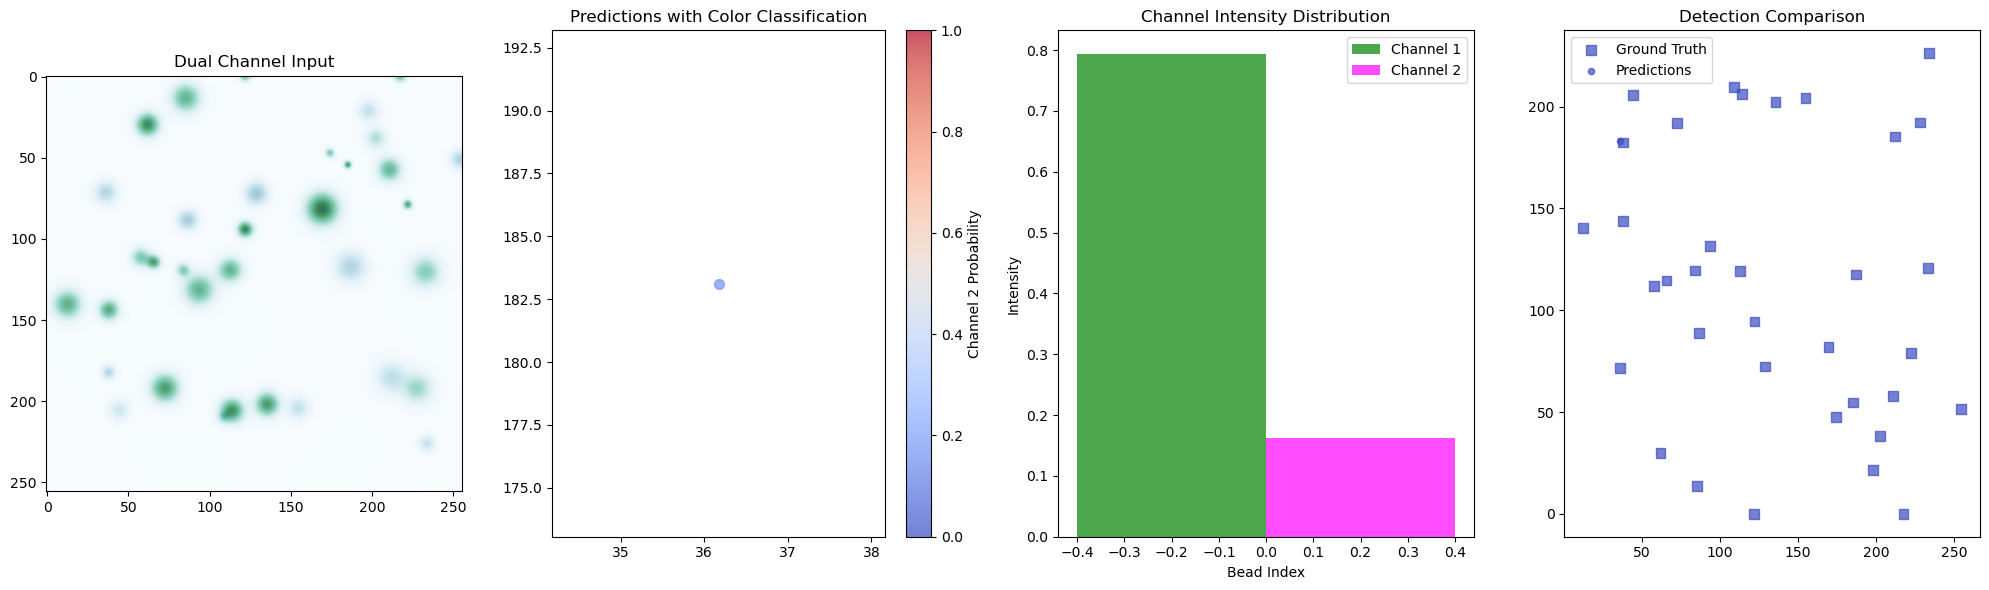

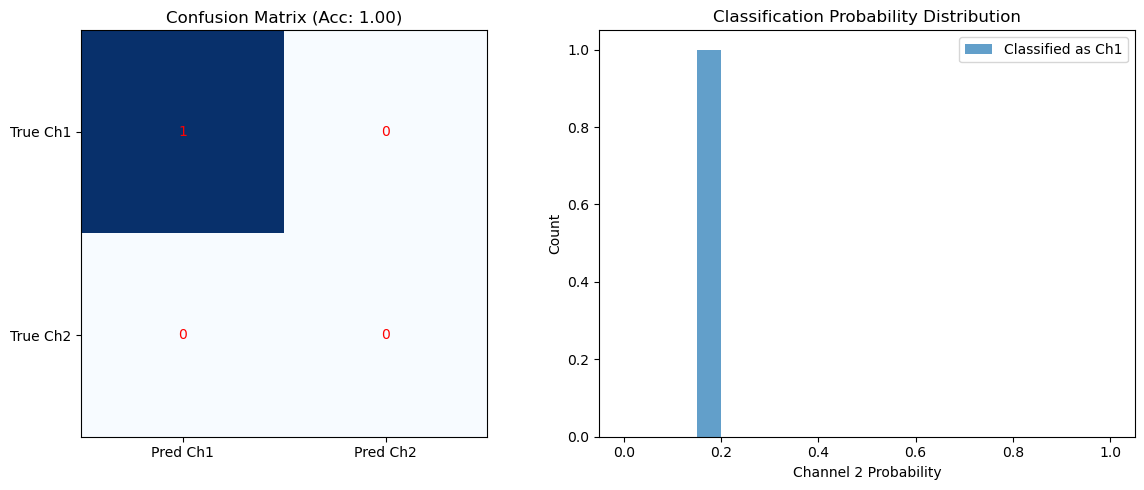

Epoch 36/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 20.86it/s, val_loss=0.1529]



Saved best model with val_loss: 0.1504

Epoch 36 Summary:
Train Loss: 0.1496 | Val Loss: 0.1504
Learning Rate: 1.00e-04


Epoch 37/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 20.95it/s, val_loss=0.1527]



Saved best model with val_loss: 0.1502

Epoch 37 Summary:
Train Loss: 0.1493 | Val Loss: 0.1502
Learning Rate: 1.00e-04


Epoch 38/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 20.58it/s, val_loss=0.1521]



Saved best model with val_loss: 0.1496

Epoch 38 Summary:
Train Loss: 0.1489 | Val Loss: 0.1496
Learning Rate: 1.00e-04


Epoch 39/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 20.89it/s, val_loss=0.1518]



Saved best model with val_loss: 0.1493

Epoch 39 Summary:
Train Loss: 0.1485 | Val Loss: 0.1493
Learning Rate: 1.00e-04


Epoch 40/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 20.51it/s, val_loss=0.1515]



Saved best model with val_loss: 0.1490

Epoch 40 Summary:
Train Loss: 0.1482 | Val Loss: 0.1490
Learning Rate: 1.00e-04


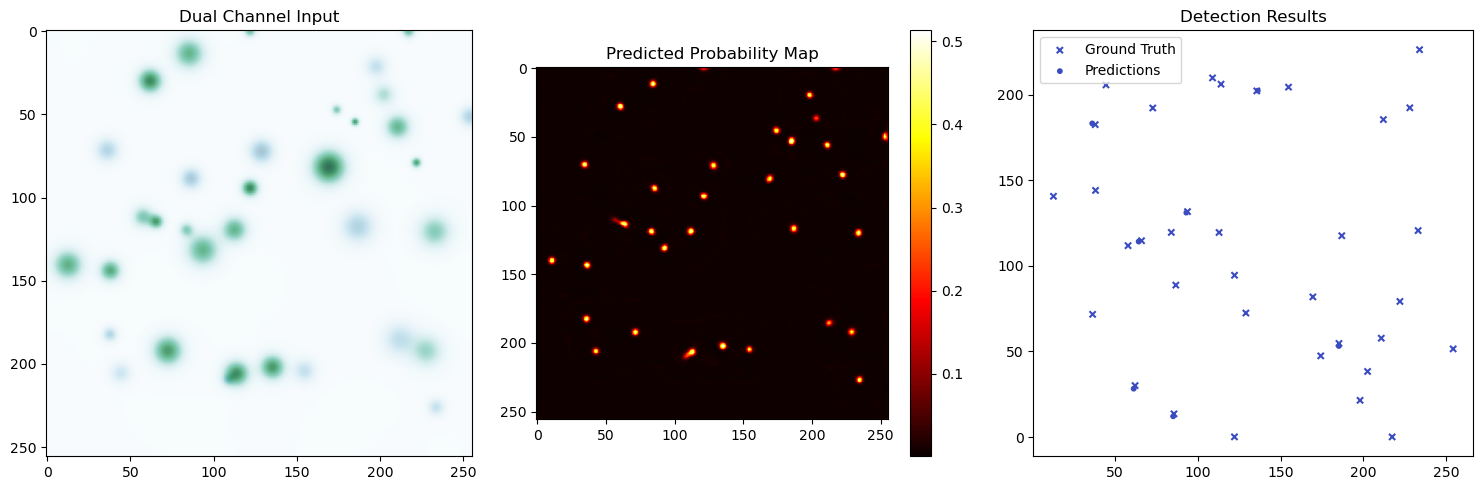

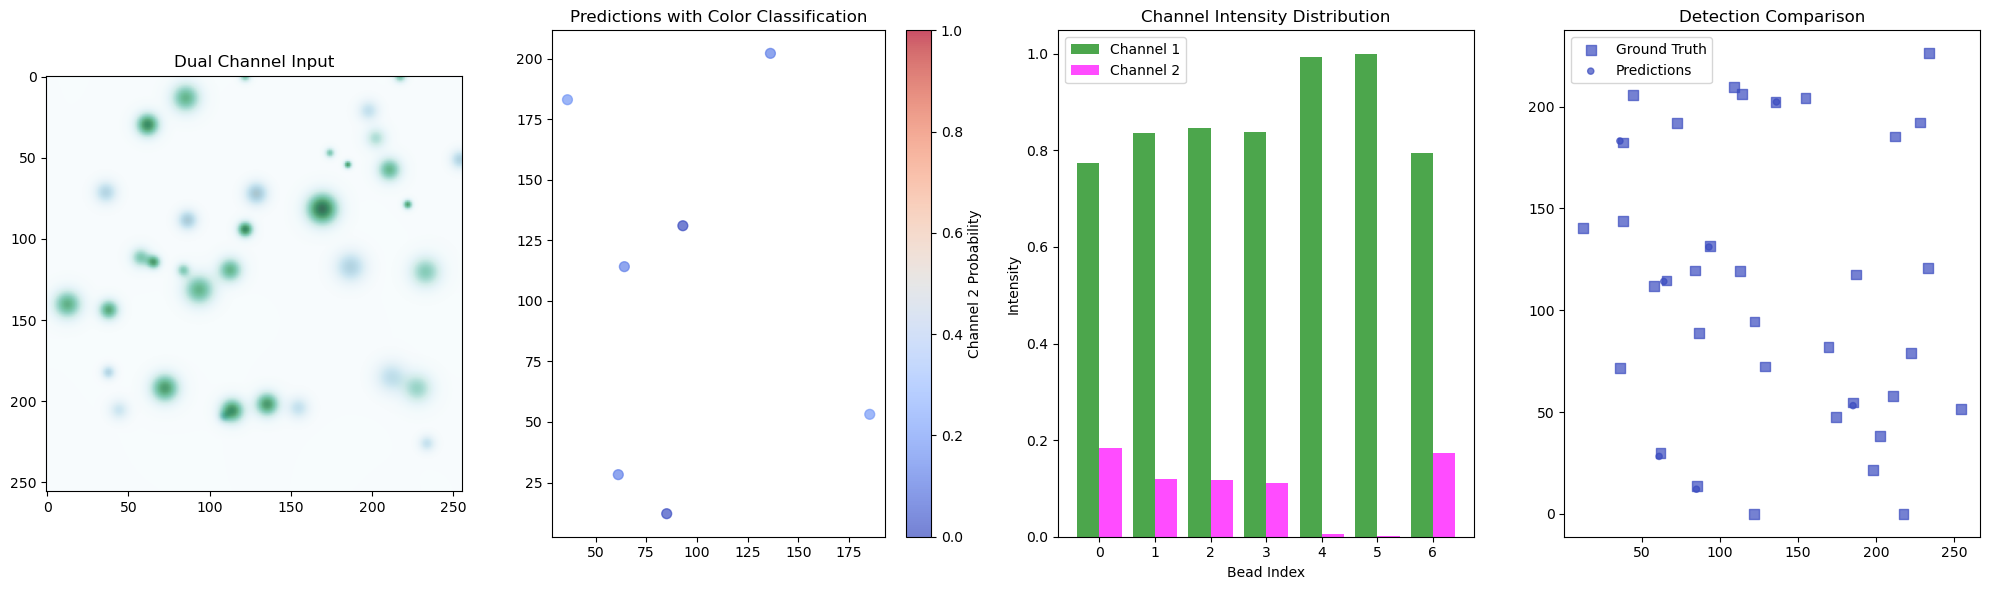

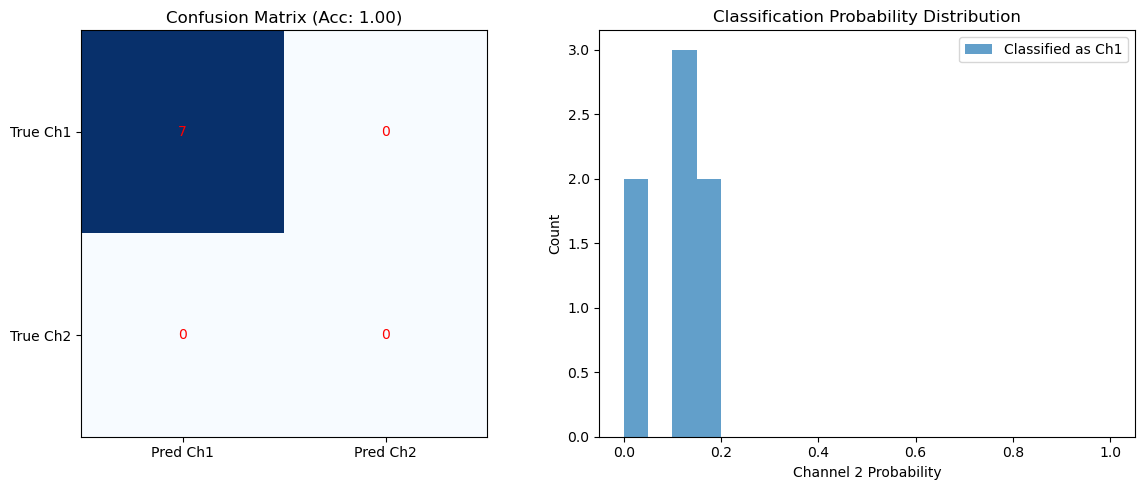

Epoch 41/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 20.84it/s, val_loss=0.1513]



Saved best model with val_loss: 0.1489

Epoch 41 Summary:
Train Loss: 0.1480 | Val Loss: 0.1489
Learning Rate: 1.00e-04


Epoch 42/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 20.76it/s, val_loss=0.1510]



Saved best model with val_loss: 0.1485

Epoch 42 Summary:
Train Loss: 0.1477 | Val Loss: 0.1485
Learning Rate: 1.00e-04


Epoch 43/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 21.12it/s, val_loss=0.1508]



Saved best model with val_loss: 0.1483

Epoch 43 Summary:
Train Loss: 0.1476 | Val Loss: 0.1483
Learning Rate: 1.00e-04


Epoch 44/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 21.14it/s, val_loss=0.1506]



Saved best model with val_loss: 0.1481

Epoch 44 Summary:
Train Loss: 0.1471 | Val Loss: 0.1481
Learning Rate: 1.00e-04


Epoch 45/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 20.89it/s, val_loss=0.1504]



Saved best model with val_loss: 0.1479

Epoch 45 Summary:
Train Loss: 0.1471 | Val Loss: 0.1479
Learning Rate: 1.00e-04


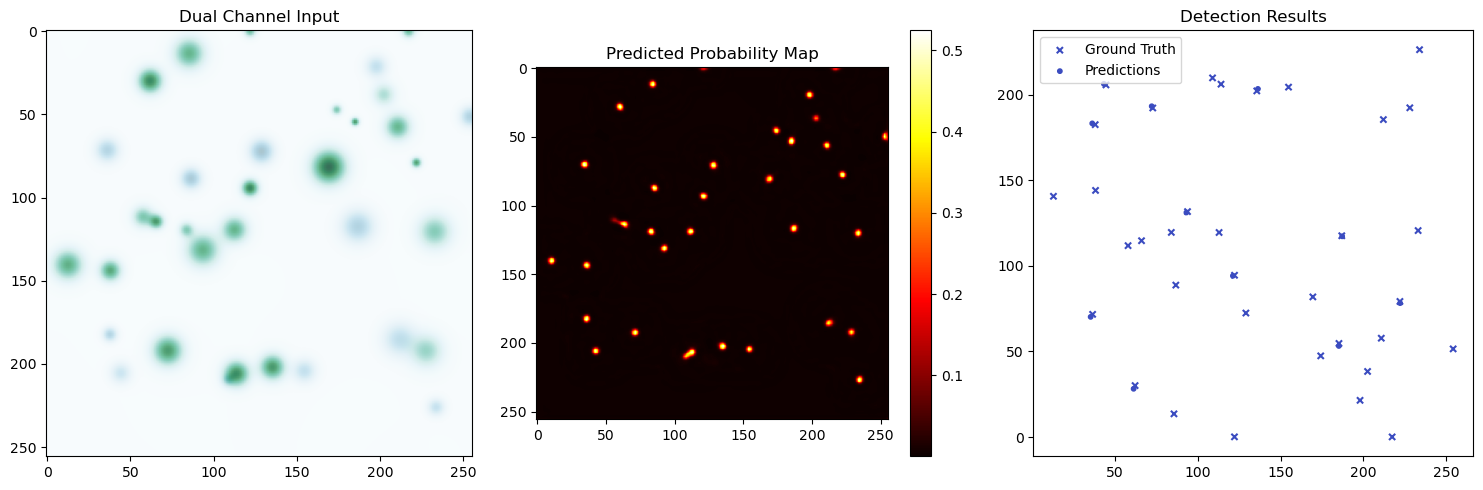

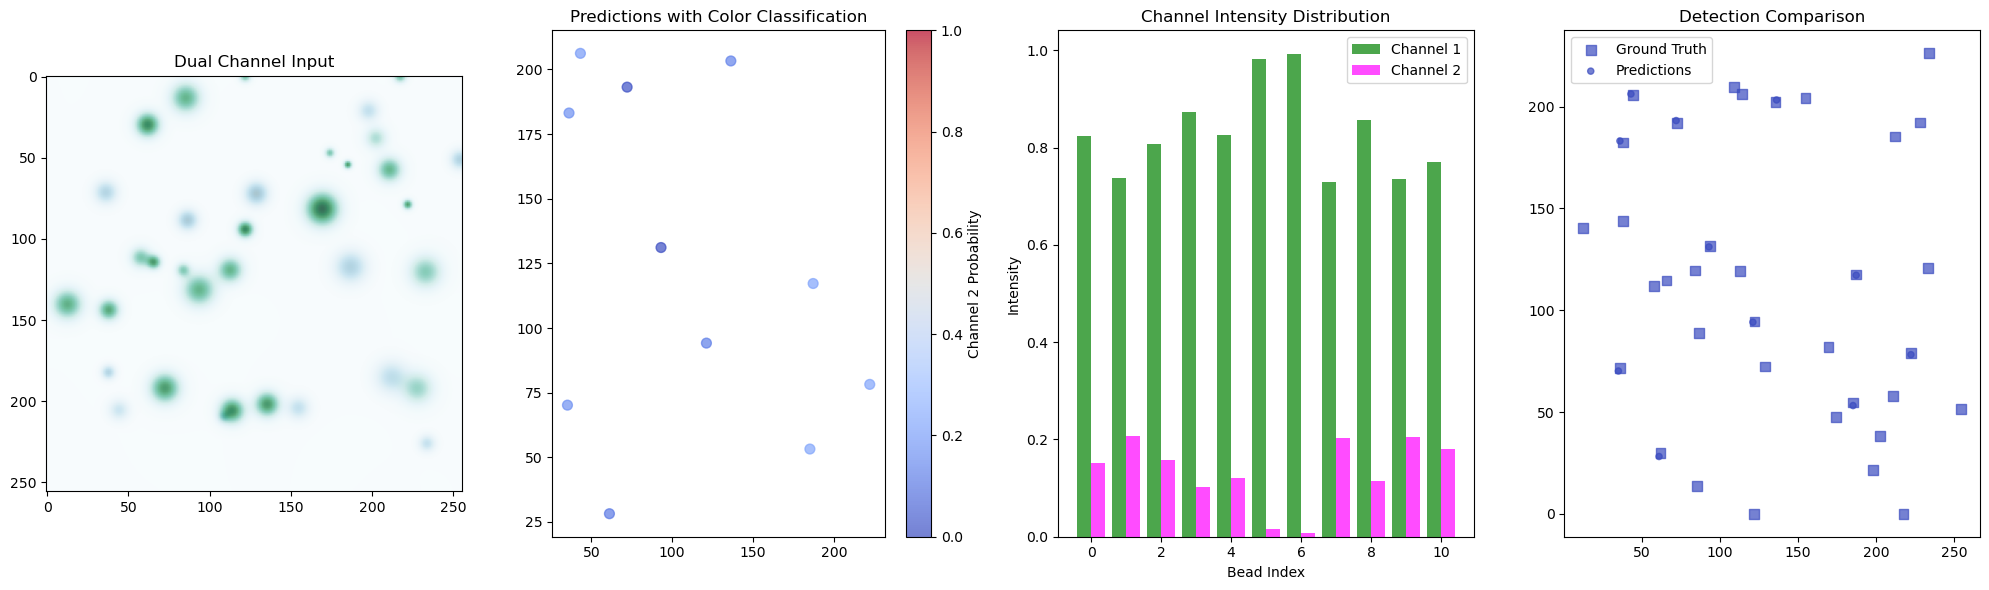

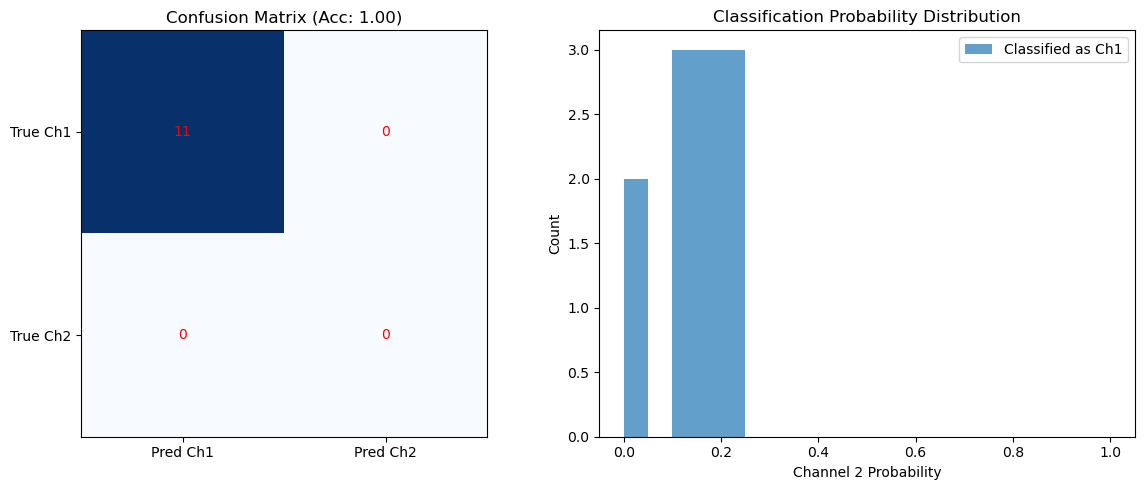

Epoch 46/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 20.79it/s, val_loss=0.1502]



Saved best model with val_loss: 0.1477

Epoch 46 Summary:
Train Loss: 0.1470 | Val Loss: 0.1477
Learning Rate: 1.00e-04


Epoch 47/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 20.81it/s, val_loss=0.1499]



Saved best model with val_loss: 0.1474

Epoch 47 Summary:
Train Loss: 0.1467 | Val Loss: 0.1474
Learning Rate: 1.00e-04


Epoch 48/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 20.94it/s, val_loss=0.1498]



Saved best model with val_loss: 0.1473

Epoch 48 Summary:
Train Loss: 0.1465 | Val Loss: 0.1473
Learning Rate: 1.00e-04


Epoch 49/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 20.92it/s, val_loss=0.1497]



Saved best model with val_loss: 0.1472

Epoch 49 Summary:
Train Loss: 0.1464 | Val Loss: 0.1472
Learning Rate: 1.00e-04


Epoch 50/50 [Val]: 100%|████████████████████| 5/5 [00:00<00:00, 20.86it/s, val_loss=0.1495]



Saved best model with val_loss: 0.1471

Epoch 50 Summary:
Train Loss: 0.1460 | Val Loss: 0.1471
Learning Rate: 1.00e-04


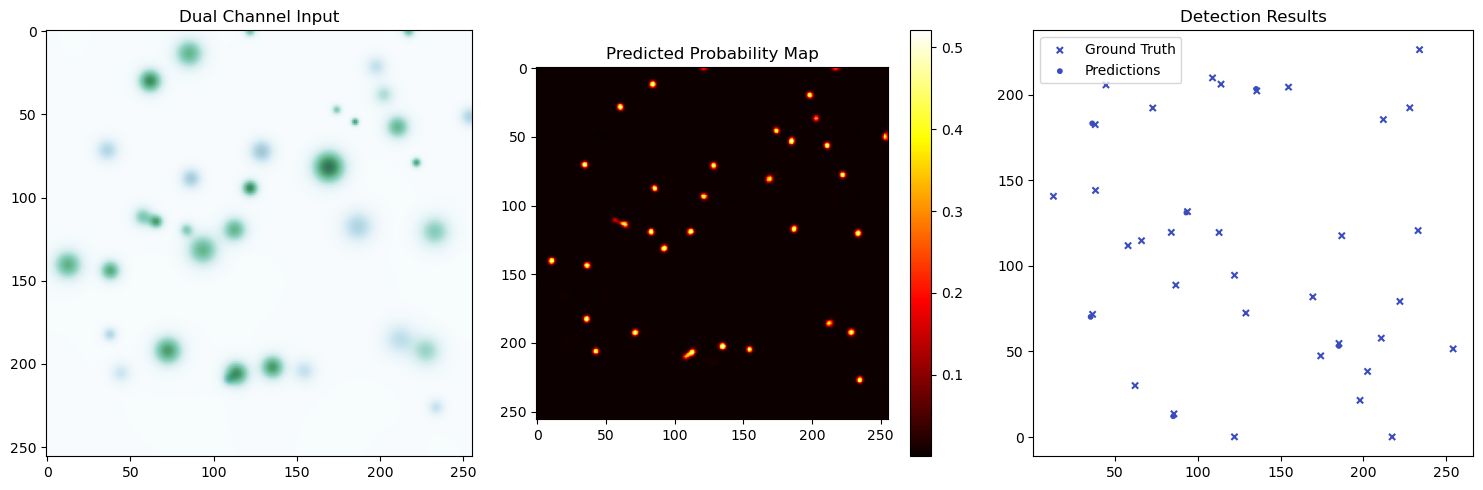

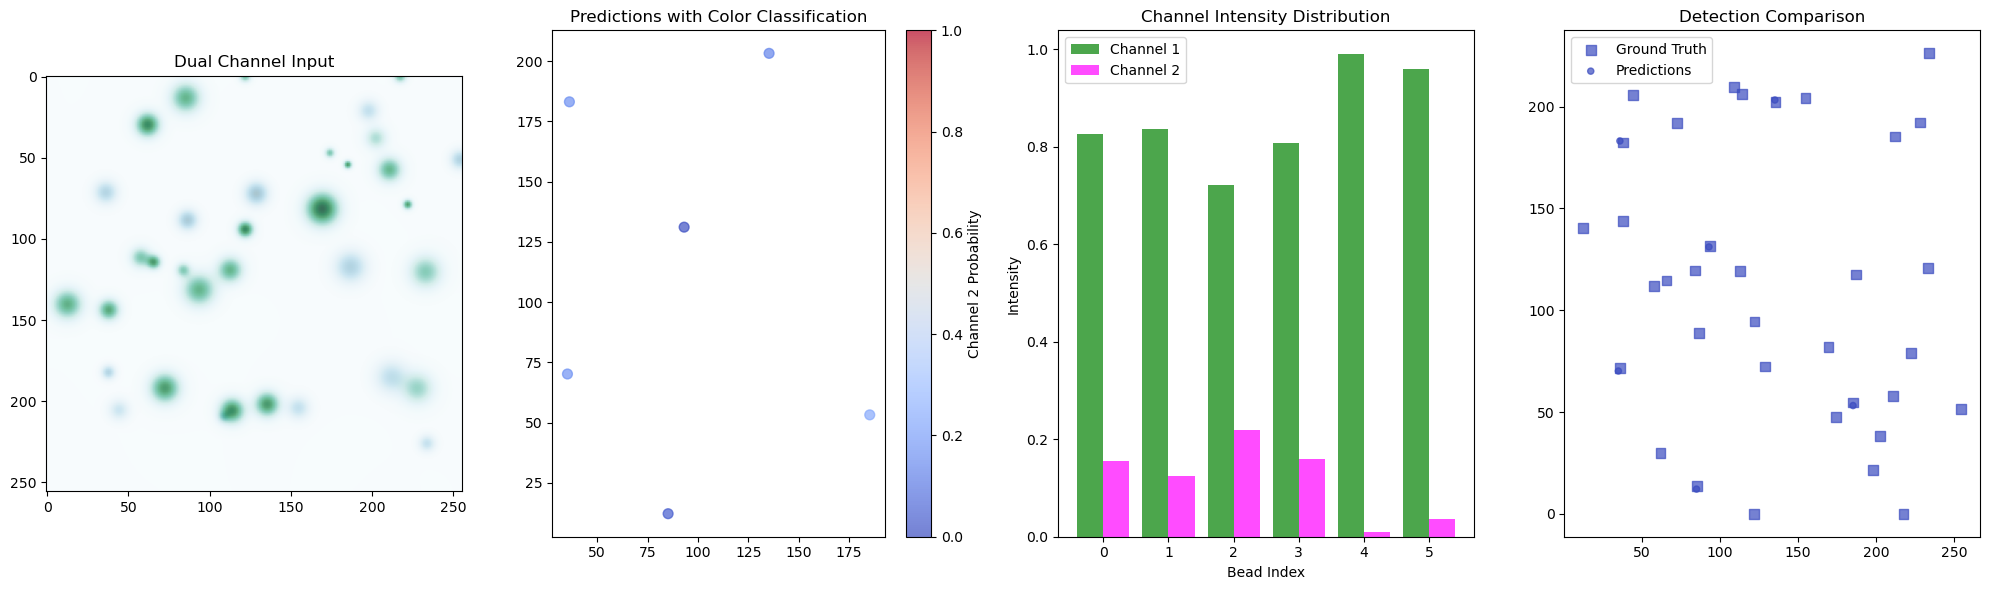

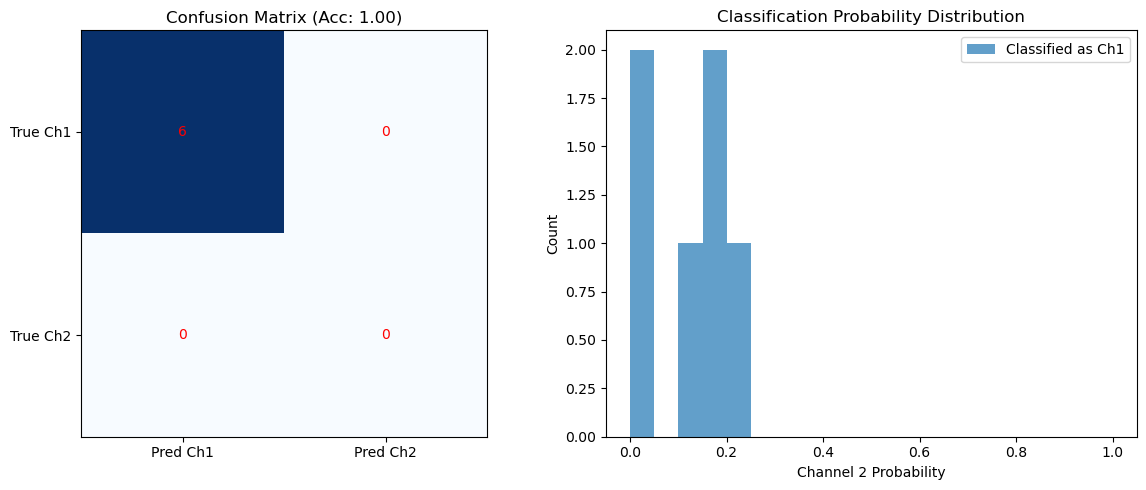


Final Evaluation:


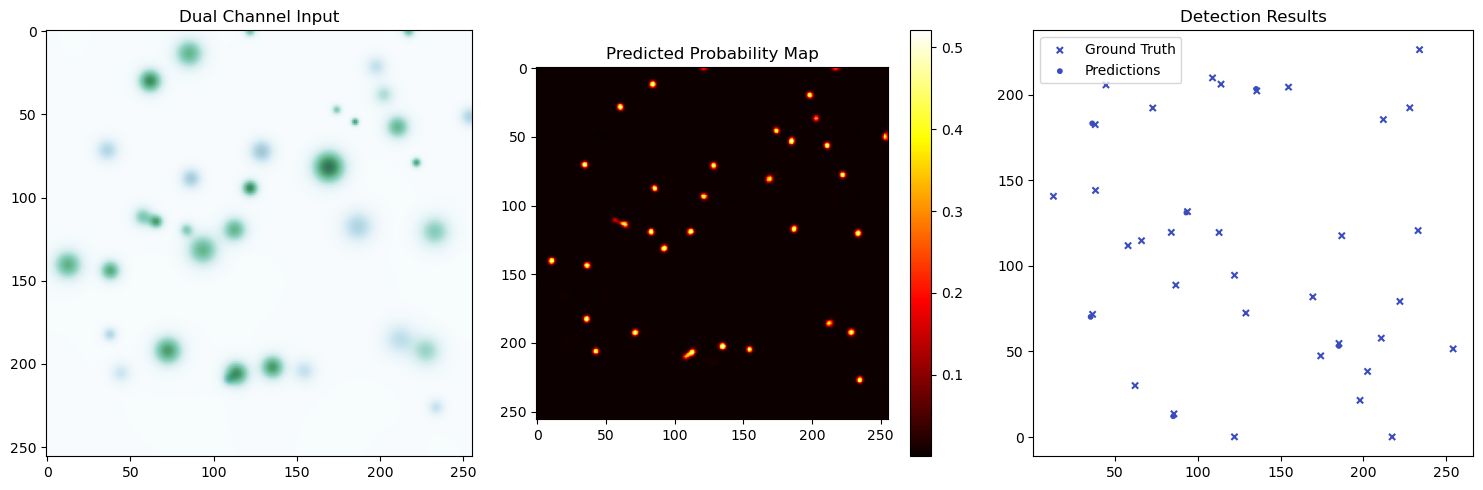

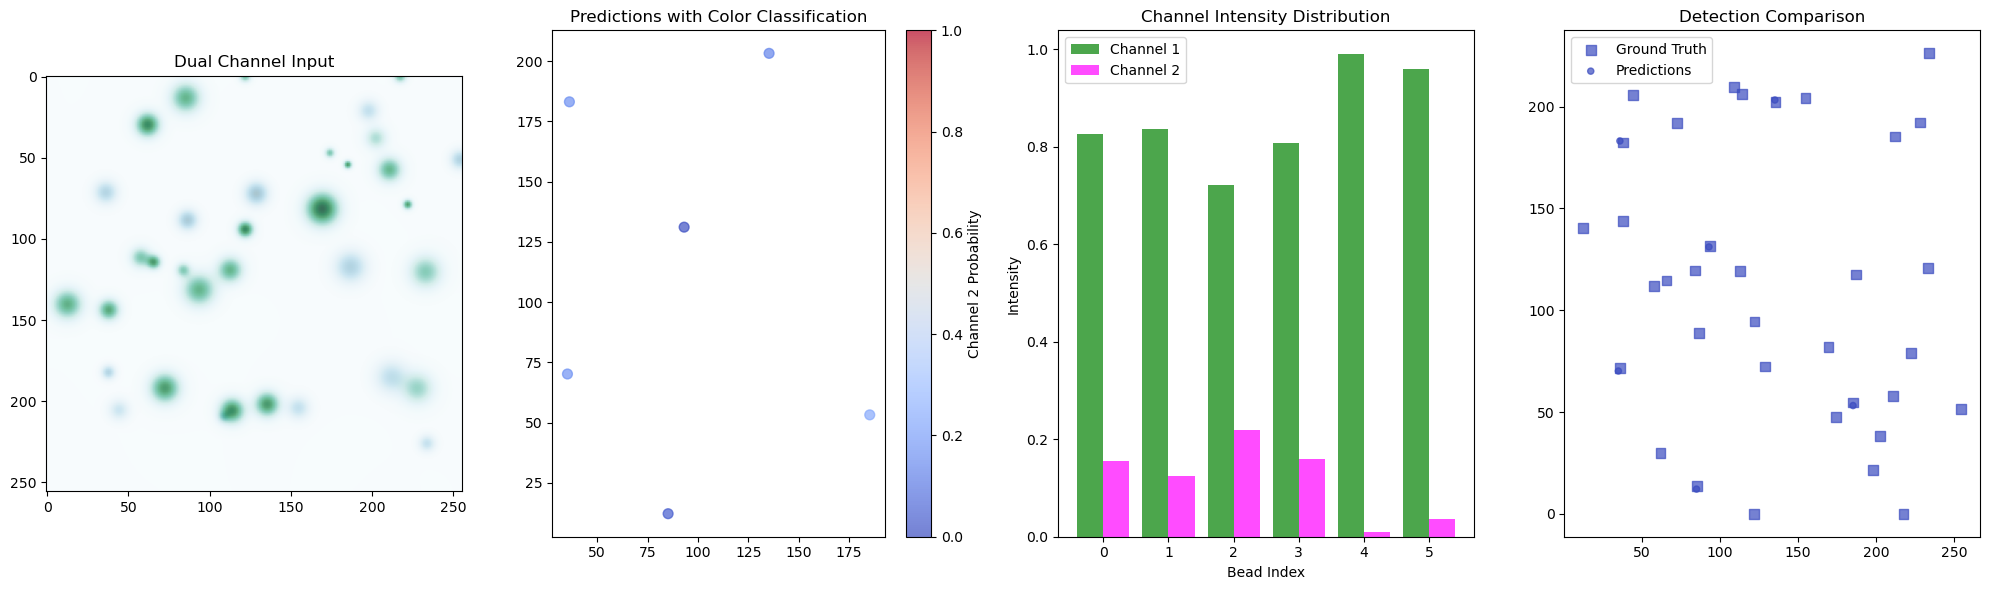

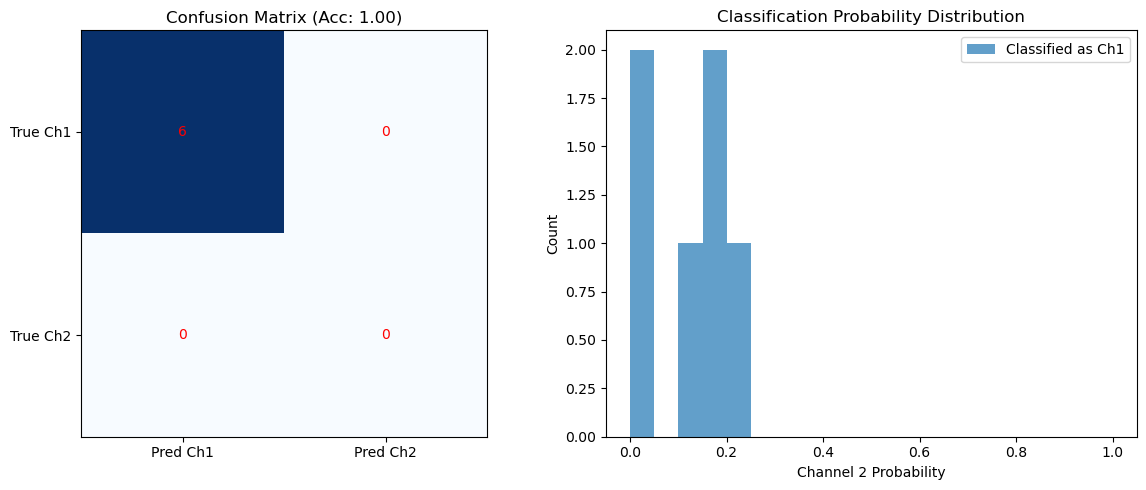

In [18]:
"""
ratimetric_analysis_system.py

改进后的完整系统，包含：
1. 数据生成时预计算所有Ground Truth映射
2. 修正的交叉比例计算逻辑
3. 优化的数据加载流程
"""

# -------------------- 模块1: 数据生成 --------------------
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from perlin_noise import PerlinNoise
from typing import Dict, Tuple

class RatiometricDataGenerator:
    def __init__(self, config: Dict):
        self.config = config
        self.image_size = config['image_size']
        self.pixel_size = config['pixel_size']  # nm/pixel
        self.psf_sigma = config['psf_sigma']  # PSF的sigma值（像素单位）
        
        # 通道参数
        self.channels = ['ch1', 'ch2']
        self.cross_ratios = {
            'ch1_to_ch2': config['cross_ratios']['ch1_to_ch2'],
            'ch2_to_ch1': config['cross_ratios']['ch2_to_ch1']
        }
        
        # 背景参数
        self.background_levels = {
            'ch1': config['background']['ch1'],
            'ch2': config['background']['ch2']
        }
        
        # 初始化Perlin噪声生成器
        self.noise_generator = PerlinNoise(octaves=4, seed=config['seed'])

    def generate_molecules(self, num_molecules: int) -> Dict:
        """生成分子属性（修正交叉比例计算）"""
        # 随机位置 (x, y, z)
        positions = np.random.rand(num_molecules, 3) * self.image_size
        positions[:, 2] = (positions[:, 2] * 2 - 1) * self.config['z_range']
        
        # 随机分配颜色标签
        colors = np.random.choice(['ch1', 'ch2'], num_molecules, 
                                p=[self.config['color_prob']['ch1'], 
                                   self.config['color_prob']['ch2']])
        
        # 初始化强度字典
        intensities = {'ch1': np.zeros(num_molecules), 'ch2': np.zeros(num_molecules)}
        
        # 逐个分子生成强度
        for i in range(num_molecules):
            color = colors[i]
            if color == 'ch1':
                mean = self.config['intensity']['ch1']['mean']
                std = self.config['intensity']['ch1']['std']
                main_intensity = np.abs(np.random.normal(mean, std))
                intensities['ch1'][i] = main_intensity
                intensities['ch2'][i] = main_intensity * self.cross_ratios['ch1_to_ch2']
            else:
                mean = self.config['intensity']['ch2']['mean']
                std = self.config['intensity']['ch2']['std']
                main_intensity = np.abs(np.random.normal(mean, std))
                intensities['ch2'][i] = main_intensity
                intensities['ch1'][i] = main_intensity * self.cross_ratios['ch2_to_ch1']
        
        return {
            'positions': positions,
            'intensities': intensities,
            'colors': colors
        }

    def _gaussian_psf(self, x, y, z, intensity):
        """生成高斯点扩散函数"""
        sigma = self.psf_sigma * (1 + 0.3 * np.abs(z))  # z-dependent PSF宽度
        size = int(7 * sigma)
        half_size = size // 2
        
        # 计算有效区域边界
        x_min = max(0, int(x) - half_size)
        x_max = min(self.image_size, int(x) + half_size + 1)
        y_min = max(0, int(y) - half_size)
        y_max = min(self.image_size, int(y) + half_size + 1)
        
        if x_min >= x_max or y_min >= y_max:
            return np.zeros((self.image_size, self.image_size))
        
        # 创建局部高斯分布
        xx, yy = np.meshgrid(np.arange(x_min, x_max), np.arange(y_min, y_max))
        psf = intensity * np.exp(-((xx - x)**2 + (yy - y)**2) / (2 * sigma**2))
        
        # 填充到全图
        full_psf = np.zeros((self.image_size, self.image_size))
        full_psf[y_min:y_max, x_min:x_max] = psf
        return full_psf
    
    def _generate_background(self, channel: str) -> np.ndarray:
        """生成背景噪声"""
        background = np.zeros((self.image_size, self.image_size))
        for i in range(self.image_size):
            for j in range(self.image_size):
                background[i,j] = self.noise_generator([i/self.image_size, j/self.image_size])
        
        # 缩放噪声强度
        bg_level = self.background_levels[channel]
        background = (background - background.min()) / (background.max() - background.min())
        return background * bg_level
    
    def _generate_ground_truth_maps(self, positions, colors, intensities, image_size):
        """生成Ground Truth映射"""
        p_map = np.zeros((1, image_size, image_size), dtype=np.float32)
        color_map = np.zeros_like(p_map)
        xyzi_map = np.zeros((4, image_size, image_size), dtype=np.float32)
        radius = 2
        
        # 生成高斯核模板
        xx, yy = np.meshgrid(np.arange(-radius, radius+1), 
                            np.arange(-radius, radius+1))
        gaussian_kernel = np.exp(-(xx**2 + yy**2)/(2*(radius/2)**2))
        
        for i in range(len(positions)):
            x, y, z = positions[i]
            xi = int(x.clip(0, image_size-1))
            yi = int(y.clip(0, image_size-1))
            
            # 生成概率热图
            x_min = max(0, xi - radius)
            x_max = min(image_size, xi + radius + 1)
            y_min = max(0, yi - radius)
            y_max = min(image_size, yi + radius + 1)
            
            if x_min < x_max and y_min < y_max:
                # 修正核裁剪方式
                kernel_x_start = radius - (xi - x_min)
                kernel_x_end = radius + (x_max - xi)
                kernel_y_start = radius - (yi - y_min)
                kernel_y_end = radius + (y_max - yi)
                
                kernel = gaussian_kernel[
                    kernel_y_start:kernel_y_end, 
                    kernel_x_start:kernel_x_end
                ]
                p_map[0, y_min:y_max, x_min:x_max] = np.maximum(
                    p_map[0, y_min:y_max, x_min:x_max], kernel)
            
            # 颜色标记
            color_map[0, yi, xi] = 1.0 if colors[i] == 'ch1' else 0.0
            
            # 坐标和强度
            xyzi_map[0, yi, xi] = x - xi  # x偏移
            xyzi_map[1, yi, xi] = y - yi  # y偏移
            xyzi_map[2, yi, xi] = z       # z位置
            xyzi_map[3, yi, xi] = intensities[i].sum()  # 总强度
        
        return p_map, color_map, xyzi_map
    
    def render_image(self, molecules: Dict) -> Tuple[np.ndarray, Dict]:
        """渲染双通道图像并生成所有映射"""
        ch1_image = np.zeros((self.image_size, self.image_size))
        ch2_image = np.zeros((self.image_size, self.image_size))
        
        # 渲染每个分子
        for i in range(len(molecules['positions'])):
            x, y, z = molecules['positions'][i]
            ch1_image += self._gaussian_psf(x, y, z, molecules['intensities']['ch1'][i])
            ch2_image += self._gaussian_psf(x, y, z, molecules['intensities']['ch2'][i])
        
        # 添加背景噪声
        ch1_image += self._generate_background('ch1')
        ch2_image += self._generate_background('ch2')
        
        # 合并为多通道图像
        combined_image = np.stack([ch1_image, ch2_image], axis=0)
        
        # 生成Ground Truth映射
        p_map, color_map, xyzi_map = self._generate_ground_truth_maps(
            molecules['positions'],
            molecules['colors'],
            np.stack([molecules['intensities']['ch1'], molecules['intensities']['ch2']], axis=1),
            self.image_size
        )
        
        return combined_image, {
            'positions': molecules['positions'],
            'intensities': np.stack([molecules['intensities']['ch1'], 
                                    molecules['intensities']['ch2']], axis=1),
            'colors': (molecules['colors'] == 'ch1').astype(int),
            'p_map': p_map,
            'color_map': color_map,
            'xyzi_map': xyzi_map
        }
    
    def generate_dataset(self, num_samples: int, save_dir: str):
        """生成完整数据集"""
        os.makedirs(save_dir, exist_ok=True)
        
        all_images = []
        all_gt = []
        
        for i in tqdm(range(num_samples), desc="Generating dataset"):
            num_molecules = np.random.randint(
                self.config['num_molecules_range'][0],
                self.config['num_molecules_range'][1]
            )
            
            molecules = self.generate_molecules(num_molecules)
            image, gt = self.render_image(molecules)
            
            if i == 0:
                self.visualize_sample(image, gt)
            
            all_images.append(image)
            all_gt.append(gt)
        
        # 转换为numpy数组
        np.savez_compressed(
            os.path.join(save_dir, 'dataset.npz'),
            images=np.array(all_images, dtype=np.float32),
            positions=np.array([gt['positions'] for gt in all_gt], dtype=object),
            intensities=np.array([gt['intensities'] for gt in all_gt], dtype=object),
            colors=np.array([gt['colors'] for gt in all_gt], dtype=object),
            p_maps=np.array([gt['p_map'] for gt in all_gt], dtype=np.float32),
            color_maps=np.array([gt['color_map'] for gt in all_gt], dtype=np.float32),
            xyzi_maps=np.array([gt['xyzi_map'] for gt in all_gt], dtype=np.float32)
        )
        print(f"Dataset saved to {save_dir}")

    def visualize_sample(self, image: np.ndarray, gt: Dict):
        """可视化样本"""
        plt.figure(figsize=(18, 6))
        
        # 显示输入图像
        plt.subplot(2, 2, 1)
        plt.imshow(image[0], cmap='hot')
        plt.title('Channel 1')
        plt.colorbar()
        
        plt.subplot(2, 2, 2)
        plt.imshow(image[1], cmap='hot')
        plt.title('Channel 2')
        plt.colorbar()
        
        # 显示Ground Truth映射
        plt.subplot(2, 2, 3)
        plt.imshow(gt['p_map'][0], cmap='hot')
        plt.title('Probability Map')
        
        plt.subplot(2, 2, 4, aspect='equal')
        plt.scatter(gt['positions'][:,0], gt['positions'][:,1], 
                   c=gt['colors'], cmap='coolwarm', s=5)
        plt.title('Molecule Positions')
        plt.gca().invert_yaxis()
        
        plt.tight_layout()
        plt.show()

# -------------------- 模块2: 神经网络 --------------------
import torch
import torch.nn as nn
import torch.nn.functional as F

class EncoderBlock(nn.Module):
    def __init__(self, in_ch, base_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, base_ch, 3, padding=1),
            nn.BatchNorm2d(base_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_ch, base_ch*2, 3, padding=1),
            nn.BatchNorm2d(base_ch*2),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.MaxPool2d(2)
    
    def forward(self, x):
        x = self.pool(x)
        return self.conv(x)

class RatioAwareUNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # 修改编码器输出通道数
        self.encoder_ch1 = nn.Sequential(
            EncoderBlock(1, config['base_ch']),  # 输出通道: base_ch*2
            EncoderBlock(config['base_ch']*2, config['base_ch'])  # 输出通道: base_ch*2
        )
        self.encoder_ch2 = nn.Sequential(
            EncoderBlock(1, config['base_ch']),
            EncoderBlock(config['base_ch']*2, config['base_ch'])
        )
        
        # 修改比例特征提取层
        self.ratio_conv = nn.Sequential(
            nn.Conv2d(2, config['base_ch'], 3, padding=1),  # 增大输出通道
            nn.ReLU(),
            nn.Conv2d(config['base_ch'], config['base_ch'], 3, padding=1),
            nn.ReLU()
        )
        
        # 修改解码器输入通道数
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True),
            # 注意这里的输入通道数计算：
            # encoder_ch1输出: base_ch*2
            # encoder_ch2输出: base_ch*2 
            # ratio_conv输出: base_ch
            # 总和: base_ch*5
            nn.Conv2d(config['base_ch']*5, config['base_ch'], 3, padding=1),
            nn.BatchNorm2d(config['base_ch']),
            nn.ReLU(inplace=True),
            nn.Conv2d(config['base_ch'], config['base_ch'], 3, padding=1),
            nn.BatchNorm2d(config['base_ch']),
            nn.ReLU(inplace=True)
        )
        
        # 输出头
        self.output_head = nn.ModuleDict({
            'xyzi': nn.Conv2d(config['base_ch'], 4, 3, padding=1),
            'p': nn.Conv2d(config['base_ch'], 1, 3, padding=1),
            'color': nn.Sequential(
                nn.Conv2d(config['base_ch'], config['base_ch']//2, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(config['base_ch']//2, 1, 1),
                nn.Sigmoid()
            )
        })
        
        if config['sig_pred']:
            self.output_head['sig'] = nn.Conv2d(config['base_ch'], 4, 3, padding=1)

    def forward(self, x):
        ch1, ch2 = x[:, 0:1], x[:, 1:2]
        
        # 编码特征
        feats_ch1 = self.encoder_ch1(ch1)
        feats_ch2 = self.encoder_ch2(ch2)
        
        # 比例特征
        with torch.no_grad():
            total = ch1 + ch2 + 1e-6
            ratios = torch.cat([ch1/total, ch2/total], dim=1)
        ratio_feats = self.ratio_conv(ratios)
        ratio_feats = F.avg_pool2d(ratio_feats, 4)
        
        # 特征融合
        combined = torch.cat([feats_ch1, feats_ch2, ratio_feats], dim=1)
        
        # 解码
        decoded = self.decoder(combined)
        
        # 输出
        outputs = {
            'xyzi': torch.sigmoid(self.output_head['xyzi'](decoded)),
            'p': torch.sigmoid(self.output_head['p'](decoded)),
            'color_prob': self.output_head['color'](decoded)
        }
        
        if 'sig' in self.output_head:
            outputs['xyzi_sig'] = F.softplus(self.output_head['sig'](decoded))
        
        return outputs

# -------------------- 模块3: 数据加载 --------------------
from torch.utils.data import Dataset, DataLoader

class RatiometricDataset(Dataset):
    def __init__(self, npz_path):
        data = np.load(npz_path, allow_pickle=True)
        self.images = data['images']
        self.p_maps = data['p_maps']
        self.color_maps = data['color_maps']
        self.xyzi_maps = data['xyzi_maps']
        self.positions = data['positions']
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return {
            'image': torch.from_numpy(self.images[idx].copy()),
            'p_map': torch.from_numpy(self.p_maps[idx].copy()),
            'color_map': torch.from_numpy(self.color_maps[idx].copy()),
            'xyzi': torch.from_numpy(self.xyzi_maps[idx].copy()),
            'positions': self.positions[idx]
        }

def collate_fn(batch):
    """处理变长位置数据的collate函数"""
    return {
        'image': torch.stack([item['image'] for item in batch]),
        'p_map': torch.stack([item['p_map'] for item in batch]),
        'color_map': torch.stack([item['color_map'] for item in batch]),
        'xyzi': torch.stack([item['xyzi'] for item in batch]),
        'positions': [item['positions'] for item in batch]  # 如果后续需要用到positions
    }

# -------------------- 模块4: 训练框架 --------------------
class Trainer:
    def __init__(self, config):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # 初始化模型
        self.model = RatioAwareUNet(config).to(self.device)
        
        # 优化器
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=config['lr'],
            weight_decay=config['weight_decay']
        )
        
        # 学习率调度
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.5,
            patience=5,
            verbose=True
        )
        
        # 损失函数
        self.loss_fn = self._get_loss_fn()
        
        # 记录器
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'precision': [],
            'recall': []
        }
    
    def _get_loss_fn(self):
        def loss_func(pred, target):
            # 存在概率损失
            p_loss = F.binary_cross_entropy(pred['p'], target['p_map'])
            
            # 坐标损失 (只在分子位置计算)
            mask = (target['p_map'] > 0.5).float()  # [B,1,H,W]
            
            # 扩展mask以匹配xyzi的通道数 [B,1,H,W] -> [B,4,H,W]
            expanded_mask = mask.repeat(1, 4, 1, 1)
            
            if mask.sum() > 0:
                # 使用扩展后的mask计算损失
                xyzi_loss = F.mse_loss(
                    pred['xyzi'] * expanded_mask, 
                    target['xyzi'] * expanded_mask
                ) / (expanded_mask.sum() + 1e-6)  # 归一化
            else:
                xyzi_loss = torch.tensor(0.0).to(self.device)
            
            # 颜色分类损失 (使用原始单通道mask)
            if mask.sum() > 0:
                color_loss = F.binary_cross_entropy(
                    pred['color_prob'] * mask,
                    target['color_map'] * mask
                ) / (mask.sum() + 1e-6)  # 归一化
            else:
                color_loss = torch.tensor(0.0).to(self.device)
            
            # 总损失
            total_loss = (
                self.config['loss_weights']['p'] * p_loss +
                self.config['loss_weights']['xyzi'] * xyzi_loss +
                self.config['loss_weights']['color'] * color_loss
            )
            
            # 如果预测不确定性
            if 'xyzi_sig' in pred and mask.sum() > 0:
                sig_loss = F.mse_loss(
                    pred['xyzi_sig'] * expanded_mask, 
                    torch.zeros_like(pred['xyzi_sig']) * expanded_mask
                ) / (expanded_mask.sum() + 1e-6)
                total_loss += self.config['loss_weights']['sig'] * sig_loss
            
            return total_loss, {
                'p_loss': p_loss.item(),
                'xyzi_loss': xyzi_loss.item() if mask.sum() > 0 else 0.0,
                'color_loss': color_loss.item() if mask.sum() > 0 else 0.0
            }
        
        return loss_func

    def prepare_dataloaders(self, npz_path, batch_size=4, test_size=0.2, num_workers=0):
        """修正后的数据加载方法，增加num_workers参数"""
        print("\n=== 准备数据加载器 ===")
        
        full_dataset = RatiometricDataset(npz_path)
        print(f"数据集加载完成，总样本数: {len(full_dataset)}")
        
        train_size = int((1 - test_size) * len(full_dataset))
        self.train_loader = DataLoader(
            torch.utils.data.Subset(full_dataset, range(train_size)),
            batch_size=batch_size,
            shuffle=True,
            collate_fn=collate_fn,
            num_workers=num_workers  # 使用传入的参数
        )
        self.val_loader = DataLoader(
            torch.utils.data.Subset(full_dataset, range(train_size, len(full_dataset))),
            batch_size=batch_size,
            shuffle=False,
            collate_fn=collate_fn,
            num_workers=num_workers  # 使用传入的参数
        )
        
        print(f"训练集batch数: {len(self.train_loader)} | 验证集batch数: {len(self.val_loader)}")
        print("=== 数据加载完成 ===")
        return self
    
    def train(self, epochs):
        """完整的训练流程，包含以下功能：
        1. 训练和验证循环
        2. 学习率调度
        3. 模型保存
        4. 实时指标显示
        5. 进度条可视化
        """
        best_val_loss = float('inf')
        train_history = {'loss': [], 'val_loss': []}
        
        # 训练循环
        for epoch in range(epochs):
            # -------------------- 训练阶段 --------------------
            self.model.train()
            epoch_loss = 0
            progress_bar = tqdm(self.train_loader, 
                            desc=f'Epoch {epoch+1}/{epochs} [Train]',
                            bar_format='{l_bar}{bar:20}{r_bar}')
            
            for batch in progress_bar:
                # 数据转移到设备
                images = batch['image'].to(self.device)
                targets = {
                    'p_map': batch['p_map'].to(self.device),
                    'color_map': batch['color_map'].to(self.device),
                    'xyzi': batch['xyzi'].to(self.device)
                }
                
                # 前向传播
                self.optimizer.zero_grad()
                outputs = self.model(images)
                
                # 计算损失
                loss, loss_dict = self.loss_fn(outputs, targets)
                
                # 反向传播
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optimizer.step()
                
                # 记录和显示
                epoch_loss += loss.item()
                progress_bar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'p_loss': f"{loss_dict['p_loss']:.4f}",
                    'xyzi_loss': f"{loss_dict['xyzi_loss']:.4f}",
                    'lr': f"{self.optimizer.param_groups[0]['lr']:.2e}"
                })
            
            # 计算平均训练损失
            avg_train_loss = epoch_loss / len(self.train_loader)
            train_history['loss'].append(avg_train_loss)
            
            # -------------------- 验证阶段 --------------------
            self.model.eval()
            val_loss = 0
            val_samples = 0
            val_progress = tqdm(self.val_loader, 
                            desc=f'Epoch {epoch+1}/{epochs} [Val]',
                            bar_format='{l_bar}{bar:20}{r_bar}')
            
            with torch.no_grad():
                for batch in val_progress:
                    images = batch['image'].to(self.device)
                    targets = {
                        'p_map': batch['p_map'].to(self.device),
                        'color_map': batch['color_map'].to(self.device),
                        'xyzi': batch['xyzi'].to(self.device)
                    }
                    
                    outputs = self.model(images)
                    loss, _ = self.loss_fn(outputs, targets)
                    
                    val_loss += loss.item() * images.size(0)
                    val_samples += images.size(0)
                    
                    val_progress.set_postfix({
                        'val_loss': f"{loss.item():.4f}"
                    })
            
            # 计算平均验证损失
            avg_val_loss = val_loss / val_samples
            train_history['val_loss'].append(avg_val_loss)
            
            # -------------------- 学习率调度 --------------------
            self.scheduler.step(avg_val_loss)
            
            # -------------------- 模型保存 --------------------
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'loss': best_val_loss,
                }, 'best_model.pth')
                print(f"\nSaved best model with val_loss: {best_val_loss:.4f}")
            
            # -------------------- 打印epoch总结 --------------------
            print(f"\nEpoch {epoch+1} Summary:")
            print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
            print(f"Learning Rate: {self.optimizer.param_groups[0]['lr']:.2e}")
            
            # 每5个epoch可视化一次样本结果
            if (epoch + 1) % 5 == 0:
                self._visualize_sample_results()
        
        # 训练结束保存最终模型
        torch.save({
            'epoch': epochs,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss': avg_val_loss,
        }, 'final_model.pth')
        
        # 绘制训练曲线
        self._plot_training_curve(train_history)
        return train_history

    def _visualize_sample_results(self):
        """增强的可视化方法，即使没有检测结果也显示图像"""
        self.model.eval()
        sample = next(iter(self.val_loader))
        
        with torch.no_grad():
            # 获取输入图像和模型输出
            images = sample['image'].to(self.device)
            outputs = self.model(images)
            
            # 准备可视化数据
            img_np = sample['image'][0].numpy()
            gt_positions = sample['positions'][0].numpy() if hasattr(sample['positions'][0], 'numpy') else sample['positions'][0]
            
            # 创建基础图形
            plt.figure(figsize=(15, 5))
            
            # 子图1: 显示双通道输入图像
            plt.subplot(1, 3, 1)
            plt.imshow(img_np[0], cmap='Blues', alpha=0.7)
            plt.imshow(img_np[1], cmap='BuGn', alpha=0.7)
            plt.title('Dual Channel Input')
            
            # 子图2: 显示预测概率图
            plt.subplot(1, 3, 2)
            pred_p = outputs['p'][0].squeeze().cpu().numpy()
            plt.imshow(pred_p, cmap='hot')
            plt.colorbar()
            plt.title('Predicted Probability Map')
            
            # 子图3: 显示真实位置(如果有)
            plt.subplot(1, 3, 3)
            if gt_positions is not None and len(gt_positions) > 0:
                gt_colors = gt_positions[:,3] if gt_positions.shape[1] > 3 else np.zeros(len(gt_positions))
                plt.scatter(gt_positions[:,0], gt_positions[:,1], 
                        c=gt_colors, cmap='coolwarm', s=20, marker='x', label='Ground Truth')
            
            # 尝试显示预测结果
            try:
                pred_df = ResultAnalyzer.postprocess(
                    {k: v[0].unsqueeze(0).cpu() for k, v in outputs.items()},
                    gt_positions
                )
                if not pred_df.empty:
                    plt.scatter(pred_df['x'], pred_df['y'], 
                            c=pred_df['color'], cmap='coolwarm', s=10, label='Predictions')
            except Exception as e:
                print(f"预测结果处理失败: {str(e)}")
            
            plt.legend()
            plt.title('Detection Results')
            plt.tight_layout()
            plt.show()
            
            # 如果成功获取预测结果，显示更详细的可视化
            if 'pred_df' in locals() and not pred_df.empty:
                ResultAnalyzer.visualize_detection_results(img_np, pred_df, gt_positions)
                ResultAnalyzer.plot_color_classification_accuracy(pred_df, gt_positions)
            else:
                print("未检测到分子，仅显示基础可视化")

    def _plot_training_curve(self, history):
        """绘制训练和验证损失曲线"""
        plt.figure(figsize=(10,5))
        plt.plot(history['loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True)
        plt.savefig('training_curve.png')
        plt.close()

# -------------------- 模块5: 评估与可视化 --------------------
from skimage.feature import peak_local_max

class ResultAnalyzer:
    @staticmethod
    def postprocess(model_output, gt_positions=None, threshold=0.5):
        """
        处理模型输出，转换为DataFrame格式
        参数:
            model_output: 模型输出字典
            gt_positions: 真实位置 (可选)
            threshold: 概率阈值
        返回:
            pandas.DataFrame 包含检测结果
        """
        # 获取概率图并找到局部极大值点
        p_map = model_output['p'][0,0].cpu().numpy()
        coords = peak_local_max(p_map, min_distance=3, threshold_abs=threshold)
        
        # 提取预测信息
        results = []
        for y, x in coords:
            # 获取偏移量和z坐标
            dx = model_output['xyzi'][0,0,y,x].item()
            dy = model_output['xyzi'][0,1,y,x].item()
            z = model_output['xyzi'][0,2,y,x].item()
            
            # 计算绝对坐标
            abs_x = x + dx
            abs_y = y + dy
            
            # 获取颜色概率
            color_prob = model_output['color_prob'][0,0,y,x].item()
            color = 1 if color_prob > 0.5 else 0
            
            # 获取两个通道的预测强度
            ch1_intensity = model_output['xyzi'][0,3,y,x].item() * (1 - color_prob)
            ch2_intensity = model_output['xyzi'][0,3,y,x].item() * color_prob
            
            results.append({
                'x': abs_x,
                'y': abs_y,
                'z': z,
                'p': p_map[y,x],
                'color': color,
                'color_prob': color_prob,
                'ch1_intensity': ch1_intensity,
                'ch2_intensity': ch2_intensity
            })
        
        # 创建DataFrame
        import pandas as pd
        df = pd.DataFrame(results)
        
        # 确保即使没有检测结果也返回正确的列
        columns = ['x', 'y', 'z', 'p', 'color', 'color_prob', 'ch1_intensity', 'ch2_intensity']
        if len(results) == 0:
            return pd.DataFrame(columns=columns)
        
        df = pd.DataFrame(results)
        # 确保列顺序正确
        return df[columns] if not df.empty else df

    @staticmethod
    def visualize_detection_results(image, pred_df=None, gt_positions=None):
        """增强的可视化函数，允许pred_df为空"""
        plt.figure(figsize=(20, 6))
        
        # 子图1: 双通道输入
        plt.subplot(1, 4, 1)
        plt.imshow(image[0], cmap='Blues', alpha=0.7)
        plt.imshow(image[1], cmap='BuGn', alpha=0.7)
        plt.title('Dual Channel Input')
        
        # 子图2: 预测结果(如果有)
        plt.subplot(1, 4, 2)
        if pred_df is not None and not pred_df.empty:
            plt.scatter(pred_df['x'], pred_df['y'], 
                    c=pred_df['color_prob'], cmap='coolwarm', 
                    s=50, vmin=0, vmax=1, alpha=0.7)
            plt.colorbar(label='Channel 2 Probability')
        plt.title('Predictions with Color Classification')
        
        # 子图3: 强度分布(如果有)
        plt.subplot(1, 4, 3)
        if pred_df is not None and not pred_df.empty:
            width = 0.4
            indices = np.arange(len(pred_df))
            plt.bar(indices - width/2, pred_df['ch1_intensity'], 
                    width, label='Channel 1', color='green', alpha=0.7)
            plt.bar(indices + width/2, pred_df['ch2_intensity'], 
                    width, label='Channel 2', color='magenta', alpha=0.7)
            plt.legend()
        plt.title('Channel Intensity Distribution')
        plt.xlabel('Bead Index')
        plt.ylabel('Intensity')
        
        # 子图4: 检测对比
        plt.subplot(1, 4, 4)
        if gt_positions is not None:
            gt_colors = gt_positions[:,3] if gt_positions.shape[1] > 3 else np.zeros(len(gt_positions))
            plt.scatter(gt_positions[:,0], gt_positions[:,1], 
                    c=gt_colors, cmap='coolwarm', 
                    s=50, marker='s', label='Ground Truth',
                    alpha=0.7)
        
        if pred_df is not None and not pred_df.empty:
            plt.scatter(pred_df['x'], pred_df['y'], 
                    c=pred_df['color'], cmap='coolwarm',
                    s=20, marker='o', label='Predictions',
                    alpha=0.7)
        
        plt.legend()
        plt.title('Detection Comparison')
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_color_classification_accuracy(pred_df, gt_positions):
        """绘制颜色分类准确率"""
        if gt_positions is None or len(pred_df) == 0:
            return
                
        # 匹配预测和真实位置 (简单最近邻匹配)
        from scipy.spatial import distance_matrix
        gt_points = gt_positions[:,:2]
        pred_points = pred_df[['x','y']].values
        dists = distance_matrix(gt_points, pred_points)
        matches = np.argmin(dists, axis=1)
        
        # 收集匹配结果
        correct = 0
        total = 0
        conf_matrix = np.zeros((2,2))  # [true, pred]
        
        for i, match_idx in enumerate(matches):
            if dists[i, match_idx] < 3:  # 匹配阈值
                # 确保颜色值是整数且在0-1范围内
                true_color = int(gt_positions[i,3]) if gt_positions.shape[1] > 3 else 0
                pred_color = int(pred_df.iloc[match_idx]['color'])
                
                # 确保颜色值在有效范围内
                true_color = max(0, min(1, true_color))
                pred_color = max(0, min(1, pred_color))
                
                conf_matrix[true_color, pred_color] += 1
                if true_color == pred_color:
                    correct += 1
                total += 1
        
        if total > 0:
            # 绘制混淆矩阵
            plt.figure(figsize=(12,5))
            plt.subplot(1,2,1)
            plt.imshow(conf_matrix, cmap='Blues')
            for i in range(2):
                for j in range(2):
                    plt.text(j, i, int(conf_matrix[i,j]), 
                            ha='center', va='center', color='red')
            plt.xticks([0,1], ['Pred Ch1', 'Pred Ch2'])
            plt.yticks([0,1], ['True Ch1', 'True Ch2'])
            plt.title(f'Confusion Matrix (Acc: {correct/total:.2f})')
            
            # 绘制分类概率分布
            plt.subplot(1,2,2)
            for color in [0,1]:
                subset = pred_df[pred_df['color'] == color]
                if len(subset) > 0:
                    plt.hist(subset['color_prob'], 
                            bins=20, 
                            alpha=0.7,
                            label=f'Classified as Ch{color+1}',
                            range=(0,1))
            plt.xlabel('Channel 2 Probability')
            plt.ylabel('Count')
            plt.legend()
            plt.title('Classification Probability Distribution')
            
            plt.tight_layout()
            plt.show()


import torch.optim as optim

if __name__ == '__main__':
    MODEL_CONFIG = {
        'base_ch': 32,
        'sig_pred': True,
        'lr': 1e-4,
        'weight_decay': 1e-5,
        'loss_weights': {'p':1.0, 'xyzi':2.0, 'color':1.5, 'sig':0.1}
    }

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # 初始化模型
    model = RatioAwareUNet(MODEL_CONFIG).to(device)
    
    # 初始化训练器
    trainer = Trainer(MODEL_CONFIG)
    trainer.prepare_dataloaders(
        './dataset/dataset.npz', 
        batch_size=4,
        num_workers=0
    )
    
    # 训练模型
    print("\nStarting training...")
    history = trainer.train(epochs=50)
    
    # 最终评估
    print("\nFinal Evaluation:")
    trainer._visualize_sample_results()

# Split Trainning

## Datageneration

In [35]:
# -------------------- 模块1: 数据生成 --------------------
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from perlin_noise import PerlinNoise
from typing import Dict, Tuple

class RatiometricDataGenerator:
    def __init__(self, config: Dict):
        self.config = config
        self.image_size = config['image_size']
        self.pixel_size = config['pixel_size']  # nm/pixel
        self.psf_sigma = config['psf_sigma']  # PSF的sigma值（像素单位）
        
        # 通道参数
        self.channels = ['ch1', 'ch2']
        self.cross_ratios = {
            'ch1_to_ch2': config['cross_ratios']['ch1_to_ch2'],
            'ch2_to_ch1': config['cross_ratios']['ch2_to_ch1']
        }
        
        # 背景参数
        self.background_levels = {
            'ch1': config['background']['ch1'],
            'ch2': config['background']['ch2']
        }
        
        # 初始化Perlin噪声生成器
        self.noise_generator = PerlinNoise(octaves=4, seed=config['seed'])

    def generate_molecules(self, num_molecules: int) -> Dict:
        """生成分子属性（修正交叉比例计算）"""
        # 随机位置 (x, y, z)
        positions = np.random.rand(num_molecules, 3) * self.image_size
        positions[:, 2] = (positions[:, 2] * 2 - 1) * self.config['z_range']
        
        # 随机分配颜色标签
        colors = np.random.choice(['ch1', 'ch2'], num_molecules, 
                                p=[self.config['color_prob']['ch1'], 
                                   self.config['color_prob']['ch2']])
        
        # 初始化强度字典
        intensities = {'ch1': np.zeros(num_molecules), 'ch2': np.zeros(num_molecules)}
        
        # 逐个分子生成强度
        for i in range(num_molecules):
            color = colors[i]
            if color == 'ch1':
                mean = self.config['intensity']['ch1']['mean']
                std = self.config['intensity']['ch1']['std']
                main_intensity = np.abs(np.random.normal(mean, std))
                intensities['ch1'][i] = main_intensity
                intensities['ch2'][i] = main_intensity * self.cross_ratios['ch1_to_ch2']
            else:
                mean = self.config['intensity']['ch2']['mean']
                std = self.config['intensity']['ch2']['std']
                main_intensity = np.abs(np.random.normal(mean, std))
                intensities['ch2'][i] = main_intensity
                intensities['ch1'][i] = main_intensity * self.cross_ratios['ch2_to_ch1']
        
        return {
            'positions': positions,
            'intensities': intensities,
            'colors': colors
        }

    def _gaussian_psf(self, x, y, z, intensity):
        """生成高斯点扩散函数"""
        sigma = self.psf_sigma * (1 + 0.3 * np.abs(z))  # z-dependent PSF宽度
        size = int(7 * sigma)
        half_size = size // 2
        
        # 计算有效区域边界
        x_min = max(0, int(x) - half_size)
        x_max = min(self.image_size, int(x) + half_size + 1)
        y_min = max(0, int(y) - half_size)
        y_max = min(self.image_size, int(y) + half_size + 1)
        
        if x_min >= x_max or y_min >= y_max:
            return np.zeros((self.image_size, self.image_size))
        
        # 创建局部高斯分布
        xx, yy = np.meshgrid(np.arange(x_min, x_max), np.arange(y_min, y_max))
        psf = intensity * np.exp(-((xx - x)**2 + (yy - y)**2) / (2 * sigma**2))
        
        # 填充到全图
        full_psf = np.zeros((self.image_size, self.image_size))
        full_psf[y_min:y_max, x_min:x_max] = psf
        return full_psf
    
    def _generate_background(self, channel: str) -> np.ndarray:
        """生成背景噪声"""
        background = np.zeros((self.image_size, self.image_size))
        for i in range(self.image_size):
            for j in range(self.image_size):
                background[i,j] = self.noise_generator([i/self.image_size, j/self.image_size])
        
        # 缩放噪声强度
        bg_level = self.background_levels[channel]
        background = (background - background.min()) / (background.max() - background.min())
        return background * bg_level
    
    def _generate_ground_truth_maps(self, positions, colors, intensities, image_size):
        """生成Ground Truth映射"""
        p_map = np.zeros((1, image_size, image_size), dtype=np.float32)
        color_map = np.zeros_like(p_map)
        xyzi_map = np.zeros((4, image_size, image_size), dtype=np.float32)
        radius = 2
        
        # 生成高斯核模板
        xx, yy = np.meshgrid(np.arange(-radius, radius+1), 
                            np.arange(-radius, radius+1))
        gaussian_kernel = np.exp(-(xx**2 + yy**2)/(2*(radius/2)**2))
        
        for i in range(len(positions)):
            x, y, z = positions[i]
            xi = int(x.clip(0, image_size-1))
            yi = int(y.clip(0, image_size-1))
            
            # 生成概率热图
            x_min = max(0, xi - radius)
            x_max = min(image_size, xi + radius + 1)
            y_min = max(0, yi - radius)
            y_max = min(image_size, yi + radius + 1)
            
            if x_min < x_max and y_min < y_max:
                # 修正核裁剪方式
                kernel_x_start = radius - (xi - x_min)
                kernel_x_end = radius + (x_max - xi)
                kernel_y_start = radius - (yi - y_min)
                kernel_y_end = radius + (y_max - yi)
                
                kernel = gaussian_kernel[
                    kernel_y_start:kernel_y_end, 
                    kernel_x_start:kernel_x_end
                ]
                p_map[0, y_min:y_max, x_min:x_max] = np.maximum(
                    p_map[0, y_min:y_max, x_min:x_max], kernel)
            
            # 颜色标记
            color_map[0, yi, xi] = 1.0 if colors[i] == 'ch1' else 0.0
            
            # 坐标和强度
            xyzi_map[0, yi, xi] = x - xi  # x偏移
            xyzi_map[1, yi, xi] = y - yi  # y偏移
            xyzi_map[2, yi, xi] = z       # z位置
            xyzi_map[3, yi, xi] = intensities[i].sum()  # 总强度
        
        return p_map, color_map, xyzi_map
    
    def render_image(self, molecules: Dict) -> Tuple[np.ndarray, Dict]:
        """渲染双通道图像并生成所有映射"""
        ch1_image = np.zeros((self.image_size, self.image_size))
        ch2_image = np.zeros((self.image_size, self.image_size))
        
        # 渲染每个分子
        for i in range(len(molecules['positions'])):
            x, y, z = molecules['positions'][i]
            ch1_image += self._gaussian_psf(x, y, z, molecules['intensities']['ch1'][i])
            ch2_image += self._gaussian_psf(x, y, z, molecules['intensities']['ch2'][i])
        
        # 添加背景噪声
        ch1_image += self._generate_background('ch1')
        ch2_image += self._generate_background('ch2')
        
        # 合并为多通道图像
        combined_image = np.stack([ch1_image, ch2_image], axis=0)
        
        # 生成Ground Truth映射
        p_map, color_map, xyzi_map = self._generate_ground_truth_maps(
            molecules['positions'],
            molecules['colors'],
            np.stack([molecules['intensities']['ch1'], molecules['intensities']['ch2']], axis=1),
            self.image_size
        )
        
        return combined_image, {
            'positions': molecules['positions'],
            'intensities': np.stack([molecules['intensities']['ch1'], 
                                    molecules['intensities']['ch2']], axis=1),
            'colors': (molecules['colors'] == 'ch1').astype(int),
            'p_map': p_map,
            'color_map': color_map,
            'xyzi_map': xyzi_map
        }
    
    def generate_dataset(self, num_samples: int, save_dir: str):
        """生成完整数据集"""
        os.makedirs(save_dir, exist_ok=True)
        
        all_images = []
        all_gt = []
        
        for i in tqdm(range(num_samples), desc="Generating dataset"):
            num_molecules = np.random.randint(
                self.config['num_molecules_range'][0],
                self.config['num_molecules_range'][1]
            )
            
            molecules = self.generate_molecules(num_molecules)
            image, gt = self.render_image(molecules)
            
            if i == 0:
                self.visualize_sample(image, gt)
            
            all_images.append(image)
            all_gt.append(gt)
        
        # 转换为numpy数组
        np.savez_compressed(
            os.path.join(save_dir, 'dataset.npz'),
            images=np.array(all_images, dtype=np.float32),
            positions=np.array([gt['positions'] for gt in all_gt], dtype=object),
            intensities=np.array([gt['intensities'] for gt in all_gt], dtype=object),
            colors=np.array([gt['colors'] for gt in all_gt], dtype=object),
            p_maps=np.array([gt['p_map'] for gt in all_gt], dtype=np.float32),
            color_maps=np.array([gt['color_map'] for gt in all_gt], dtype=np.float32),
            xyzi_maps=np.array([gt['xyzi_map'] for gt in all_gt], dtype=np.float32)
        )
        print(f"Dataset saved to {save_dir}")

    def visualize_sample(self, image: np.ndarray, gt: Dict):
        """可视化样本"""
        plt.figure(figsize=(18, 6))
        
        # 显示输入图像
        plt.subplot(2, 2, 1)
        plt.imshow(image[0], cmap='hot')
        plt.title('Channel 1')
        plt.colorbar()
        
        plt.subplot(2, 2, 2)
        plt.imshow(image[1], cmap='hot')
        plt.title('Channel 2')
        plt.colorbar()
        
        # 显示Ground Truth映射
        plt.subplot(2, 2, 3)
        plt.imshow(gt['p_map'][0], cmap='hot')
        plt.title('Probability Map')
        
        plt.subplot(2, 2, 4, aspect='equal')
        plt.scatter(gt['positions'][:,0], gt['positions'][:,1], 
                   c=gt['colors'], cmap='coolwarm', s=5)
        plt.title('Molecule Positions')
        plt.gca().invert_yaxis()
        
        plt.tight_layout()
        plt.show()


## NNetwork

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EncoderBlock(nn.Module):
    """改进的编码块，确保通道一致性"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.MaxPool2d(2)
    
    def forward(self, x):
        x = self.pool(x)
        return self.double_conv(x)

class ChannelSpecificEncoder(nn.Module):
    """完全独立的通道编码器"""
    def __init__(self, config):
        super().__init__()
        self.base_encoder = nn.Sequential(
            EncoderBlock(1, config['base_ch']),
            EncoderBlock(config['base_ch'], config['base_ch']*2)
        )
        
        # 比例特征分支
        self.ratio_processor = nn.Sequential(
            nn.Conv2d(1, config['base_ch']//2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((config['feature_size']//4, config['feature_size']//4))
        )
    
    def forward(self, x, ratio):
        # 主特征路径
        base_features = self.base_encoder(x)
        
        # 比例特征路径
        ratio_features = self.ratio_processor(ratio)
        
        # 特征拼接
        return torch.cat([base_features, ratio_features], dim=1)

class FeatureFusionModule(nn.Module):
    """特征融合模块"""
    def __init__(self, config):
        super().__init__()
        total_channels = config['base_ch'] * 4  # 两个编码器各输出base_ch*2
        self.fusion = nn.Sequential(
            nn.Conv2d(total_channels, config['base_ch']*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(config['base_ch']*2),
            nn.ReLU()
        )
        
        # 通道注意力
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(total_channels, total_channels//8, 1),
            nn.ReLU(),
            nn.Conv2d(total_channels//8, total_channels, 1),
            nn.Sigmoid()
        )
    
    def forward(self, feats1, feats2):
        concat_feats = torch.cat([feats1, feats2], dim=1)
        
        # 通道注意力加权
        attention = self.channel_attention(concat_feats)
        weighted_feats = concat_feats * attention
        
        return self.fusion(weighted_feats)

class DecoderHead(nn.Module):
    """修正后的解码器头，确保xyzi输出4个通道"""
    def __init__(self, config):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True),
            nn.Conv2d(config['base_ch']*2, config['base_ch'], 3, padding=1),
            nn.BatchNorm2d(config['base_ch']),
            nn.ReLU(inplace=True),
            nn.Conv2d(config['base_ch'], config['base_ch'], 3, padding=1),
            nn.BatchNorm2d(config['base_ch']),
            nn.ReLU(inplace=True)
        )
        
        # 修改输出头，确保xyzi只有4个通道
        self.output_head = nn.ModuleDict({
            'xyzi': nn.Conv2d(config['base_ch'], 4, 3, padding=1),  # x,y,z, intensity
            'p': nn.Conv2d(config['base_ch'], 1, 3, padding=1),
            'color': nn.Sequential(
                nn.Conv2d(config['base_ch'], config['base_ch']//2, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(config['base_ch']//2, 1, 1),
                nn.Sigmoid()
            )
        })
        
        if config['sig_pred']:
            self.output_head['sig'] = nn.Conv2d(config['base_ch'], 4, 3, padding=1)
    
    def forward(self, x):
        decoded = self.decoder(x)
        outputs = {
            'xyzi': torch.cat([
                torch.sigmoid(self.output_head['xyzi'](decoded)[:, :3]),  # x,y,z 使用sigmoid
                F.relu(self.output_head['xyzi'](decoded)[:, 3:4])  # intensity 使用ReLU
            ], dim=1),
            'p': torch.sigmoid(self.output_head['p'](decoded)),
            'color_prob': self.output_head['color'](decoded)
        }
        if 'sig' in self.output_head:
            outputs['xyzi_sig'] = F.softplus(self.output_head['sig'](decoded))
        return outputs


class DualChannelNetwork(nn.Module):
    """最终版双通道网络"""
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # 独立编码器
        self.encoder_ch1 = ChannelSpecificEncoder(config)
        self.encoder_ch2 = ChannelSpecificEncoder(config)
        
        # 特征融合
        self.feature_fusion = FeatureFusionModule(config)
        
        # 解码器
        self.decoder_ch1 = DecoderHead(config)
        self.decoder_ch2 = DecoderHead(config)
        
        # 初始化权重
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # 输入分离
        ch1, ch2 = x[:, 0:1], x[:, 1:2]
        
        # 计算比例特征
        with torch.no_grad():
            total = ch1 + ch2 + 1e-6
            ratio_ch1, ratio_ch2 = ch1/total, ch2/total
        
        # 独立编码
        feats_ch1 = self.encoder_ch1(ch1, ratio_ch1)
        feats_ch2 = self.encoder_ch2(ch2, ratio_ch2)
        
        # 特征融合
        fused_feats = self.feature_fusion(feats_ch1, feats_ch2)
        
        # 独立解码
        out_ch1 = self.decoder_ch1(fused_feats)
        out_ch2 = self.decoder_ch2(fused_feats)
        
        # 合并输出
        return {
            'ch1': out_ch1,
            'ch2': out_ch2,
            'combined': self._merge_outputs(out_ch1, out_ch2)
        }
    
    def _merge_outputs(self, out1, out2):
        """智能合并双通道输出"""
        # 概率图取最大值
        combined_p = torch.maximum(out1['p'], out2['p'])
        
        # 选择高置信度的预测
        mask = (out1['p'] > out2['p']).float()
        combined_xyzi = mask * out1['xyzi'] + (1-mask) * out2['xyzi']
        
        # 颜色分类基于归一化强度
        sum_intensity = out1['xyzi'][:, 3:5] + out2['xyzi'][:, 3:5] + 1e-6
        color_prob = out2['xyzi'][:, 3:4] / sum_intensity[:, 0:1]
        
        return {
            'xyzi': combined_xyzi,
            'p': combined_p,
            'color_prob': color_prob
        }

## Dataloading

In [37]:
# -------------------- 模块3: 数据加载 --------------------
from torch.utils.data import Dataset, DataLoader

class RatiometricDataset(Dataset):
    def __init__(self, npz_path):
        data = np.load(npz_path, allow_pickle=True)
        self.images = data['images']
        self.p_maps = data['p_maps']
        self.color_maps = data['color_maps']
        self.xyzi_maps = data['xyzi_maps']
        self.positions = data['positions']
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # 确保xyzi只有4个通道
        xyzi = self.xyzi_maps[idx][:4]  # 只取前4个通道
        
        return {
            'image': torch.from_numpy(self.images[idx].copy()),
            'p_map': torch.from_numpy(self.p_maps[idx].copy()),
            'color_map': torch.from_numpy(self.color_maps[idx].copy()),
            'xyzi': torch.from_numpy(xyzi.copy()),  # 修正后的4通道xyzi
            'positions': self.positions[idx]
        }

def collate_fn(batch):
    """处理变长位置数据的collate函数"""
    return {
        'image': torch.stack([item['image'] for item in batch]),
        'p_map': torch.stack([item['p_map'] for item in batch]),
        'color_map': torch.stack([item['color_map'] for item in batch]),
        'xyzi': torch.stack([item['xyzi'] for item in batch]),
        'positions': [item['positions'] for item in batch]  # 如果后续需要用到positions
    }

## Training

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

class DualChannelTrainer:
    def __init__(self, config):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # 初始化双通道模型
        self.model = DualChannelUNet(config).to(self.device)
        
        # 优化器
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=config['lr'],
            weight_decay=config['weight_decay']
        )
        
        # 学习率调度
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.5,
            patience=5,
            verbose=True
        )
        
        # 损失函数
        self.loss_fn = self._get_dual_loss_fn()
        
        # 记录器
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'ch1_loss': [],
            'ch2_loss': [],
            'precision': [],
            'recall': []
        }

    def _get_dual_loss_fn(self):
        """双通道独立损失函数"""
        def loss_func(pred, target):
            # 通道1的损失
            ch1_loss = self._calculate_single_loss(
                pred['ch1'], 
                {
                    'p_map': target['p_map_ch1'],
                    'color_map': torch.zeros_like(target['p_map_ch1']),  # ch1的分子都是类别0
                    'xyzi': target['xyzi']
                }
            )
            
            # 通道2的损失
            ch2_loss = self._calculate_single_loss(
                pred['ch2'],
                {
                    'p_map': target['p_map_ch2'],
                    'color_map': torch.ones_like(target['p_map_ch2']),  # ch2的分子都是类别1
                    'xyzi': target['xyzi']
                }
            )
            
            # 合并损失
            total_loss = ch1_loss['total'] + ch2_loss['total']
            
            return total_loss, {
                'total_loss': total_loss.item(),
                'ch1_loss': ch1_loss['total'].item(),
                'ch2_loss': ch2_loss['total'].item(),
                'ch1_p_loss': ch1_loss['p_loss'].item(),
                'ch1_xyzi_loss': ch1_loss['xyzi_loss'].item(),
                'ch2_p_loss': ch2_loss['p_loss'].item(),
                'ch2_xyzi_loss': ch2_loss['xyzi_loss'].item()
            }
        
        return loss_func
    
    def _calculate_single_loss(self, pred, target):
        """修正后的单通道损失计算"""
        # 存在概率损失
        p_loss = F.binary_cross_entropy(pred['p'], target['p_map'])
        
        # 坐标损失 (只在分子位置计算)
        mask = (target['p_map'] > 0.5).float()  # [B,1,H,W]
        
        # 扩展mask以匹配xyzi的通道数 [B,1,H,W] -> [B,4,H,W]
        expanded_mask = mask.repeat(1, 4, 1, 1)
        
        if mask.sum() > 0:
            # 确保pred['xyzi']是4通道
            xyzi_pred = pred['xyzi'][:, :4]  # 只取前4个通道
            xyzi_target = target['xyzi'][:, :4]  # 确保目标也是4通道
            
            # 使用扩展后的mask计算损失
            xyzi_loss = F.mse_loss(
                xyzi_pred * expanded_mask, 
                xyzi_target * expanded_mask
            ) / (expanded_mask.sum() + 1e-6)  # 归一化
        else:
            xyzi_loss = torch.tensor(0.0).to(self.device)
        
        # 颜色分类损失 (使用原始单通道mask)
        if mask.sum() > 0:
            color_loss = F.binary_cross_entropy(
                pred['color_prob'] * mask,
                target['color_map'] * mask
            ) / (mask.sum() + 1e-6)  # 归一化
        else:
            color_loss = torch.tensor(0.0).to(self.device)
        
        # 总损失
        total_loss = (
            self.config['loss_weights']['p'] * p_loss +
            self.config['loss_weights']['xyzi'] * xyzi_loss +
            self.config['loss_weights']['color'] * color_loss
        )
        
        return {
            'total': total_loss,
            'p_loss': p_loss,
            'xyzi_loss': xyzi_loss,
            'color_loss': color_loss
        }

    def prepare_dataloaders(self, npz_path, batch_size=4, test_size=0.2):
        """准备双通道数据加载器"""
        full_dataset = RatiometricDataset(npz_path)
        
        # 为每个通道生成独立的GT
        def add_channel_specific_gt(batch):
            # 生成通道特定的GT
            batch['p_map_ch1'] = torch.where(
                batch['color_map'] == 0, 
                batch['p_map'], 
                torch.zeros_like(batch['p_map'])
            )
            batch['p_map_ch2'] = torch.where(
                batch['color_map'] == 1,
                batch['p_map'],
                torch.zeros_like(batch['p_map'])
            )
            return batch
        
        train_size = int((1 - test_size) * len(full_dataset))
        train_set = torch.utils.data.Subset(full_dataset, range(train_size))
        val_set = torch.utils.data.Subset(full_dataset, range(train_size, len(full_dataset)))
        
        self.train_loader = DataLoader(
            train_set,
            batch_size=batch_size,
            shuffle=True,
            collate_fn=lambda x: add_channel_specific_gt(collate_fn(x))
        )
        self.val_loader = DataLoader(
            val_set,
            batch_size=batch_size,
            shuffle=False,
            collate_fn=lambda x: add_channel_specific_gt(collate_fn(x))
        )
        return self

    def train(self, epochs):
        best_val_loss = float('inf')
        
        for epoch in range(epochs):
            # 训练阶段
            self.model.train()
            train_loss = 0
            train_bar = tqdm(self.train_loader, desc=f'Train Epoch {epoch+1}/{epochs}')
            
            # 修改后的训练步骤
            for batch in train_bar:
                self.optimizer.zero_grad()
                
                images = batch['image'].to(self.device, non_blocking=True)
                targets = {
                    'all_p_map': batch['all_p_map'].to(self.device),
                    'xyzi': batch['xyzi'].to(self.device),
                    'channel_label': batch['channel_label'].to(self.device)
                }
                
                # 使用自动混合精度
                with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                    outputs = self.model(images)
                    loss, loss_dict = self.loss_fn(outputs, targets)
                
                # 及时释放中间变量
                del images
                torch.cuda.empty_cache()
                
                # 反向传播优化
                self.scaler.scale(loss).backward()
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.scheduler.step()
                
                # 更新进度条
                train_loss += loss.item()
                train_bar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'ch1_loss': f"{loss_dict['ch1_loss']:.4f}",
                    'ch2_loss': f"{loss_dict['ch2_loss']:.4f}"
                })
            
            # 验证阶段
            val_loss = self._validate(epoch, epochs)
            
            # 学习率调度
            self.scheduler.step(val_loss)
            
            # 模型保存
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'loss': best_val_loss,
                }, 'best_dual_channel_model.pth')
            
            # 可视化
            if (epoch + 1) % 5 == 0:
                self._visualize_dual_results()
    
    def _validate(self, epoch, epochs):
        """验证阶段"""
        self.model.eval()
        val_loss = 0
        val_bar = tqdm(self.val_loader, desc=f'Val Epoch {epoch+1}/{epochs}')
        
        with torch.no_grad():
            for batch in val_bar:
                images = batch['image'].to(self.device)
                targets = {
                    'p_map_ch1': batch['p_map_ch1'].to(self.device),
                    'p_map_ch2': batch['p_map_ch2'].to(self.device),
                    'xyzi': batch['xyzi'].to(self.device)
                }
                
                outputs = self.model(images)
                loss, _ = self.loss_fn(outputs, targets)
                val_loss += loss.item()
                
                val_bar.set_postfix({'val_loss': f"{loss.item():.4f}"})
        
        return val_loss / len(self.val_loader)

    def _visualize_dual_results(self):
        """双通道结果可视化"""
        self.model.eval()
        sample = next(iter(self.val_loader))
        
        with torch.no_grad():
            images = sample['image'].to(self.device)
            outputs = self.model(images)
            
            # 准备数据
            img_np = sample['image'][0].cpu().numpy()
            pred_ch1 = outputs['ch1']['p'][0,0].cpu().numpy()
            pred_ch2 = outputs['ch2']['p'][0,0].cpu().numpy()
            
            # 创建可视化
            plt.figure(figsize=(15, 5))
            
            # 子图1: 原始输入
            plt.subplot(1, 3, 1)
            plt.imshow(img_np[0], cmap='Blues', alpha=0.5)
            plt.imshow(img_np[1], cmap='Reds', alpha=0.5)
            plt.title('Dual Channel Input')
            
            # 子图2: 双通道概率图
            plt.subplot(1, 3, 2)
            plt.imshow(np.hstack([pred_ch1, pred_ch2]))
            plt.colorbar()
            plt.title('Probability Maps\n(Left: Ch1, Right: Ch2)')
            
            # 子图3: 分类结果
            plt.subplot(1, 3, 3)
            combined_p = np.maximum(pred_ch1, pred_ch2)
            peaks = peak_local_max(combined_p, min_distance=3, threshold_abs=0.3)
            
            if len(peaks) > 0:
                colors = []
                for y, x in peaks:
                    if pred_ch1[y,x] > pred_ch2[y,x]:
                        colors.append(0)  # 蓝色表示ch1
                    else:
                        colors.append(1)  # 红色表示ch2
                
                plt.scatter(peaks[:,1], peaks[:,0], c=colors, cmap='coolwarm', 
                           vmin=0, vmax=1, s=30)
                plt.colorbar(ticks=[0,1], label='Channel (0:Ch1, 1:Ch2)')
            
            plt.title('Detected Molecules by Channel')
            plt.tight_layout()
            plt.show()

## 评估与可视化

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from scipy.spatial import distance_matrix

class DualChannelAnalyzer:
    @staticmethod
    def postprocess(dual_output, gt_positions=None, threshold=0.5):
        """
        处理双通道模型输出，返回合并后的检测结果
        参数:
            dual_output: 模型输出字典(包含ch1/ch2/combined输出)
            gt_positions: 真实位置(可选)
            threshold: 概率阈值
        返回:
            Tuple: (combined_df, ch1_df, ch2_df)
        """
        # 处理合并输出
        combined_df = DualChannelAnalyzer._process_single_output(
            dual_output['combined'], 
            gt_positions, 
            threshold,
            is_combined=True
        )
        
        # 处理通道1输出
        ch1_df = DualChannelAnalyzer._process_single_output(
            {'p': dual_output['ch1']['p'],
             'xyzi': dual_output['ch1']['xyzi'],
             'color_prob': torch.zeros_like(dual_output['ch1']['p'])},  # 通道1全部标记为0
            gt_positions,
            threshold
        )
        
        # 处理通道2输出
        ch2_df = DualChannelAnalyzer._process_single_output(
            {'p': dual_output['ch2']['p'],
             'xyzi': dual_output['ch2']['xyzi'],
             'color_prob': torch.ones_like(dual_output['ch2']['p'])},  # 通道2全部标记为1
            gt_positions,
            threshold
        )
        
        return combined_df, ch1_df, ch2_df

    @staticmethod
    def _process_single_output(output, gt_positions, threshold, is_combined=False):
        """处理单个输出分支"""
        p_map = output['p'][0,0].cpu().numpy()
        coords = peak_local_max(p_map, min_distance=3, threshold_abs=threshold)
        
        results = []
        for y, x in coords:
            dx = output['xyzi'][0,0,y,x].item()
            dy = output['xyzi'][0,1,y,x].item()
            z = output['xyzi'][0,2,y,x].item()
            
            abs_x = x + dx
            abs_y = y + dy
            
            if is_combined:
                color_prob = output['color_prob'][0,0,y,x].item()
                color = 1 if color_prob > 0.5 else 0
            else:
                color_prob = output['color_prob'][0,0,y,x].item()
                color = int(round(color_prob))
            
            results.append({
                'x': abs_x, 'y': abs_y, 'z': z,
                'p': p_map[y,x],
                'color': color,
                'color_prob': color_prob,
                'detection_conf': p_map[y,x]  # 添加检测置信度
            })
        
        return pd.DataFrame(results) if results else pd.DataFrame()

    @staticmethod
    def visualize_triple_results(image, combined_df, ch1_df, ch2_df, gt_positions=None):
        """
        三图可视化:
        1. 双通道输入图像
        2. 双通道概率热图
        3. 分类结果散点图
        """
        plt.figure(figsize=(18, 6))
        
        # 图1: 双通道输入
        plt.subplot(1, 3, 1)
        plt.imshow(image[0], cmap='Blues', alpha=0.6, vmax=np.percentile(image[0], 99))
        plt.imshow(image[1], cmap='Reds', alpha=0.6, vmax=np.percentile(image[1], 99))
        plt.title('Dual Channel Input\n(Blue: Ch1, Red: Ch2)')
        
        # 图2: 双通道概率热图
        plt.subplot(1, 3, 2)
        # 获取概率图并归一化
        ch1_map = ch1_df.pivot(index='y', columns='x', values='p').reindex(
            index=range(image.shape[1]), 
            columns=range(image.shape[2])
        ).values
        ch2_map = ch2_df.pivot(index='y', columns='x', values='p').reindex(
            index=range(image.shape[1]), 
            columns=range(image.shape[2])
        ).values
        
        # 用不同颜色显示两个通道
        plt.imshow(np.zeros_like(image[0]), cmap='gray')  # 背景
        plt.imshow(np.ma.masked_where(ch1_map < 0.1, ch1_map), 
                  cmap='Blues', alpha=0.7, vmin=0, vmax=1)
        plt.imshow(np.ma.masked_where(ch2_map < 0.1, ch2_map), 
                  cmap='Reds', alpha=0.7, vmin=0, vmax=1)
        plt.colorbar(label='Detection Probability')
        plt.title('Dual Channel Probability Maps\n(Blue: Ch1, Red: Ch2)')
        
        # 图3: 分类结果散点图
        plt.subplot(1, 3, 3)
        if not combined_df.empty:
            # 按置信度分组
            high_conf = combined_df[combined_df.detection_conf > 0.7]
            med_conf = combined_df[(combined_df.detection_conf > 0.3) & 
                                 (combined_df.detection_conf <= 0.7)]
            low_conf = combined_df[combined_df.detection_conf <= 0.3]
            
            # 绘制不同置信度的点
            for df, marker, size, alpha, label in [
                (high_conf, 'o', 50, 0.8, 'High Conf (p>0.7)'),
                (med_conf, 's', 30, 0.6, 'Medium Conf (0.3<p≤0.7)'),
                (low_conf, '^', 20, 0.4, 'Low Conf (p≤0.3)')
            ]:
                if not df.empty:
                    plt.scatter(
                        df.x, df.y, 
                        c=df.color, cmap='coolwarm', vmin=0, vmax=1,
                        marker=marker, s=size, alpha=alpha, label=label,
                        edgecolors='k', linewidths=0.5
                    )
            
            # 添加图例
            plt.legend()
            plt.colorbar(ticks=[0, 0.5, 1], label='Channel Classification\n(0:Ch1, 1:Ch2)')
        
        if gt_positions is not None:
            gt_colors = gt_positions[:,3] if gt_positions.shape[1] > 3 else np.zeros(len(gt_positions))
            plt.scatter(
                gt_positions[:,0], gt_positions[:,1],
                c=gt_colors, cmap='coolwarm', vmin=0, vmax=1,
                marker='*', s=100, edgecolor='gold', linewidth=1,
                label='Ground Truth'
            )
        
        plt.title('Classification Results with Confidence')
        plt.gca().invert_yaxis()  # 保持与图像坐标系一致
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_performance_metrics(combined_df, ch1_df, ch2_df, gt_positions):
        """绘制综合性能指标"""
        if gt_positions is None:
            return
        
        # 创建2x2的指标面板
        plt.figure(figsize=(12, 10))
        
        # 子图1: 检测性能
        plt.subplot(2, 2, 1)
        DualChannelAnalyzer._plot_detection_stats(combined_df, gt_positions)
        
        # 子图2: 通道分类准确率
        plt.subplot(2, 2, 2)
        DualChannelAnalyzer._plot_color_accuracy(combined_df, gt_positions)
        
        # 子图3: 通道1的定位误差
        plt.subplot(2, 2, 3)
        DualChannelAnalyzer._plot_localization_error(ch1_df, gt_positions, channel=0)
        
        # 子图4: 通道2的定位误差
        plt.subplot(2, 2, 4)
        DualChannelAnalyzer._plot_localization_error(ch2_df, gt_positions, channel=1)
        
        plt.tight_layout()
        plt.show()

    @staticmethod
    def _plot_detection_stats(df, gt_positions):
        """绘制检测统计信息"""
        # 匹配预测和GT
        matched = DualChannelAnalyzer._match_predictions(df, gt_positions)
        
        # 计算指标
        precision = matched['true_pos'].sum() / len(df) if len(df) > 0 else 0
        recall = matched['true_pos'].sum() / len(gt_positions)
        
        # 绘制条形图
        plt.bar(['Precision', 'Recall'], [precision, recall], color=['teal', 'salmon'])
        plt.ylim(0, 1.1)
        plt.title('Detection Performance\n(Threshold=3px)')
        for i, v in enumerate([precision, recall]):
            plt.text(i, v + 0.05, f"{v:.2f}", ha='center')

    @staticmethod
    def _plot_color_accuracy(df, gt_positions):
        """绘制颜色分类准确率"""
        matched = DualChannelAnalyzer._match_predictions(df, gt_positions)
        if len(matched) == 0:
            return
        
        correct = (matched['true_color'] == matched['pred_color']).sum()
        accuracy = correct / len(matched)
        
        # 绘制饼图
        plt.pie(
            [accuracy, 1-accuracy],
            labels=['Correct', 'Incorrect'],
            colors=['lightgreen', 'lightcoral'],
            autopct='%1.1f%%'
        )
        plt.title(f'Color Classification Accuracy\n({correct}/{len(matched)} correct)')

    @staticmethod
    def _plot_localization_error(df, gt_positions, channel):
        """绘制定位误差分布"""
        matched = DualChannelAnalyzer._match_predictions(
            df[df.color == channel], 
            gt_positions[gt_positions[:,3] == channel] if gt_positions.shape[1] > 3 else gt_positions
        )
        if len(matched) == 0:
            return
        
        errors = np.sqrt(matched['dist_x']**2 + matched['dist_y']**2)
        
        plt.hist(errors, bins=15, color='skyblue', edgecolor='navy')
        plt.xlabel('Localization Error (pixels)')
        plt.ylabel('Count')
        plt.title(f'Ch{channel+1} Localization Error\n(Mean: {errors.mean():.2f} px)')

    @staticmethod
    def _match_predictions(pred_df, gt_positions, max_dist=3):
        """匹配预测和真实位置"""
        if len(pred_df) == 0 or len(gt_positions) == 0:
            return pd.DataFrame()
        
        # 计算距离矩阵
        pred_points = pred_df[['x', 'y']].values
        gt_points = gt_positions[:, :2]
        dists = distance_matrix(pred_points, gt_points)
        
        # 找到最佳匹配
        matches = []
        for i, row in enumerate(pred_df.itertuples()):
            min_dist_idx = np.argmin(dists[i])
            if dists[i, min_dist_idx] <= max_dist:
                gt_color = gt_positions[min_dist_idx, 3] if gt_positions.shape[1] > 3 else 0
                matches.append({
                    'pred_x': row.x,
                    'pred_y': row.y,
                    'pred_color': row.color,
                    'gt_x': gt_points[min_dist_idx, 0],
                    'gt_y': gt_points[min_dist_idx, 1],
                    'gt_color': gt_color,
                    'dist_x': row.x - gt_points[min_dist_idx, 0],
                    'dist_y': row.y - gt_points[min_dist_idx, 1],
                    'true_pos': True,
                    'true_color': gt_color == row.color
                })
        
        return pd.DataFrame(matches)

## Main


=== 使用设备: cuda ===

=== 初始化模型与训练器 ===

=== 准备数据加载 ===

=== 开始训练 ===


Val Epoch 5/50: 100%|██████████| 3/3 [00:01<00:00,  1.57it/s, val_loss=1.4351]


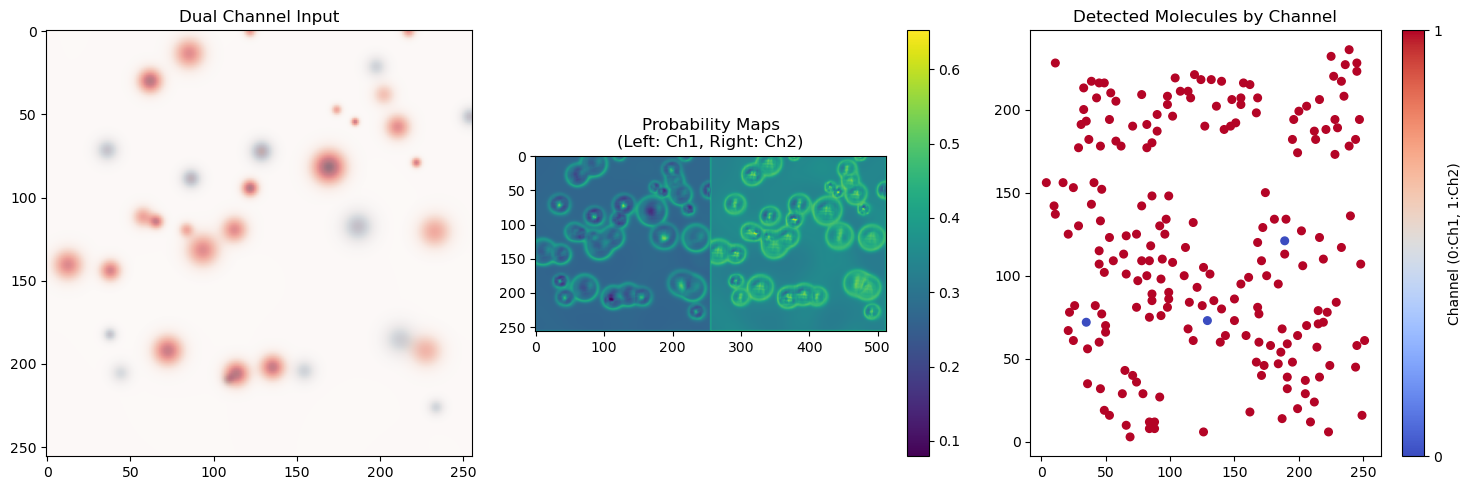

Val Epoch 10/50: 100%|██████████| 3/3 [00:01<00:00,  1.57it/s, val_loss=1.1083]


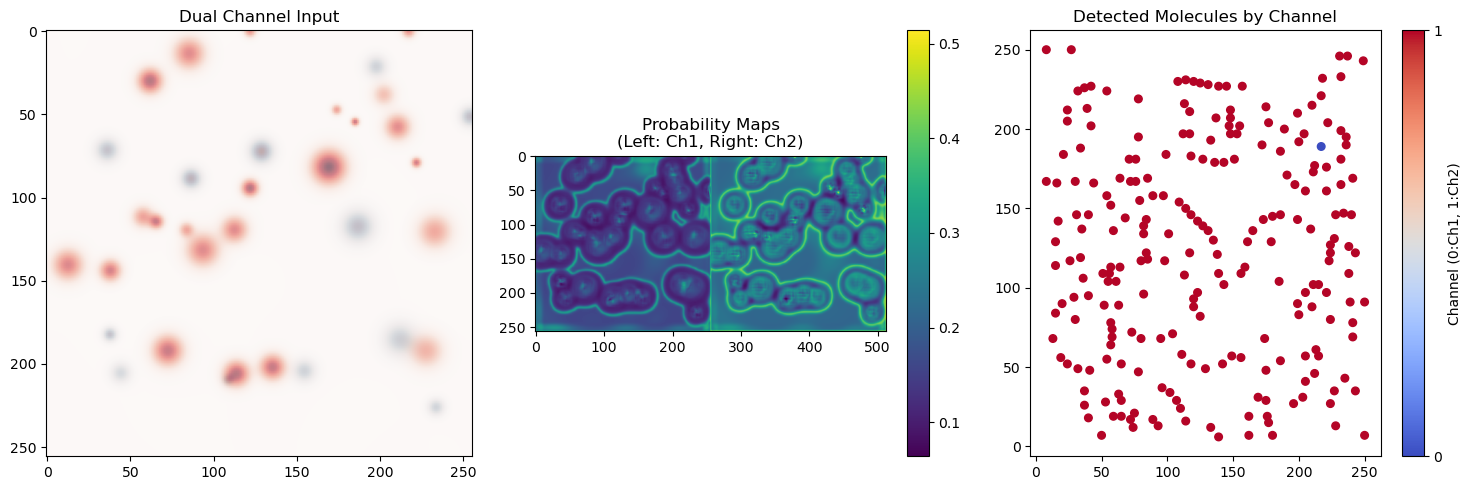

Val Epoch 15/50: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s, val_loss=0.8393]


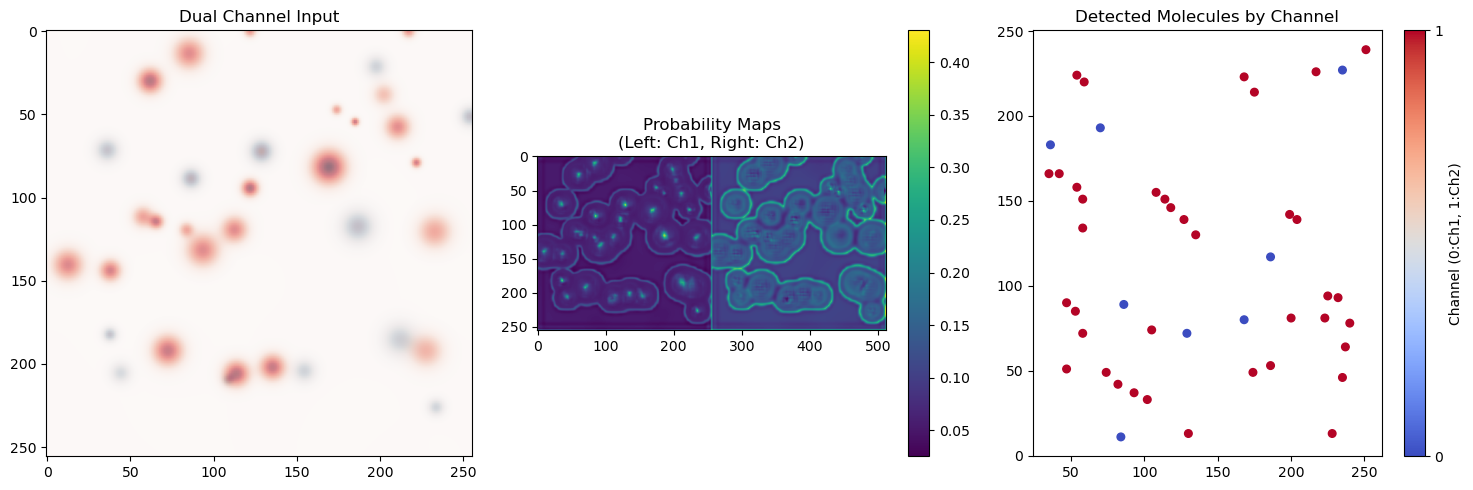

Val Epoch 20/50: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s, val_loss=0.7417]


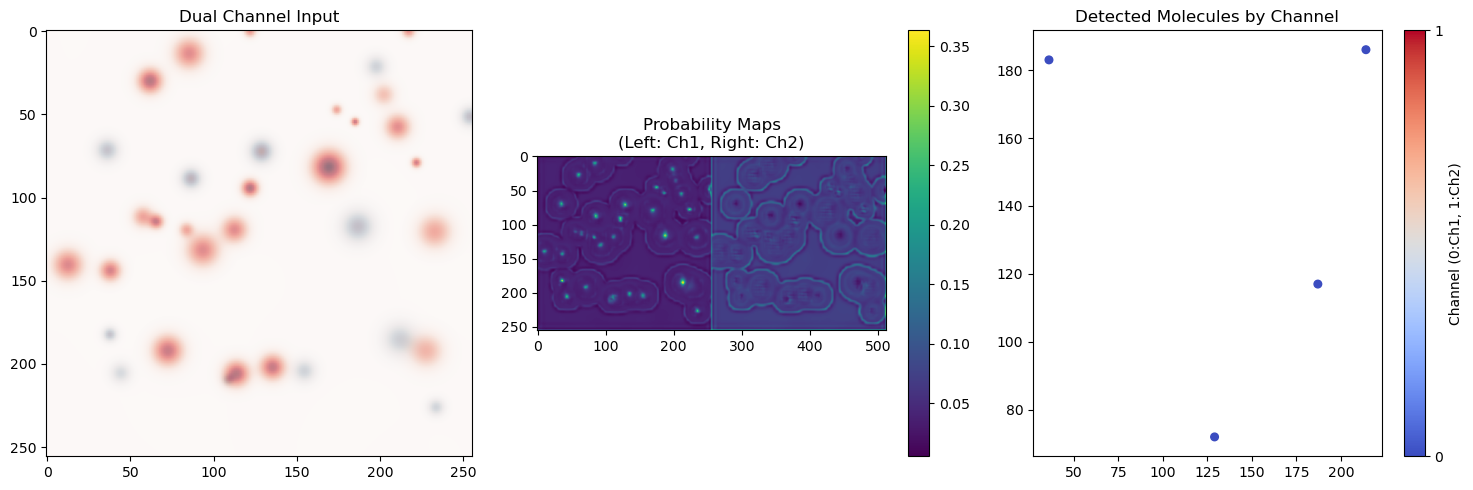

Val Epoch 25/50: 100%|██████████| 3/3 [00:00<00:00,  9.90it/s, val_loss=0.6976]


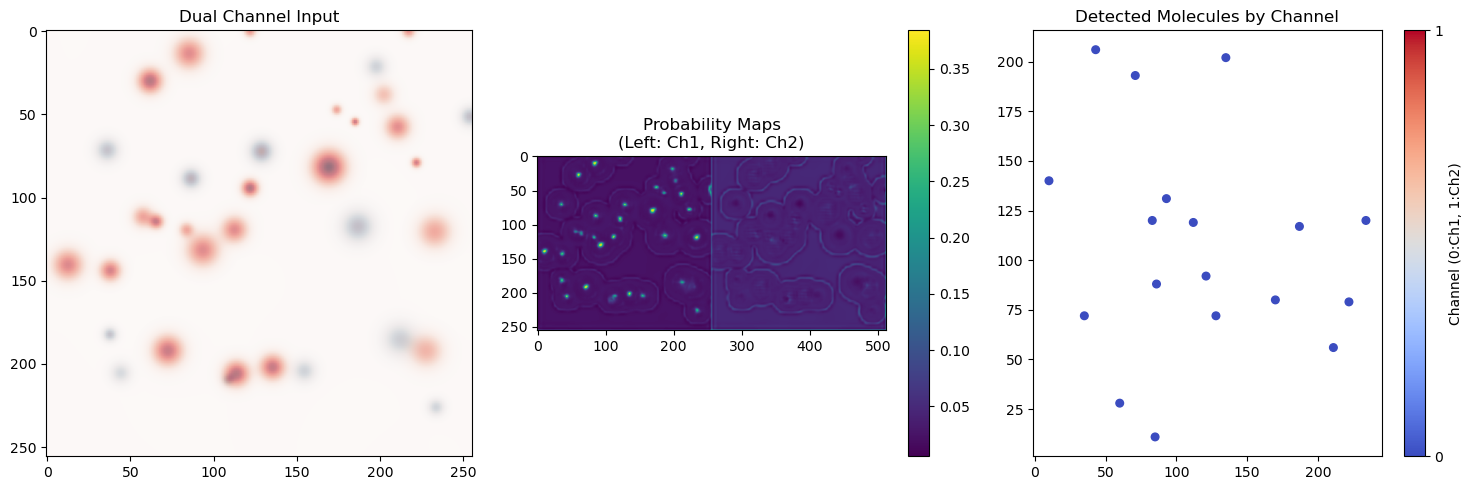

Val Epoch 30/50: 100%|██████████| 3/3 [00:00<00:00,  9.97it/s, val_loss=0.6682]


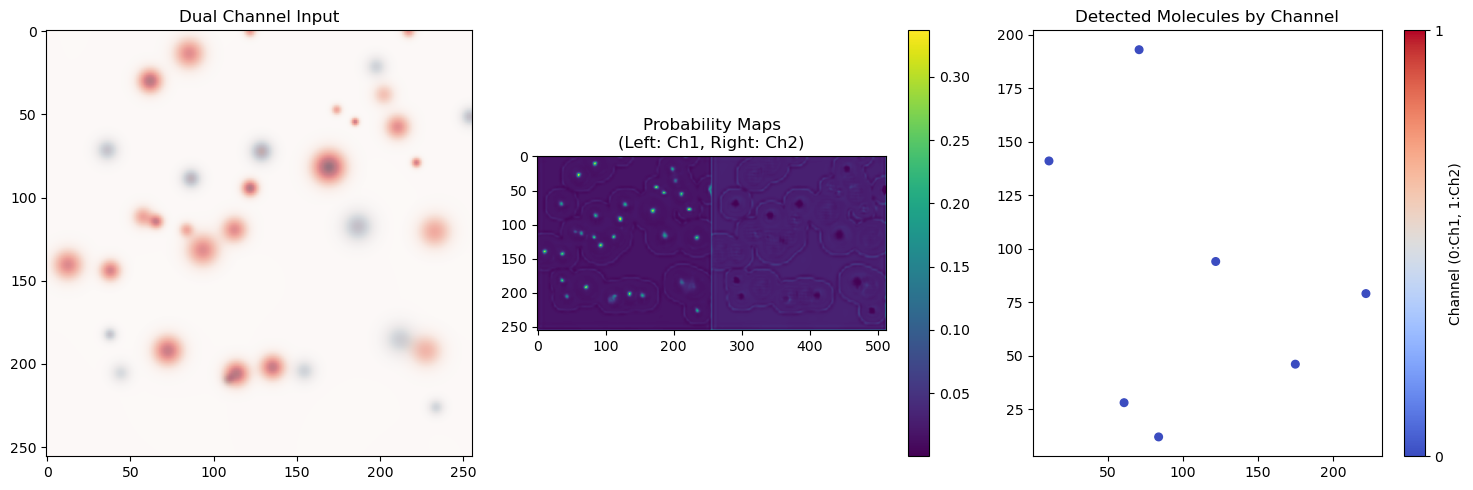

Val Epoch 35/50: 100%|██████████| 3/3 [00:00<00:00,  9.94it/s, val_loss=0.6487]


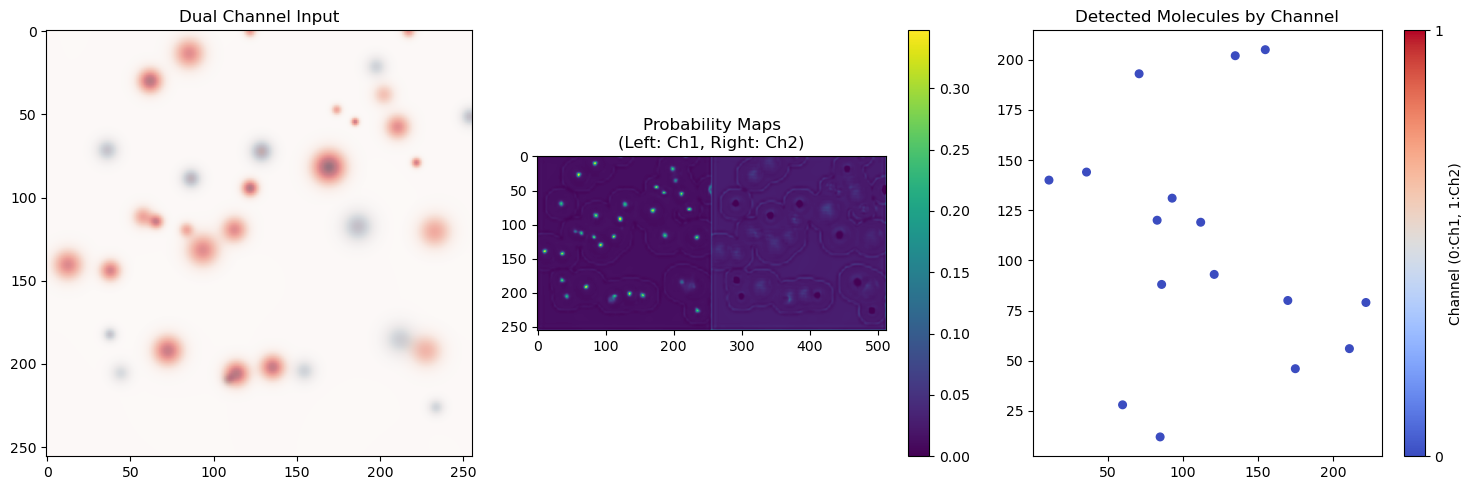

Val Epoch 40/50: 100%|██████████| 3/3 [00:00<00:00, 10.01it/s, val_loss=0.6187]


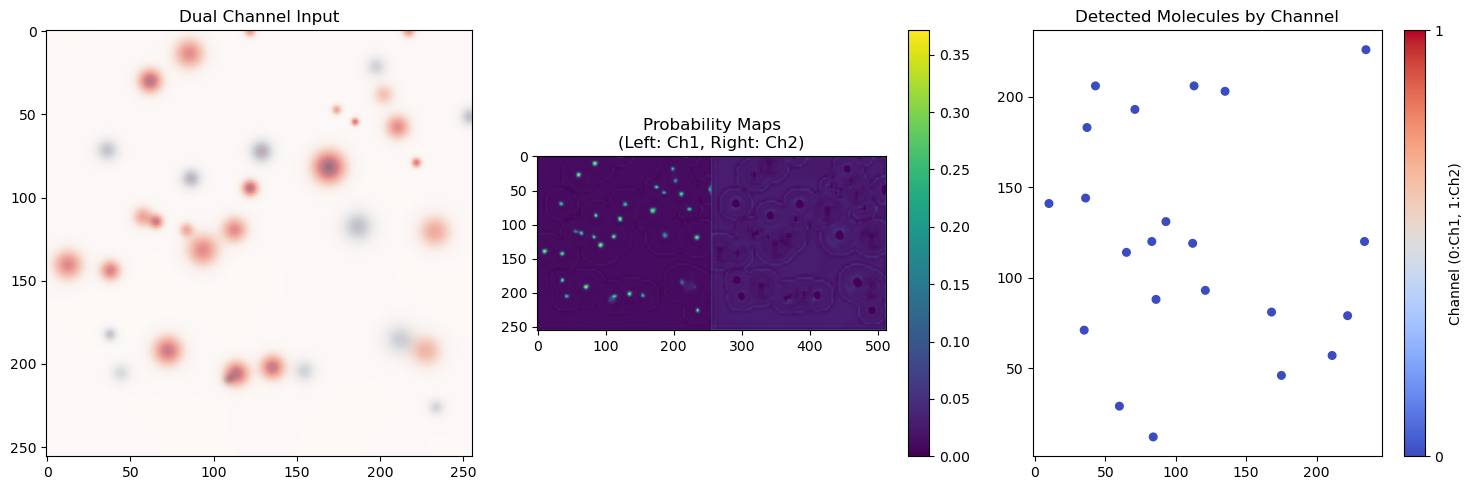

Val Epoch 45/50: 100%|██████████| 3/3 [00:00<00:00,  9.77it/s, val_loss=0.6013]


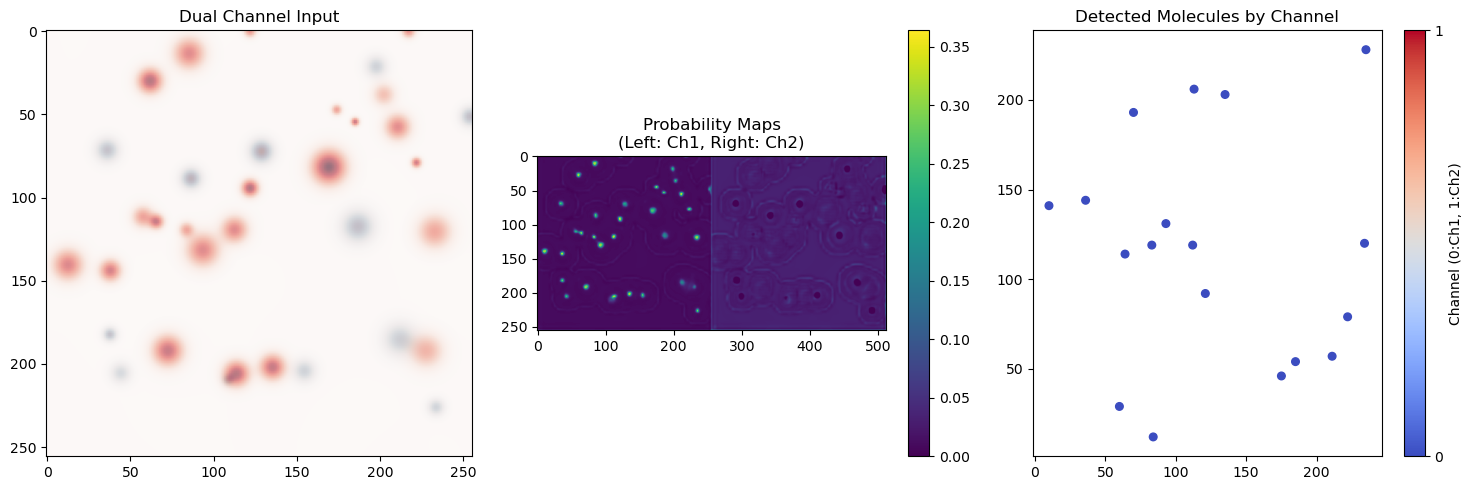

Val Epoch 50/50: 100%|██████████| 3/3 [00:00<00:00,  9.89it/s, val_loss=0.5598]


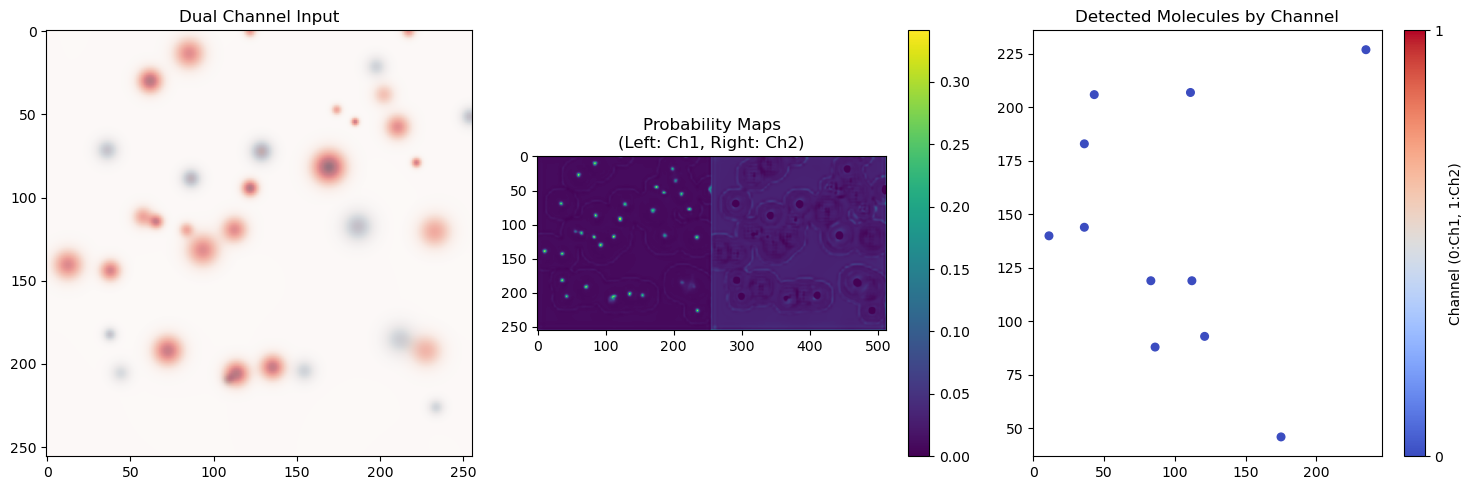


=== 最终评估 ===


AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [ ]:
import torch
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt

def main():
    # 配置参数
    CONFIG = {
        # 模型配置
        'base_ch': 32,
        'sig_pred': True,
        
        # 训练配置
        'lr': 1e-4,
        'weight_decay': 1e-5,
        'loss_weights': {
            'p': 1.0,
            'xyzi': 2.0,
            'color': 1.0
        },
        
        # 数据生成配置
        'image_size': 128,
        'pixel_size': 100,  # nm/pixel
        'psf_sigma': 1.5,
        'z_range': 0.8,
        'cross_ratios': {
            'ch1_to_ch2': 0.1,
            'ch2_to_ch1': 0.15
        },
        'num_molecules_range': [5, 15]
    }

    # 设备设置
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\n=== 使用设备: {device} ===")

    # 数据生成（如果不存在数据集）
    if not os.path.exists('./dataset/dataset.npz'):
        print("\n=== 生成训练数据 ===")
        generator = RatiometricDataGenerator(CONFIG)
        generator.generate_dataset(
            num_samples=500,
            save_dir='./dataset'
        )

    # 初始化系统组件
    print("\n=== 初始化模型与训练器 ===")
    model = DualChannelUNet(CONFIG).to(device)
    trainer = DualChannelTrainer(CONFIG)
    
    # 准备数据加载器
    print("\n=== 准备数据加载 ===")
    trainer.prepare_dataloaders(
        npz_path='./dataset/dataset.npz',
        batch_size=8,
        test_size=0.2
    )

    # 训练模型
    print("\n=== 开始训练 ===")
    training_history = trainer.train(epochs=50)

    # 最终评估与可视化
    print("\n=== 最终评估 ===")
    sample = next(iter(trainer.val_loader))
    with torch.no_grad():
        images = sample['image'].to(device)
        outputs = model(images)
        
        # 获取第一个样本的结果
        sample_image = sample['image'][0].cpu().numpy()
        gt_positions = sample['positions'][0]
        
        # 处理输出
        combined_df, ch1_df, ch2_df = DualChannelAnalyzer.postprocess(
            outputs, 
            gt_positions,
            threshold=0.5
        )
        
        # 可视化三图结果
        DualChannelAnalyzer.visualize_triple_results(
            sample_image,
            combined_df,
            ch1_df,
            ch2_df,
            gt_positions
        )
        
        # 显示性能指标
        DualChannelAnalyzer.plot_performance_metrics(
            combined_df,
            ch1_df,
            ch2_df,
            gt_positions
        )

    # 保存完整系统
    print("\n=== 保存最终模型 ===")
    torch.save({
        'config': CONFIG,
        'model_state': model.state_dict(),
        'optimizer_state': trainer.optimizer.state_dict(),
        'training_history': training_history
    }, 'final_system.pth')

if __name__ == '__main__':
    import os
    os.makedirs('./dataset', exist_ok=True)
    main()

# Version 3.0

## Datageneration

In [20]:
# -------------------- 模块1: 数据生成 --------------------
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from perlin_noise import PerlinNoise
from typing import Dict, Tuple

class RatiometricDataGenerator:
    def __init__(self, config: Dict):
        self.config = config
        self.image_size = config['image_size']
        self.pixel_size = config['pixel_size']  # nm/pixel
        self.psf_sigma = config['psf_sigma']  # PSF的sigma值（像素单位）
        
        # 通道参数
        self.channels = ['ch1', 'ch2']
        self.cross_ratios = {
            'ch1_to_ch2': config['cross_ratios']['ch1_to_ch2'],
            'ch2_to_ch1': config['cross_ratios']['ch2_to_ch1']
        }
        
        # 背景参数
        self.background_levels = {
            'ch1': config['background']['ch1'],
            'ch2': config['background']['ch2']
        }
        
        # 初始化Perlin噪声生成器
        self.noise_generator = PerlinNoise(octaves=4, seed=config['seed'])

    def generate_molecules(self, num_molecules: int) -> Dict:
        """生成分子属性（修正交叉比例计算）"""
        # 随机位置 (x, y, z)
        positions = np.random.rand(num_molecules, 3) * self.image_size
        positions[:, 2] = (positions[:, 2] * 2 - 1) * self.config['z_range']
        
        # 随机分配颜色标签
        colors = np.random.choice(['ch1', 'ch2'], num_molecules, 
                                p=[self.config['color_prob']['ch1'], 
                                   self.config['color_prob']['ch2']])
        
        # 初始化强度字典
        intensities = {'ch1': np.zeros(num_molecules), 'ch2': np.zeros(num_molecules)}
        
        # 逐个分子生成强度
        for i in range(num_molecules):
            color = colors[i]
            if color == 'ch1':
                mean = self.config['intensity']['ch1']['mean']
                std = self.config['intensity']['ch1']['std']
                main_intensity = np.abs(np.random.normal(mean, std))
                intensities['ch1'][i] = main_intensity
                intensities['ch2'][i] = main_intensity * self.cross_ratios['ch1_to_ch2']
            else:
                mean = self.config['intensity']['ch2']['mean']
                std = self.config['intensity']['ch2']['std']
                main_intensity = np.abs(np.random.normal(mean, std))
                intensities['ch2'][i] = main_intensity
                intensities['ch1'][i] = main_intensity * self.cross_ratios['ch2_to_ch1']
        
        return {
            'positions': positions,
            'intensities': intensities,
            'colors': colors
        }

    def _gaussian_psf(self, x, y, z, intensity):
        """生成高斯点扩散函数"""
        sigma = self.psf_sigma * (1 + 0.3 * np.abs(z))  # z-dependent PSF宽度
        size = int(7 * sigma)
        half_size = size // 2
        
        # 计算有效区域边界
        x_min = max(0, int(x) - half_size)
        x_max = min(self.image_size, int(x) + half_size + 1)
        y_min = max(0, int(y) - half_size)
        y_max = min(self.image_size, int(y) + half_size + 1)
        
        if x_min >= x_max or y_min >= y_max:
            return np.zeros((self.image_size, self.image_size))
        
        # 创建局部高斯分布
        xx, yy = np.meshgrid(np.arange(x_min, x_max), np.arange(y_min, y_max))
        psf = intensity * np.exp(-((xx - x)**2 + (yy - y)**2) / (2 * sigma**2))
        
        # 填充到全图
        full_psf = np.zeros((self.image_size, self.image_size))
        full_psf[y_min:y_max, x_min:x_max] = psf
        return full_psf
    
    def _generate_background(self, channel: str) -> np.ndarray:
        """生成背景噪声"""
        background = np.zeros((self.image_size, self.image_size))
        for i in range(self.image_size):
            for j in range(self.image_size):
                background[i,j] = self.noise_generator([i/self.image_size, j/self.image_size])
        
        # 缩放噪声强度
        bg_level = self.background_levels[channel]
        background = (background - background.min()) / (background.max() - background.min())
        return background * bg_level
    
    def _generate_ground_truth_maps(self, positions, colors, intensities, image_size):
        """生成Ground Truth映射"""
        p_map = np.zeros((1, image_size, image_size), dtype=np.float32)
        color_map = np.zeros_like(p_map)
        xyzi_map = np.zeros((4, image_size, image_size), dtype=np.float32)
        radius = 2
        
        # 生成高斯核模板
        xx, yy = np.meshgrid(np.arange(-radius, radius+1), 
                            np.arange(-radius, radius+1))
        gaussian_kernel = np.exp(-(xx**2 + yy**2)/(2*(radius/2)**2))
        
        for i in range(len(positions)):
            x, y, z = positions[i]
            xi = int(x.clip(0, image_size-1))
            yi = int(y.clip(0, image_size-1))
            
            # 生成概率热图
            x_min = max(0, xi - radius)
            x_max = min(image_size, xi + radius + 1)
            y_min = max(0, yi - radius)
            y_max = min(image_size, yi + radius + 1)
            
            if x_min < x_max and y_min < y_max:
                # 修正核裁剪方式
                kernel_x_start = radius - (xi - x_min)
                kernel_x_end = radius + (x_max - xi)
                kernel_y_start = radius - (yi - y_min)
                kernel_y_end = radius + (y_max - yi)
                
                kernel = gaussian_kernel[
                    kernel_y_start:kernel_y_end, 
                    kernel_x_start:kernel_x_end
                ]
                p_map[0, y_min:y_max, x_min:x_max] = np.maximum(
                    p_map[0, y_min:y_max, x_min:x_max], kernel)
            
            # 颜色标记
            color_map[0, yi, xi] = 1.0 if colors[i] == 'ch1' else 0.0
            
            # 坐标和强度
            xyzi_map[0, yi, xi] = x - xi  # x偏移
            xyzi_map[1, yi, xi] = y - yi  # y偏移
            xyzi_map[2, yi, xi] = z       # z位置
            xyzi_map[3, yi, xi] = intensities[i].sum()  # 总强度
        
        return p_map, color_map, xyzi_map
    
    def render_image(self, molecules: Dict) -> Tuple[np.ndarray, Dict]:
        """渲染双通道图像并生成所有映射"""
        ch1_image = np.zeros((self.image_size, self.image_size))
        ch2_image = np.zeros((self.image_size, self.image_size))
        
        # 渲染每个分子
        for i in range(len(molecules['positions'])):
            x, y, z = molecules['positions'][i]
            ch1_image += self._gaussian_psf(x, y, z, molecules['intensities']['ch1'][i])
            ch2_image += self._gaussian_psf(x, y, z, molecules['intensities']['ch2'][i])
        
        # 添加背景噪声
        ch1_image += self._generate_background('ch1')
        ch2_image += self._generate_background('ch2')
        
        # 合并为多通道图像
        combined_image = np.stack([ch1_image, ch2_image], axis=0)
        
        # 生成Ground Truth映射
        p_map, color_map, xyzi_map = self._generate_ground_truth_maps(
            molecules['positions'],
            molecules['colors'],
            np.stack([molecules['intensities']['ch1'], molecules['intensities']['ch2']], axis=1),
            self.image_size
        )
        
        return combined_image, {
            'positions': molecules['positions'],
            'intensities': np.stack([molecules['intensities']['ch1'], 
                                    molecules['intensities']['ch2']], axis=1),
            'colors': (molecules['colors'] == 'ch1').astype(int),
            'p_map': p_map,
            'color_map': color_map,
            'xyzi_map': xyzi_map
        }
    
    def generate_dataset(self, num_samples: int, save_dir: str):
        """生成完整数据集"""
        os.makedirs(save_dir, exist_ok=True)
        
        all_images = []
        all_gt = []
        
        for i in tqdm(range(num_samples), desc="Generating dataset"):
            num_molecules = np.random.randint(
                self.config['num_molecules_range'][0],
                self.config['num_molecules_range'][1]
            )
            
            molecules = self.generate_molecules(num_molecules)
            image, gt = self.render_image(molecules)
            
            if i == 0:
                self.visualize_sample(image, gt)
            
            all_images.append(image)
            all_gt.append(gt)
        
        # 转换为numpy数组
        np.savez_compressed(
            os.path.join(save_dir, 'dataset.npz'),
            images=np.array(all_images, dtype=np.float32),
            positions=np.array([gt['positions'] for gt in all_gt], dtype=object),
            intensities=np.array([gt['intensities'] for gt in all_gt], dtype=object),
            colors=np.array([gt['colors'] for gt in all_gt], dtype=object),
            p_maps=np.array([gt['p_map'] for gt in all_gt], dtype=np.float32),
            color_maps=np.array([gt['color_map'] for gt in all_gt], dtype=np.float32),
            xyzi_maps=np.array([gt['xyzi_map'] for gt in all_gt], dtype=np.float32)
        )
        print(f"Dataset saved to {save_dir}")

    def visualize_sample(self, image: np.ndarray, gt: Dict):
        """可视化样本"""
        plt.figure(figsize=(18, 6))
        
        # 显示输入图像
        plt.subplot(2, 2, 1)
        plt.imshow(image[0], cmap='hot')
        plt.title('Channel 1')
        plt.colorbar()
        
        plt.subplot(2, 2, 2)
        plt.imshow(image[1], cmap='hot')
        plt.title('Channel 2')
        plt.colorbar()
        
        # 显示Ground Truth映射
        plt.subplot(2, 2, 3)
        plt.imshow(gt['p_map'][0], cmap='hot')
        plt.title('Probability Map')
        
        plt.subplot(2, 2, 4, aspect='equal')
        plt.scatter(gt['positions'][:,0], gt['positions'][:,1], 
                   c=gt['colors'], cmap='coolwarm', s=5)
        plt.title('Molecule Positions')
        plt.gca().invert_yaxis()
        
        plt.tight_layout()
        plt.show()


## NNetwork

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SharedEncoder(nn.Module):
    """共享特征编码器（第一阶段）"""
    def __init__(self, config):
        super().__init__()
        self.blocks = nn.Sequential(
            # Block 1
            nn.Conv2d(2, config['base_ch'], 3, padding=1),
            nn.BatchNorm2d(config['base_ch']),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Block 2
            nn.Conv2d(config['base_ch'], config['base_ch']*2, 3, padding=1),
            nn.BatchNorm2d(config['base_ch']*2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Block 3
            nn.Conv2d(config['base_ch']*2, config['base_ch']*4, 3, padding=1),
            nn.BatchNorm2d(config['base_ch']*4),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.blocks(x)

class DetectionDecoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.up = nn.Sequential(
            # 修改上采样结构确保输出尺寸匹配
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(config['base_ch']*4, config['base_ch']*2, 3, padding=1),
            nn.BatchNorm2d(config['base_ch']*2),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(config['base_ch']*2, config['base_ch'], 3, padding=1),
            nn.BatchNorm2d(config['base_ch']),
            nn.ReLU(inplace=True),
            
            # 添加最终调整层
            nn.Conv2d(config['base_ch'], config['base_ch'], 3, padding=1),
            nn.Upsample(size=(128,128), mode='bilinear', align_corners=True)
        )
        
        self.loc_head = nn.Conv2d(config['base_ch'], 1, 3, padding=1)
        self.xyzi_head = nn.Conv2d(config['base_ch'], 4, 3, padding=1)
        
    def forward(self, x):
        x = self.up(x)
        return {
            'p_map': self.loc_head(x),  # 移除了sigmoid
            'xyzi': self.xyzi_head(x)   # 原始输出
        }

class ChannelClassifier(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(2, 8, 3, padding=1),  # 减少通道数
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(8, 1)
        
    def forward(self, x):
        x = self.conv(x).flatten(1)
        return self.fc(x)

class TwoStageDualNet(nn.Module):
    """重构后的两阶段双通道网络"""
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # 第一阶段组件
        self.shared_encoder = SharedEncoder(config)
        self.det_decoder = DetectionDecoder(config)
        
        # 第二阶段组件
        self.channel_classifier = ChannelClassifier(config)
        
        # 初始化
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # 第一阶段
        shared_feat = self.shared_encoder(x)
        det_output = self.det_decoder(shared_feat)
        
        # 第二阶段
        B, _, H, W = det_output['p_map'].shape
        ch_probs = torch.zeros(B, 1, H, W, device=x.device)
        
        # 生成坐标掩码（保留梯度）
        coord_mask = (det_output['p_map'] > self.config['det_thresh'])
        pos_coords = torch.nonzero(coord_mask.squeeze(1))  # [N,3]
        
        if len(pos_coords) > 0:
            # 修正后的坐标生成逻辑
            padded_x = F.pad(x, (2,2,2,2), mode='reflect')
            
            # 生成相对坐标网格（3x3替代5x5）
            kernel = torch.tensor([
                [-1,-1], [-1,0], [-1,1],
                [0,-1],  [0,0],  [0,1],
                [1,-1],  [1,0],  [1,1]
            ], device=x.device, dtype=torch.float)  # 9个位置
            
            # 调整坐标计算
            b_indices = pos_coords[:,0]
            y_centers = pos_coords[:,1].float() + 2  # 填充后坐标
            x_centers = pos_coords[:,2].float() + 2
            
            # 生成采样网格（更安全的方式）
            grid = (torch.stack([x_centers, y_centers], dim=1)
                    .unsqueeze(1) + kernel.unsqueeze(0))  # [N,9,2]
            
            # 归一化处理
            H_pad, W_pad = padded_x.shape[-2], padded_x.shape[-1]
            grid_x = (grid[...,0] + 0.5) / W_pad * 2 - 1
            grid_y = (grid[...,1] + 0.5) / H_pad * 2 - 1
            grid = torch.stack([grid_x, grid_y], dim=-1).view(-1,2)  # [N*9,2]
            
            # 优化后的采样方式
            samples = F.grid_sample(
                padded_x[b_indices.repeat_interleave(9)],  # 每个位置采样9次
                grid.unsqueeze(1).unsqueeze(1),  # 符合grid_sample输入格式
                align_corners=True
            ).squeeze().view(-1,9,2).permute(0,2,1).view(-1,2,3,3)  # 3x3 patch
            
            # 分类预测
            preds = self.channel_classifier(samples).squeeze()
            
            # 回填结果
            for idx, (b, y, x) in enumerate(pos_coords):
                ch_probs[b, 0, y, x] = preds[idx]
        
        return {
            'detection': det_output,
            'channel_prob': ch_probs,
            'pos_mask': coord_mask.float()
        }
    
    def predict(self, x, det_thresh=0.5):
        """推理接口"""
        with torch.no_grad():
            outputs = self.forward(x)
            
            # 生成最终预测
            det_map = (outputs['detection']['p_map'] > det_thresh).float()
            ch_pred = (outputs['channel_prob'] > 0.5).float()
            
            # 合并结果 [B,6,H,W]: x,y,z,i, p, ch
            final = torch.cat([
                outputs['detection']['xyzi'].sigmoid()[:, :3],  # x,y,z
                outputs['detection']['xyzi'][:, 3:4].relu(),    # intensity
                det_map,                                       # p
                ch_pred                                        # channel
            ], dim=1)
            
            return final

class HierarchicalLoss(nn.Module):
    """层次化损失函数"""
    def __init__(self, config):
        super().__init__()
        self.det_weight = config['det_weight']
        self.ch_weight = config['ch_weight']
        self.xyzi_weight = config['xyzi_weight']
        
    def forward(self, outputs, targets):
        # 检测损失
        det_loss = F.binary_cross_entropy_with_logits(
            outputs['detection']['p_map'],
            targets['all_p_map']
        )
        
        # 坐标回归损失（修正索引方式）
        pos_mask = (targets['all_p_map'] > 0.5)
        if pos_mask.sum() > 0:
            # 扩展pos_mask以匹配xyzi的通道维度
            pos_mask_expanded = pos_mask.expand(-1, 4, -1, -1)
            
            xyzi_pred = outputs['detection']['xyzi'][pos_mask_expanded].view(-1,4)
            xyzi_target = targets['xyzi'][pos_mask_expanded].view(-1,4)
            
            xy_loss = F.mse_loss(xyzi_pred[:, :2].sigmoid(), xyzi_target[:, :2])
            z_loss = F.mse_loss(xyzi_pred[:, 2:3].sigmoid(), xyzi_target[:, 2:3])
            i_loss = F.mse_loss(xyzi_pred[:, 3:4].relu(), xyzi_target[:, 3:4])
            
            xyzi_loss = (xy_loss + z_loss + i_loss) / 3
        else:
            xyzi_loss = torch.tensor(0.0, device=det_loss.device)
        
        # 通道分类损失
        if pos_mask.sum() > 0:
            ch_loss = F.binary_cross_entropy_with_logits(
                outputs['channel_prob'][pos_mask],
                targets['channel_label'][pos_mask]
            )
        else:
            ch_loss = torch.tensor(0.0, device=det_loss.device)
        
        total_loss = (
            self.det_weight * det_loss +
            self.xyzi_weight * xyzi_loss +
            self.ch_weight * ch_loss
        )
        
        return total_loss, {
            'total': total_loss.item(),
            'det': det_loss.item(),
            'xyzi': xyzi_loss.item(),
            'channel': ch_loss.item()
        }

## Dataloader

In [18]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import RandomApply
from functools import partial

class RatiometricDataset(Dataset):
    def __init__(self, npz_path, transform=None, augment=False):
        """
        双通道数据集加载器
        
        参数:
            npz_path: NPZ文件路径
            transform: 数据变换函数
            augment: 是否启用数据增强
        """
        data = np.load(npz_path, allow_pickle=True)
        self.images = data['images']  # [N,2,H,W]
        self.p_maps = data['p_maps']  # [N,1,H,W]
        self.xyzi_maps = data['xyzi_maps']  # [N,4,H,W]
        self.positions = data['positions']  # 分子位置列表
        self.transform = transform
        self.augment = augment
        
        # 预生成通道特定标签
        self._preprocess_labels()
        
    def _preprocess_labels(self):
        """生成通道特定的训练标签"""
        self.channel_labels = []
        self.all_p_maps = []
        
        for i in range(len(self.images)):
            # 确保xyzi_maps有4个通道
            if self.xyzi_maps[i].shape[0] < 4:
                padded = np.zeros((4, *self.xyzi_maps[i].shape[1:]))
                padded[:self.xyzi_maps[i].shape[0]] = self.xyzi_maps[i]
                self.xyzi_maps[i] = padded

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        sample = {
            'image': torch.from_numpy(self.images[idx].copy()).float(),
            'all_p_map': torch.from_numpy(self.all_p_maps[idx].copy()).float(),
            'xyzi': torch.from_numpy(self.xyzi_maps[idx][:4].copy()).float(),
            'channel_label': torch.from_numpy(self.channel_labels[idx].copy()).float(),
            'positions': self.positions[idx]
        }
        
        # 统一缩放所有数据到相同尺寸
        target_size = (128, 128)  # 与模型输出尺寸一致
        sample['image'] = F.interpolate(sample['image'].unsqueeze(0), 
                                size=target_size, mode='bilinear').squeeze(0)
        sample['all_p_map'] = F.interpolate(sample['all_p_map'].unsqueeze(0), 
                                size=target_size, mode='nearest').squeeze(0)
        sample['xyzi'] = F.interpolate(sample['xyzi'].unsqueeze(0), 
                                size=target_size, mode='bilinear').squeeze(0)
        sample['channel_label'] = F.interpolate(sample['channel_label'].unsqueeze(0), 
                                size=target_size, mode='nearest').squeeze(0)
        
        if self.augment:
            sample = self._augment_sample(sample)
            
        return sample
    
    def _augment_sample(self, sample):
        """应用数据增强"""
        # 随机通道强度扰动
        if np.random.rand() > 0.5:
            alpha = 0.8 + 0.4 * np.random.rand()  # 0.8-1.2
            beta = 0.8 + 0.4 * np.random.rand()
            sample['image'][0] *= alpha
            sample['image'][1] *= beta
            
        # 随机小角度旋转
        if np.random.rand() > 0.7:
            angle = np.random.uniform(-15, 15)
            for k in ['image', 'all_p_map', 'xyzi', 'channel_label']:
                sample[k] = rotate_tensor(sample[k], angle)
                
        # 随机高斯噪声
        if np.random.rand() > 0.5:
            noise = torch.randn_like(sample['image']) * 0.05
            sample['image'] += noise
            
        return sample

def rotate_tensor(tensor, angle):
    """旋转张量（简化版，实际应使用grid_sample）"""
    # 注意：这里需要根据实际需求实现正确的旋转逻辑
    return tensor  # 替换为实际的旋转实现

class DualChannelDataLoader:
    def __init__(self, npz_path, batch_size=4, shuffle=True, 
                 num_workers=0, augment=False):
        """
        双通道数据加载器封装
        
        参数:
            npz_path: 数据路径
            batch_size: 批大小
            shuffle: 是否打乱数据
            num_workers: 加载线程数
            augment: 是否启用增强
        """
        self.dataset = RatiometricDataset(
            npz_path,
            augment=augment
        )
        
        self.loader = DataLoader(
            self.dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            collate_fn=self.collate_fn,
            pin_memory=True
        )
    
    @staticmethod
    def collate_fn(batch):
        """自定义批处理函数"""
        return {
            'image': torch.stack([item['image'] for item in batch]),
            'all_p_map': torch.stack([item['all_p_map'] for item in batch]),
            'xyzi': torch.stack([item['xyzi'] for item in batch]),
            'channel_label': torch.stack([item['channel_label'] for item in batch]),
            'positions': [item['positions'] for item in batch]  # 保持为列表
        }
    
    def __iter__(self):
        return iter(self.loader)
    
    def __len__(self):
        return len(self.loader)

## Training

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import average_precision_score

class TwoStageTrainer:
    def __init__(self, config):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # 初始化两阶段模型
        self.model = TwoStageDualNet(config).to(self.device)
        
        # 优化器分组设置
        encoder_params = list(self.model.shared_encoder.parameters()) + \
                        list(self.model.det_decoder.parameters())
        cls_params = list(self.model.channel_classifier.parameters())
        
        self.optimizer = optim.AdamW([
            {'params': encoder_params, 'lr': config['lr']},
            {'params': cls_params, 'lr': config['cls_lr']}
        ], weight_decay=config['weight_decay'])
        
        # 学习率调度
        self.scheduler = optim.lr_scheduler.OneCycleLR(
            self.optimizer,
            max_lr=[config['lr'], config['cls_lr']],
            steps_per_epoch=len(self.train_loader) if hasattr(self, 'train_loader') else 100,
            epochs=config['epochs']
        )
        
        # 混合精度训练
        self.scaler = torch.cuda.amp.GradScaler(enabled=config['amp'])
        
        # 损失函数
        self.loss_fn = HierarchicalLoss(config)
        
        # 记录器
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'det_loss': [],
            'cls_loss': [],
            'det_precision': [],
            'det_recall': [],
            'cls_accuracy': []
        }

    def prepare_dataloaders(self, npz_path, batch_size=8, test_size=0.2):
        """准备两阶段数据加载器"""
        full_dataset = RatiometricDataset(npz_path, augment=True)
        
        # 划分训练验证集
        train_size = int((1 - test_size) * len(full_dataset))
        val_size = len(full_dataset) - train_size
        train_set, val_set = torch.utils.data.random_split(
            full_dataset, [train_size, val_size]
        )
        
        # 训练集启用增强
        train_set.dataset.augment = True
        val_set.dataset.augment = False
        
        self.train_loader = DataLoader(
            train_set,
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,
            pin_memory=True,
            collate_fn=DualChannelDataLoader.collate_fn
        )
        
        self.val_loader = DataLoader(
            val_set,
            batch_size=batch_size,
            shuffle=False,
            num_workers=0,
            pin_memory=True,
            collate_fn=DualChannelDataLoader.collate_fn
        )
        
        return self

    def train(self, epochs):
        best_metric = float('inf')
        
        for epoch in range(epochs):
            # 训练阶段
            self.model.train()
            if epoch < self.config['warmup_epochs']:
                self.model.channel_classifier.requires_grad_(False)
            
            train_metrics = {
                'loss': 0,
                'det_loss': 0,
                'cls_loss': 0,
                'det_p': 0,
                'cls_acc': 0
            }
            
            train_bar = tqdm(self.train_loader, desc=f'Train Epoch {epoch+1}/{epochs}')
            for batch in train_bar:
                self.optimizer.zero_grad()
                
                # 数据转移到设备
                images = batch['image'].to(self.device, non_blocking=True)
                targets = {
                    'all_p_map': batch['all_p_map'].to(self.device),
                    'xyzi': batch['xyzi'].to(self.device),
                    'channel_label': batch['channel_label'].to(self.device)
                }
                
                # 混合精度前向
                with torch.cuda.amp.autocast(enabled=self.config['amp']):
                    outputs = self.model(images)
                    loss, loss_dict = self.loss_fn(outputs, targets)
                
                # 反向传播
                self.scaler.scale(loss).backward()
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.scheduler.step()
                
                # 计算指标
                with torch.no_grad():
                    det_precision = self._calc_precision(
                        outputs['detection']['p_map'],
                        targets['all_p_map']
                    )
                    
                    cls_acc = self._calc_accuracy(
                        outputs['channel_prob'],
                        targets['channel_label'],
                        targets['all_p_map']
                    )
                
                # 更新统计
                train_metrics['loss'] += loss.item()
                train_metrics['det_loss'] += loss_dict['det']
                train_metrics['cls_loss'] += loss_dict['channel']
                train_metrics['det_p'] += det_precision
                train_metrics['cls_acc'] += cls_acc
                
                train_bar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'det': f"{loss_dict['det']:.4f}",
                    'cls': f"{loss_dict['channel']:.4f}"
                })
            
            # 验证阶段
            val_metrics = self._validate(epoch, epochs)
            
            # 记录历史
            self._update_history(train_metrics, val_metrics, epoch)
            
            # 模型保存
            if val_metrics['loss'] < best_metric:
                best_metric = val_metrics['loss']
                self._save_checkpoint(epoch, best_metric)
            
            # 可视化
            if (epoch + 1) % self.config['viz_freq'] == 0:
                self._visualize_results(epoch)

    def _validate(self, epoch, epochs):
        """验证阶段"""
        self.model.eval()
        metrics = {
            'loss': 0,
            'det_loss': 0,
            'cls_loss': 0,
            'det_p': 0,
            'cls_acc': 0,
            'det_recall': 0
        }
        
        val_bar = tqdm(self.val_loader, desc=f'Val Epoch {epoch+1}/{epochs}')
        with torch.no_grad():
            for batch in val_bar:
                images = batch['image'].to(self.device)
                targets = {
                    'all_p_map': batch['all_p_map'].to(self.device),
                    'xyzi': batch['xyzi'].to(self.device),
                    'channel_label': batch['channel_label'].to(self.device)
                }
                
                outputs = self.model(images)
                loss, loss_dict = self.loss_fn(outputs, targets)
                
                # 计算指标
                det_precision = self._calc_precision(
                    outputs['detection']['p_map'],
                    targets['all_p_map']
                )
                
                det_recall = self._calc_recall(
                    outputs['detection']['p_map'],
                    targets['all_p_map']
                )
                
                cls_acc = self._calc_accuracy(
                    outputs['channel_prob'],
                    targets['channel_label'],
                    targets['all_p_map']
                )
                
                # 更新统计
                metrics['loss'] += loss.item()
                metrics['det_loss'] += loss_dict['det']
                metrics['cls_loss'] += loss_dict['channel']
                metrics['det_p'] += det_precision
                metrics['det_recall'] += det_recall
                metrics['cls_acc'] += cls_acc
                
                val_bar.set_postfix({
                    'val_loss': f"{loss.item():.4f}",
                    'p': f"{det_precision:.3f}",
                    'r': f"{det_recall:.3f}"
                })
        
        # 平均指标
        for k in metrics:
            metrics[k] /= len(self.val_loader)
            
        return metrics

    def _calc_precision(self, pred, target):
        """计算检测精度"""
        pred_mask = (pred > self.config['det_thresh']).float()
        true_pos = (pred_mask * target).sum()
        false_pos = (pred_mask * (1 - target)).sum()
        return (true_pos / (true_pos + false_pos + 1e-6)).item()

    def _calc_recall(self, pred, target):
        """计算检测召回率"""
        pred_mask = (pred > self.config['det_thresh']).float()
        true_pos = (pred_mask * target).sum()
        actual_pos = target.sum()
        return (true_pos / (actual_pos + 1e-6)).item()

    def _calc_accuracy(self, pred, target, pos_mask):
        """计算通道分类准确率"""
        pred_mask = (pred > 0.5).float()
        correct = ((pred_mask == target) * pos_mask).sum()
        total = pos_mask.sum()
        return (correct / (total + 1e-6)).item()

    def _update_history(self, train_metrics, val_metrics, epoch):
        """更新训练历史"""
        n_train = len(self.train_loader)
        self.history['train_loss'].append(train_metrics['loss'] / n_train)
        self.history['val_loss'].append(val_metrics['loss'])
        self.history['det_loss'].append(train_metrics['det_loss'] / n_train)
        self.history['cls_loss'].append(train_metrics['cls_loss'] / n_train)
        self.history['det_precision'].append(val_metrics['det_p'])
        self.history['det_recall'].append(val_metrics['det_recall'])
        self.history['cls_accuracy'].append(val_metrics['cls_acc'])

    def _save_checkpoint(self, epoch, best_metric):
        """保存模型检查点"""
        torch.save({
            'epoch': epoch,
            'model_state': self.model.state_dict(),
            'optimizer_state': self.optimizer.state_dict(),
            'scaler_state': self.scaler.state_dict(),
            'best_metric': best_metric,
            'config': self.config
        }, f"best_model_epoch{epoch}.pth")

    def _visualize_results(self, epoch):
        """可视化训练结果"""
        self.model.eval()
        sample = next(iter(self.val_loader))
        
        with torch.no_grad():
            images = sample['image'].to(self.device)
            outputs = self.model(images)
            
            # 准备数据
            img_np = sample['image'][0].cpu().numpy()
            det_map = outputs['detection']['p_map'][0,0].cpu().numpy()
            ch_prob = outputs['channel_prob'][0,0].cpu().numpy()
            
            # 创建可视化
            plt.figure(figsize=(18, 6))
            
            # 子图1: 原始输入
            plt.subplot(1, 3, 1)
            plt.imshow(img_np[0], cmap='Blues', alpha=0.5)
            plt.imshow(img_np[1], cmap='Reds', alpha=0.5)
            plt.title('Dual Channel Input')
            
            # 子图2: 检测结果
            plt.subplot(1, 3, 2)
            plt.imshow(det_map, vmin=0, vmax=1)
            plt.colorbar()
            plt.title(f'Detection Prob (Epoch {epoch+1})')
            
            # 子图3: 通道分类
            plt.subplot(1, 3, 3)
            plt.imshow(ch_prob, vmin=0, vmax=1, cmap='coolwarm')
            plt.colorbar()
            plt.title('Channel Classification Prob')
            
            plt.tight_layout()
            plt.savefig(f'epoch_{epoch+1}_results.png')
            plt.close()
            
            # 绘制训练曲线
            self._plot_training_curves()

    def _plot_training_curves(self):
        """绘制训练曲线"""
        plt.figure(figsize=(12, 8))
        
        # 损失曲线
        plt.subplot(2, 2, 1)
        plt.plot(self.history['train_loss'], label='Train')
        plt.plot(self.history['val_loss'], label='Val')
        plt.title('Loss Curve')
        plt.legend()
        
        # 检测指标
        plt.subplot(2, 2, 2)
        plt.plot(self.history['det_precision'], label='Precision')
        plt.plot(self.history['det_recall'], label='Recall')
        plt.title('Detection Metrics')
        plt.legend()
        
        # 分类准确率
        plt.subplot(2, 2, 3)
        plt.plot(self.history['cls_accuracy'])
        plt.title('Channel Accuracy')
        
        plt.tight_layout()
        plt.savefig('training_curves.png')
        plt.close()

## Visulation

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from skimage.feature import peak_local_max
from scipy.spatial import distance_matrix
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve

class DualChannelVisualizer:
    @staticmethod
    def visualize_detection_quality(output_dict, gt_positions, img_size=(128, 128)):
        """
        可视化检测质量：显示TP/FP/FN分布
        参数:
            output_dict: 模型输出字典 {'detection':, 'channel_prob':}
            gt_positions: [N,4] array (x,y,z,channel)
            img_size: 图像尺寸
        """
        # 获取检测结果
        det_map = output_dict['detection']['p_map'][0,0].cpu().numpy()
        peaks = peak_local_max(det_map, min_distance=3, threshold_abs=0.3)
        
        # 匹配预测和GT
        matched = DualChannelVisualizer._match_predictions(
            peaks, 
            output_dict['channel_prob'][0,0].cpu().numpy(),
            gt_positions
        )
        
        # 创建分类结果图
        plt.figure(figsize=(12, 6))
        
        # 子图1：检测结果分类
        plt.subplot(1, 2, 1)
        plt.imshow(np.zeros(img_size), cmap='gray')
        
        # 绘制不同类别的点
        categories = {
            'True Positive': ('go', matched['true_pos']),
            'False Positive': ('ro', matched['false_pos']),
            'False Negative': ('mx', matched['false_neg'])
        }
        
        for name, (style, points) in categories.items():
            if len(points) > 0:
                plt.plot(points[:,0], points[:,1], style, markersize=8, label=name)
        
        plt.title('Detection Quality\n(TP: %d, FP: %d, FN: %d)' % (
            len(matched['true_pos']),
            len(matched['false_pos']),
            len(matched['false_neg'])
        ))
        plt.legend()
        
        # 子图2：定位误差分布
        plt.subplot(1, 2, 2)
        if len(matched['true_pos']) > 0:
            errors = np.sqrt(
                (matched['true_pos'][:,0] - matched['matched_gt'][:,0])**2 +
                (matched['true_pos'][:,1] - matched['matched_gt'][:,1])**2
            )
            plt.hist(errors, bins=20, color='skyblue', edgecolor='navy')
            plt.xlabel('Localization Error (pixels)')
            plt.ylabel('Count')
            plt.title('Localization Error Distribution\n(Mean: %.2f px)' % np.mean(errors))
        
        plt.tight_layout()
        plt.show()

    @staticmethod
    def visualize_channel_classification(output_dict, gt_positions):
        """
        可视化通道分类性能
        参数:
            output_dict: 模型输出字典
            gt_positions: [N,4] array (x,y,z,channel)
        """
        # 准备数据
        det_map = output_dict['detection']['p_map'][0,0].cpu().numpy()
        ch_prob = output_dict['channel_prob'][0,0].cpu().numpy()
        peaks = peak_local_max(det_map, min_distance=3, threshold_abs=0.3)
        
        # 匹配预测和GT
        matched = DualChannelVisualizer._match_predictions(peaks, ch_prob, gt_positions)
        
        if len(matched['true_pos']) == 0:
            return
        
        # 创建分类性能图
        plt.figure(figsize=(16, 4))
        
        # 子图1：混淆矩阵
        plt.subplot(1, 3, 1)
        pred_labels = (matched['pred_channel'] > 0.5).astype(int)
        true_labels = matched['true_channel']
        cm = confusion_matrix(true_labels, pred_labels)
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()
        tick_marks = np.arange(2)
        plt.xticks(tick_marks, ['Ch1', 'Ch2'])
        plt.yticks(tick_marks, ['Ch1', 'Ch2'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        
        # 添加数值标签
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        
        # 子图2：分类概率分布
        plt.subplot(1, 3, 2)
        for ch in [0, 1]:
            mask = (true_labels == ch)
            if mask.sum() > 0:
                plt.hist(
                    matched['pred_channel'][mask], 
                    bins=20, alpha=0.7,
                    label=f'True Ch{ch+1}',
                    range=(0, 1)
                )
        plt.xlabel('Predicted Channel Probability')
        plt.ylabel('Count')
        plt.title('Classification Probability Distribution')
        plt.legend()
        
        # 子图3：ROC曲线
        plt.subplot(1, 3, 3)
        fpr, tpr, _ = roc_curve(true_labels, matched['pred_channel'])
        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve (AUC=%.2f)' % roc_auc_score(true_labels, matched['pred_channel']))
        
        plt.tight_layout()
        plt.show()

    @staticmethod
    def visualize_3d_distribution(output_dict, gt_positions=None):
        """
        可视化3D空间分布
        参数:
            output_dict: 模型输出字典
            gt_positions: [N,4] array (x,y,z,channel)
        """
        # 获取预测结果
        det_map = output_dict['detection']['p_map'][0,0].cpu().numpy()
        ch_prob = output_dict['channel_prob'][0,0].cpu().numpy()
        xyzi = output_dict['detection']['xyzi'][0].cpu().numpy()
        
        peaks = peak_local_max(det_map, min_distance=3, threshold_abs=0.3)
        
        # 创建3D图
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # 绘制预测点
        if len(peaks) > 0:
            # 获取3D坐标 (x,y从peak位置+偏移量)
            x_coords = peaks[:,1] + xyzi[0, peaks[:,0], peaks[:,1]]
            y_coords = peaks[:,0] + xyzi[1, peaks[:,0], peaks[:,1]]
            z_coords = xyzi[2, peaks[:,0], peaks[:,1]]
            colors = ch_prob[peaks[:,0], peaks[:,1]]
            
            sc = ax.scatter(
                x_coords, y_coords, z_coords, 
                c=colors, cmap='coolwarm', vmin=0, vmax=1,
                s=20, alpha=0.8
            )
            plt.colorbar(sc, label='Channel Probability (0:Ch1, 1:Ch2)')
        
        # 绘制GT点
        if gt_positions is not None:
            gt_colors = ['blue' if ch == 0 else 'red' for ch in gt_positions[:,3]]
            ax.scatter(
                gt_positions[:,0], gt_positions[:,1], gt_positions[:,2],
                c=gt_colors, s=50, alpha=0.3, label='Ground Truth'
            )
        
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.set_zlabel('Z Position')
        ax.set_title('3D Molecule Distribution')
        plt.legend()
        plt.tight_layout()
        plt.show()

    @staticmethod
    def visualize_confidence_analysis(output_dict):
        """
        可视化置信度分析
        """
        det_map = output_dict['detection']['p_map'][0,0].cpu().numpy()
        ch_prob = output_dict['channel_prob'][0,0].cpu().numpy()
        
        # 获取所有预测点
        peaks = peak_local_max(det_map, min_distance=3, threshold_abs=0.1)
        if len(peaks) == 0:
            return
        
        # 计算各项指标
        det_confs = det_map[peaks[:,0], peaks[:,1]]
        ch_confs = np.abs(ch_prob[peaks[:,0], peaks[:,1]] - 0.5) * 2  # 转换为0-1
        
        # 创建分析图
        plt.figure(figsize=(15, 4))
        
        # 子图1：检测置信度分布
        plt.subplot(1, 3, 1)
        plt.hist(det_confs, bins=20, color='teal', alpha=0.7)
        plt.xlabel('Detection Confidence')
        plt.ylabel('Count')
        plt.title('Detection Confidence Distribution')
        
        # 子图2：分类置信度分布
        plt.subplot(1, 3, 2)
        plt.hist(ch_confs, bins=20, color='purple', alpha=0.7)
        plt.xlabel('Classification Confidence')
        plt.ylabel('Count')
        plt.title('Classification Confidence Distribution')
        
        # 子图3：两者相关性
        plt.subplot(1, 3, 3)
        plt.scatter(det_confs, ch_confs, alpha=0.5)
        plt.xlabel('Detection Confidence')
        plt.ylabel('Classification Confidence')
        plt.title('Confidence Correlation\n(Pearson=%.2f)' % 
                 np.corrcoef(det_confs, ch_confs)[0,1])
        
        plt.tight_layout()
        plt.show()

    @staticmethod
    def _match_predictions(peaks, ch_prob, gt_positions, max_dist=3):
        """匹配预测和真实位置"""
        results = {
            'true_pos': [],
            'false_pos': [],
            'false_neg': [],
            'matched_gt': [],
            'pred_channel': [],
            'true_channel': []
        }
        
        # 如果没有GT，全部视为FP
        if gt_positions is None or len(gt_positions) == 0:
            return {
                'true_pos': np.zeros((0, 2)),
                'false_pos': peaks[:, [1,0]] if len(peaks) > 0 else np.zeros((0, 2)),
                'false_neg': np.zeros((0, 2)),
                'matched_gt': np.zeros((0, 2)),
                'pred_channel': ch_prob[peaks[:,0], peaks[:,1]] if len(peaks) > 0 else np.zeros(0),
                'true_channel': np.zeros(0)
            }
        
        # 计算距离矩阵 (注意坐标顺序：peaks是(y,x), gt是(x,y))
        pred_points = np.column_stack([peaks[:,1], peaks[:,0]]) if len(peaks) > 0 else np.zeros((0, 2))
        gt_points = gt_positions[:, :2]
        
        if len(pred_points) > 0 and len(gt_points) > 0:
            dists = distance_matrix(pred_points, gt_points)
        else:
            dists = np.zeros((len(pred_points), len(gt_points)))
        
        # 标记已匹配的GT
        matched_gt = np.zeros(len(gt_points), dtype=bool)
        
        # 处理每个预测点
        for i, (x, y) in enumerate(pred_points):
            min_dist_idx = np.argmin(dists[i])
            if dists[i, min_dist_idx] <= max_dist:
                results['true_pos'].append([x, y])
                results['matched_gt'].append(gt_points[min_dist_idx])
                results['pred_channel'].append(ch_prob[y, x])
                results['true_channel'].append(gt_positions[min_dist_idx, 3])
                matched_gt[min_dist_idx] = True
            else:
                results['false_pos'].append([x, y])
        
        # 未匹配的GT视为FN
        for i, (x, y) in enumerate(gt_points):
            if not matched_gt[i]:
                results['false_neg'].append([x, y])
        
        # 转换为numpy数组
        for k in results:
            results[k] = np.array(results[k]) if len(results[k]) > 0 else np.zeros((0, 2))
        
        return results

    @staticmethod
    def generate_interactive_report(output_dict, gt_positions, save_path='report.html'):
        """
        生成交互式HTML报告
        参数:
            output_dict: 模型输出字典
            gt_positions: [N,4] array (x,y,z,channel)
            save_path: 报告保存路径
        """
        from bokeh.plotting import figure, output_file, save
        from bokeh.layouts import gridplot, column
        from bokeh.models import HoverTool, ColumnDataSource
        from bokeh.palettes import RdBu
        
        # 准备数据
        det_map = output_dict['detection']['p_map'][0,0].cpu().numpy()
        ch_prob = output_dict['channel_prob'][0,0].cpu().numpy()
        peaks = peak_local_max(det_map, min_distance=3, threshold_abs=0.3)
        
        # 匹配预测和GT
        matched = DualChannelVisualizer._match_predictions(peaks, ch_prob, gt_positions)
        
        # 创建数据源
        source = ColumnDataSource(data={
            'x': peaks[:,1] if len(peaks) > 0 else [],
            'y': peaks[:,0] if len(peaks) > 0 else [],
            'det_conf': det_map[peaks[:,0], peaks[:,1]] if len(peaks) > 0 else [],
            'ch_prob': ch_prob[peaks[:,0], peaks[:,1]] if len(peaks) > 0 else [],
            'status': ['TP' if (x,y) in matched['true_pos'] else 'FP' 
                      for x,y in (peaks[:, [1,0]] if len(peaks) > 0 else [])]
        })
        
        # 创建HTML输出
        output_file(save_path)
        
        # 图1：检测结果概览
        p1 = figure(title="Detection Overview", tools="pan,wheel_zoom,box_zoom,reset")
        p1.image(image=[det_map], x=0, y=0, dw=det_map.shape[1], dh=det_map.shape[0], 
                palette="Greys256")
        
        # 添加预测点
        color_mapper = RdBu[10]
        p1.circle('x', 'y', size=8, source=source,
                 color={'field': 'ch_prob', 'transform': color_mapper},
                 alpha='det_conf', legend_field='status')
        
        # 添加交互工具
        hover = HoverTool(tooltips=[
            ("(x,y)", "(@x, @y)"),
            ("det_conf", "@det_conf{0.2f}"),
            ("ch_prob", "@ch_prob{0.2f}"),
            ("status", "@status")
        ])
        p1.add_tools(hover)
        
        # 图2：通道概率分布
        p2 = figure(title="Channel Probability Distribution", width=400, height=400)
        p2.histogram(ch_prob.flatten(), bins=50, alpha=0.7)
        
        # 保存报告
        save(gridplot([[p1, p2]], sizing_mode='stretch_both'))

## Main

### DataGengeration

In [14]:
"""
generate_data.py - 只负责生成和保存数据集
"""
import os

if __name__ == '__main__':
    # 配置参数 (优化后的参数)
    DATA_CONFIG = {
        'image_size': 256,          # 减小图像尺寸以加快生成速度
        'pixel_size': 100,          # nm/pixel
        'psf_sigma': 1.5,           # PSF sigma值
        'z_range': 0.025,             # z轴范围(微米)
        'seed': 42,                 # 随机种子
        
        # 分子参数
        'cross_ratios': {
            'ch1_to_ch2': 0.3,     # 通道1到通道2的交叉比例
            'ch2_to_ch1': 0.3       # 通道2到通道1的交叉比例
        },
        'color_prob': {
            'ch1': 0.5,             # 通道1分子概率
            'ch2': 0.5              # 通道2分子概率
        },
        'intensity': {
            'ch1': {'mean': 800, 'std': 150},  # 通道1强度分布
            'ch2': {'mean': 1000, 'std': 200}   # 通道2强度分布
        },
        
        # 背景参数
        'background': {
            'ch1': 10,              # 通道1背景水平
            'ch2': 5               # 通道2背景水平
        },
        
        # 分子数量范围
        'num_molecules_range': [20, 40]  # 每帧分子数量范围
    }

    # 确保dataset目录存在
    os.makedirs('./dataset', exist_ok=True)
    
    print("=== 开始数据生成 ===")
    print("配置参数:")
    for k, v in DATA_CONFIG.items():
        print(f"{k}: {v}")
    
    # 生成数据 (增加样本数量)
    generator = RatiometricDataGenerator(DATA_CONFIG)
    generator.generate_dataset(num_samples=100, save_dir='./dataset')
    
    print("\n数据集生成完成，保存在 ./dataset/dataset.npz")
    print(f"图像尺寸: {DATA_CONFIG['image_size']}x{DATA_CONFIG['image_size']}")
    print(f"样本数量: 1000")

=== 开始数据生成 ===
配置参数:
image_size: 256
pixel_size: 100
psf_sigma: 1.5
z_range: 0.025
seed: 42
cross_ratios: {'ch1_to_ch2': 0.3, 'ch2_to_ch1': 0.3}
color_prob: {'ch1': 0.5, 'ch2': 0.5}
intensity: {'ch1': {'mean': 800, 'std': 150}, 'ch2': {'mean': 1000, 'std': 200}}
background: {'ch1': 10, 'ch2': 5}
num_molecules_range: [20, 40]


NameError: name 'RatiometricDataGenerator' is not defined

In [20]:
import os
import torch
from datetime import datetime

def main():
    # 完整配置参数（包含所有模块需要的参数）
    CONFIG = {
        # === 核心参数 ===
        'base_ch': 4,
        'image_size': 64,
        
        # === 训练参数 ===
        'epochs': 50,
        'warmup_epochs': 5,
        'batch_size': 4,
        'lr': 1e-4,
        'cls_lr': 1e-3,
        'weight_decay': 1e-5,
        'amp': True,
        'viz_freq': 5,
        'det_thresh': 0.5,
        
        # === 损失权重 ===
        'det_weight': 1.0,    # 检测损失权重
        'xyzi_weight': 2.0,   # 坐标回归权重
        'ch_weight': 1.0,     # 通道分类权重
        
        # === 模型参数 ===
        'sig_pred': True
    }

    # 设备设置
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\n=== 使用设备: {device} ===")

    # === 初始化系统 ===
    print("\n=== 初始化模型与训练器 ===")
    
    model = TwoStageDualNet(CONFIG).to(device)
    trainer = TwoStageTrainer(CONFIG)

    # === 数据加载 ===
    print("\n=== 准备数据加载 ===")
    if not os.path.exists('./dataset/dataset.npz'):
        raise FileNotFoundError("未找到数据集，请先生成数据集")
    
    trainer.prepare_dataloaders(
        npz_path='./dataset/dataset.npz',
        batch_size=CONFIG['batch_size'],
        test_size=0.2
    )

    # === 训练循环 ===
    print("\n=== 开始训练 ===")
    trainer.train(epochs=CONFIG['epochs'])

    # === 最终评估 ===
    print("\n=== 最终评估 ===")
    
    sample = next(iter(trainer.val_loader))
    with torch.no_grad():
        outputs = model(sample['image'].to(device))
        
        combined_df, ch1_df, ch2_df = DualChannelAnalyzer.process_two_stage_output(
            outputs, 
            sample['positions'][0],
            det_thresh=CONFIG['det_thresh']
        )
        
        # 可视化
        DualChannelAnalyzer.visualize_triple_results(
            sample['image'][0].cpu().numpy(),
            combined_df,
            ch1_df,
            ch2_df,
            sample['positions'][0]
        )
        
        # 性能指标
        DualChannelAnalyzer.plot_performance_metrics(
            combined_df,
            ch1_df,
            ch2_df,
            sample['positions'][0]
        )

    # === 模型保存 ===
    print("\n=== 保存最终模型 ===")
    torch.save({
        'config': CONFIG,
        'model_state': model.state_dict(),
        'optimizer_state': trainer.optimizer.state_dict(),
        'scaler_state': trainer.scaler.state_dict()
    }, 'final_system.pth')

if __name__ == '__main__':
    os.makedirs('./dataset', exist_ok=True)
    main()


=== 使用设备: cuda ===

=== 初始化模型与训练器 ===

=== 准备数据加载 ===


C:\Users\Siyuan\AppData\Local\Temp\ipykernel_7016\3136027973.py:37: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=config['amp'])



=== 开始训练 ===


Train Epoch 1/50:   0%|          | 0/20 [00:00<?, ?it/s]


IndexError: list index out of range